In [1]:
# Usual suspect
import numpy as np
import sys
import math
import pandas as pd
from typing import Tuple
sys.path.insert(1, '../../muograph')

%reload_ext autoreload
%autoreload 2

# **Muon scattering tomography reconstruction: Noise reduction in poca images**

In [2]:
# Replace the 
input_hits_csv = "../../data/iron_barrel/barrel_and_cubes_scattering.csv"
pd.read_csv(input_hits_csv).columns

Index(['Event', 'X0', 'Y0', 'Z0', 'Edep0', 'X1', 'Y1', 'Z1', 'Edep1', 'X2',
       'Y2', 'Z2', 'Edep2', 'X3', 'Y3', 'Z3', 'Edep3', 'X4', 'Y4', 'Z4',
       'Edep4', 'X5', 'Y5', 'Z5', 'Edep5', 'E', 'Theta'],
      dtype='object')

# **Muon hits**

Unlike in exercice 1, we will simulate the spatial resolution of the detector by applying Gaussian smearing to the hits.

It is done by specifying the desired resolution along the $x$, $y$, and $z$ direction in the `spatial_res` argument.

We only apply smearing along the $x$ and $y$ direction as we know precisly the $z$ position of the detector panel.

In [3]:
import torch
from hits.hits import Hits

# Resolution in the horizontal plane
sigma_xy = 1.

# Resolution along the vertical direction
sigma_z = 0

# Load incoming hits from csv
hits_in = Hits(
    plane_labels=(0, 1, 2),
    csv_filename=input_hits_csv,
    spatial_res=torch.tensor([sigma_xy, sigma_xy, sigma_z])
    )

# Load outgoing hits from csv
hits_out = Hits(
    plane_labels=(3, 4, 5), 
    csv_filename=input_hits_csv,
    spatial_res=torch.tensor([sigma_xy, sigma_xy, sigma_z])
    )

GPU is not available. Using CPU


/home/geant/Desktop/TASKS/Muograph/MuographBeta/examples/exercices/../../muograph/hits/hits.py:67: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(spatial_res, dtype=dtype_hit, device=DEVICE)


# **Tracking**


In [4]:
# Output directory where to save the plots and data
output_dir = "../../output/test1/"

from tracking.tracking import Tracking

# Compute the muon tracks for the incoming hits
tracks_in = Tracking(
    hits = hits_in, 
    label = "above", 
    output_dir=output_dir, 
    compute_angular_res=True)


../../output/test1 directory already exists
Class attributes saved at ../../output/test1/tracks_above_.hdf5


Because of the detector spatail resolution, there is an error on the measurement of the muon zenith angle:

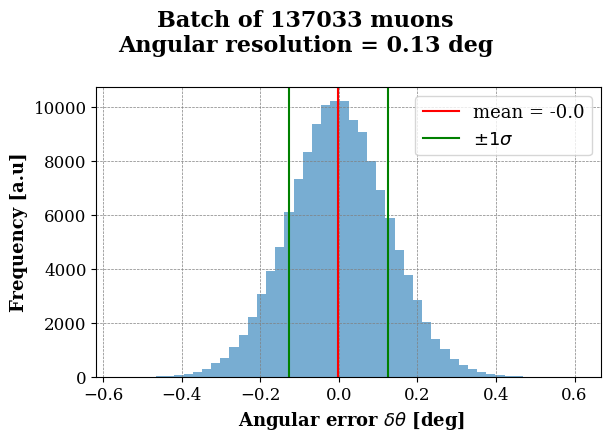

In [5]:
tracks_in.plot_angular_error()

In [6]:
# Compute the muon tracks for the outgoing hits
tracks_out = Tracking(
    hits = hits_out, 
    label = "below", 
    output_dir=output_dir,
    compute_angular_res=True)


../../output/test1 directory already exists
Class attributes saved at ../../output/test1/tracks_below_.hdf5


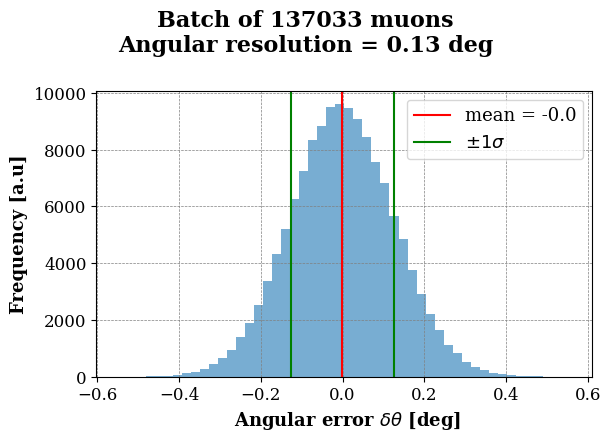

In [7]:
tracks_out.plot_angular_error()

In [8]:
from tracking.tracking import TrackingMST

# Load from tracking files
tracking_files = [
    "../../output/test1/" + "tracks_above_.hdf5",
    "../../output/test1/" + "tracks_below_.hdf5"
]
# Combine tracking of incoming and outgoing hits into a single object
mst = TrackingMST(tracking_files = tracking_files)


/home/geant/Desktop/TASKS/Muograph/MuographBeta/output directory already exists

Tracking attributes loaded from ../../output/test1/tracks_above_.hdf5

Tracking attributes loaded from ../../output/test1/tracks_below_.hdf5
0 muon removed due to detector efficiency


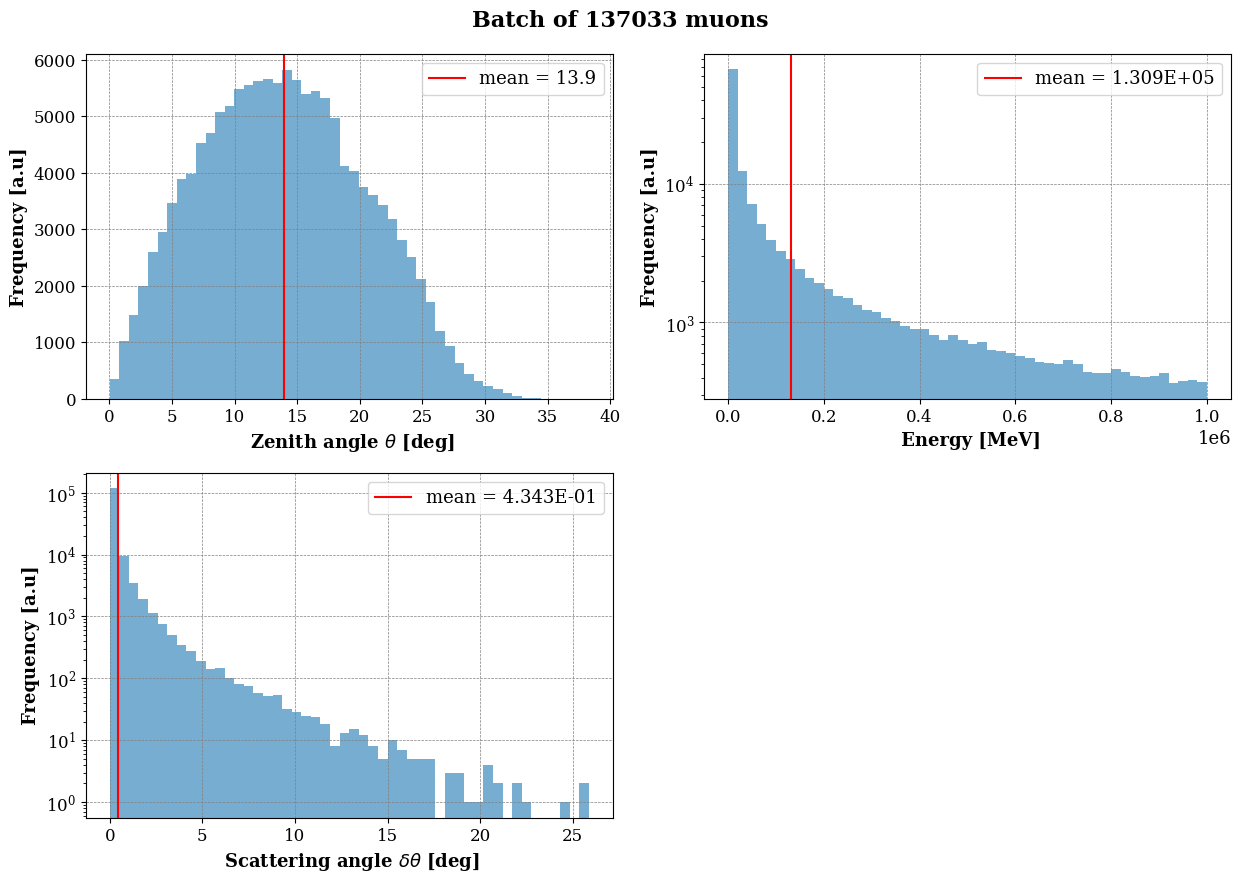

In [9]:
# Plot the features of the muons
mst.plot_muon_features(figname="test_plot")

**Question**

 - Compare the obtained scattering angle distribution with the one from exercice 1. What do you notice? Explain in detail what causes this difference. 

# **Reconstruction**

### POCA

We run the POCA algorithm by including all the muons in the dataset.

In [10]:
# Define the volume of interest

from volume.volume import Volume
voi = Volume(
    position = [0,0,-1200],
    dimension=[1000,600,600],
    voxel_width=20)

In [11]:
from reconstruction.poca import POCA

poca = POCA(
    tracking=mst, # The tracks
    voi = voi,# The volume of interest
    output_dir=output_dir + "poca/", # The path to the diretcory wherre to save the data
)


../../output/test1/poca directory already exists

Assigning voxel to each POCA point:


Class attributes saved at ../../output/test1/poca/poca.hdf5


Plot 3D scattering density predictions on 2D projections.

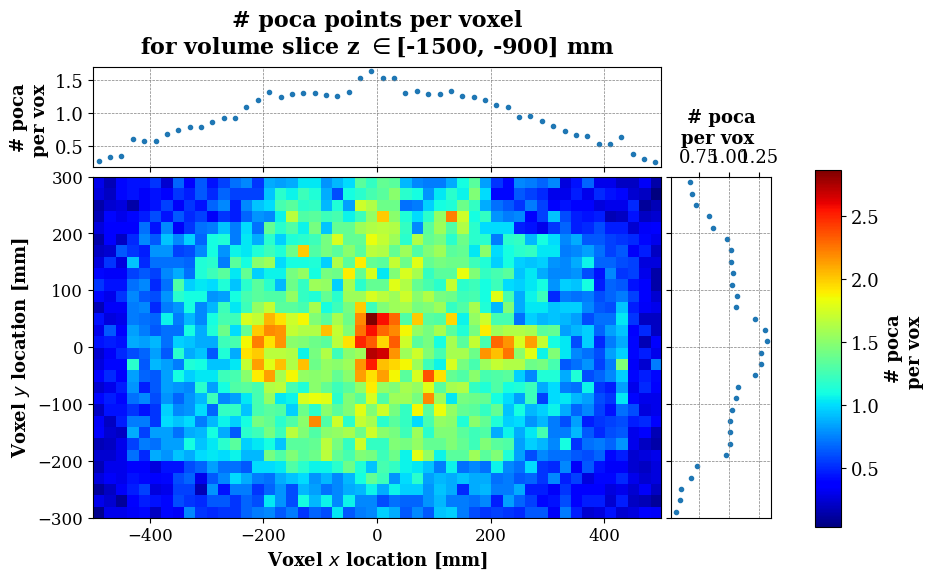

In [12]:
dim = 2

# Plot the predictions in the XY plane
poca.plot_pred_slice(
    voi = voi, # The volume of interest
    xyz_voxel_preds=poca.n_poca_per_vox, # 3D prediction to plot
    dim = 2, # Projection, 2 == XY projection
    filename = str(poca.output_dir) + "/no_dtheta_cut", # Where to save the plot
    voi_slice = (0, voi.n_vox_xyz[dim] - 1), # The range of voxels to consider
    fig_suptitle="# poca points per voxel", # Title of the figure
    pred_label = "# poca\nper vox",
    pred_unit = ""
)

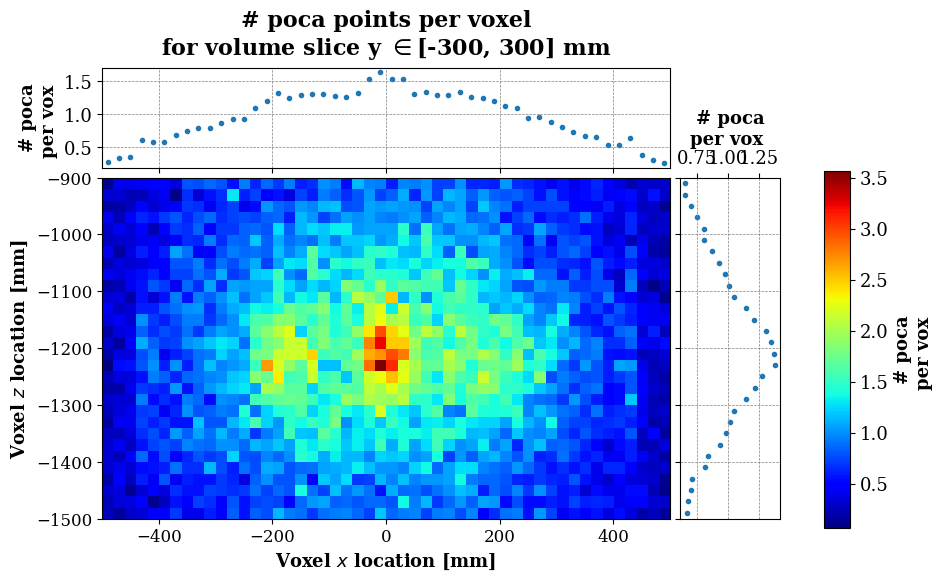

In [13]:
dim = 1

# Plot the predictions in the XZ plane
poca.plot_pred_slice(
    voi = voi, # The volume of interest
    xyz_voxel_preds=poca.n_poca_per_vox, # 3D prediction to plot
    dim = 1, # Projection, 1 == XZ projection
    filename = str(poca.output_dir) + "/no_dtheta_cut", # Where to save the plot
    voi_slice = (0, voi.n_vox_xyz[dim] - 1), # The range of voxels to consider
    fig_suptitle="# poca points per voxel", # Title of the figure
    pred_label = "# poca\nper vox",
    pred_unit = ""
)

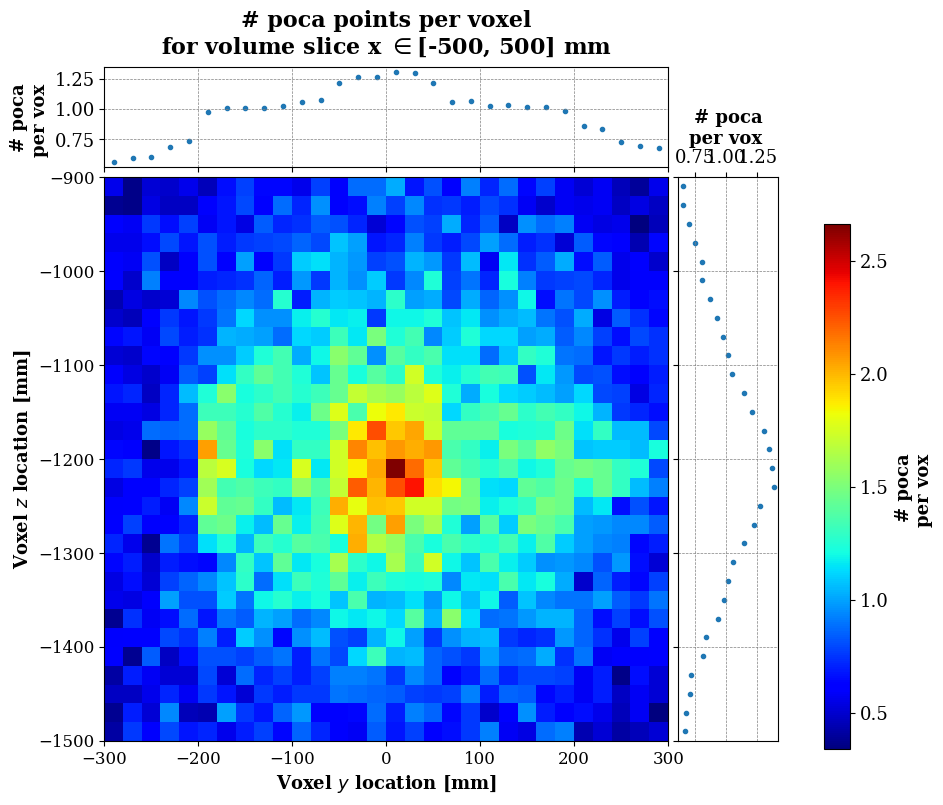

In [14]:
dim = 0

# Plot the predictions in the YZ plane
poca.plot_pred_slice(
    voi = voi, # The volume of interest
    xyz_voxel_preds=poca.n_poca_per_vox, # 3D prediction to plot
    dim = 0, # Projection, 0 == YZ projection
    filename = str(poca.output_dir) + "/no_dtheta_cut", # Where to save the plot
    voi_slice = (0, voi.n_vox_xyz[dim] - 1), # The range of voxels to consider
    fig_suptitle="# poca points per voxel", # Title of the figure
    pred_label = "# poca\nper vox",
    pred_unit = ""
)

Plot 3D scattering density predictions by slices as 2D projections.

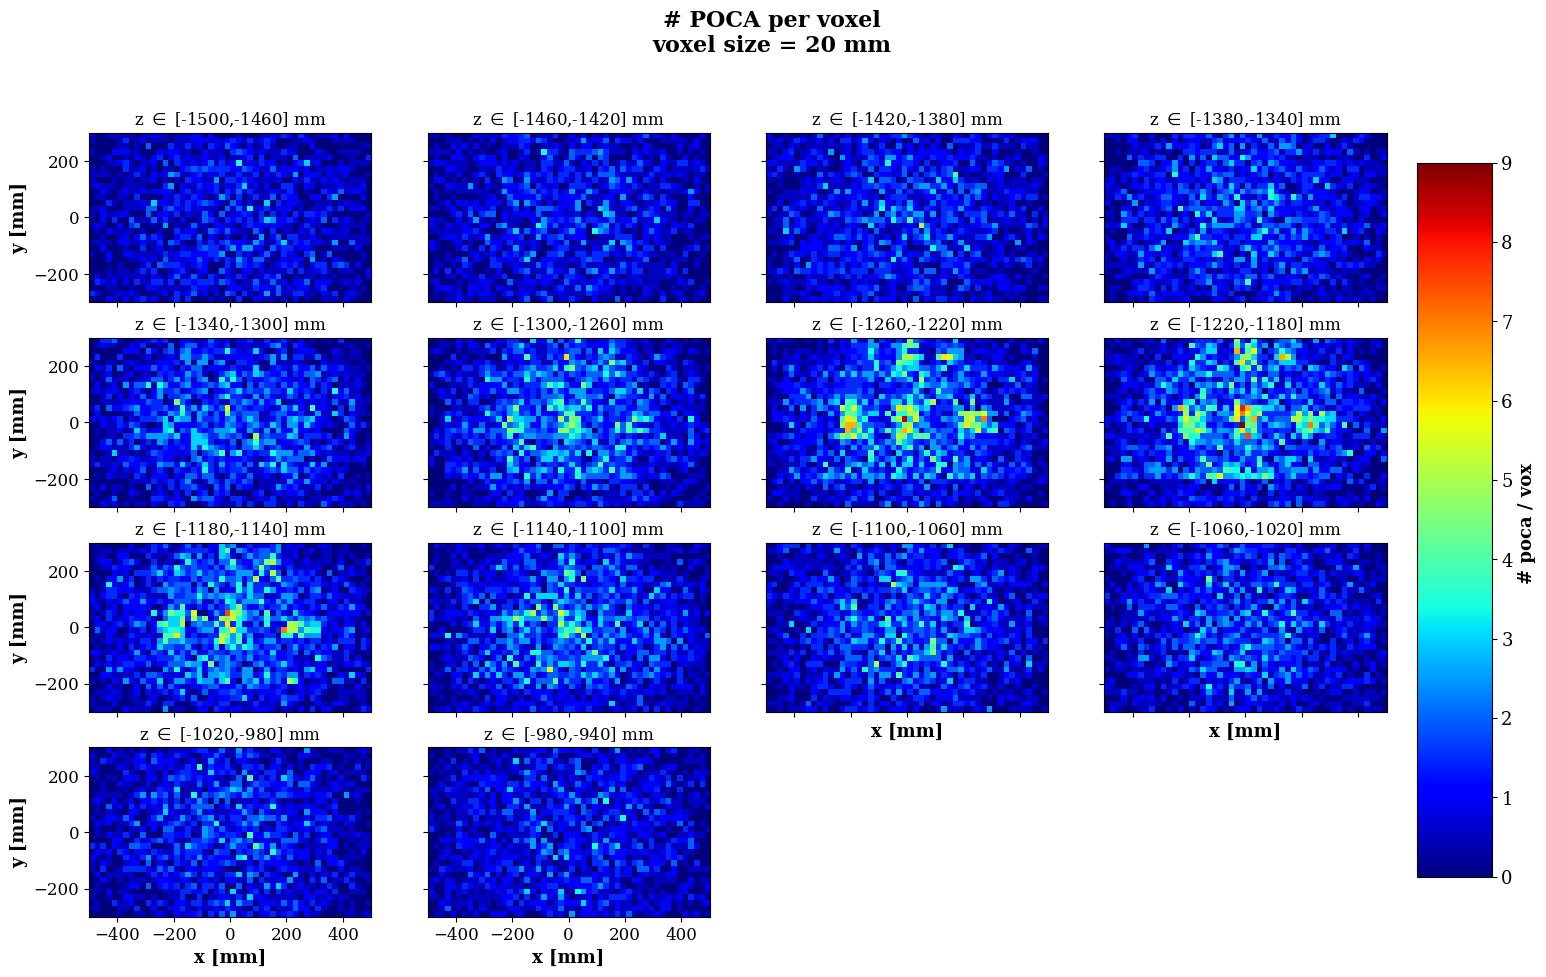

In [15]:
dim = 2 # XY view

poca.plot_pred_by_slice(
    voi = voi, # the volume of interest
    dim = dim, # Projection, 2 == XY projection
    xyz_voxel_preds=poca.n_poca_per_vox, # 3D prediction to plot
    voi_slice = (0, voi.n_vox_xyz[dim] - 2), # The range of voxels to consider
    ncols = 4, # The number of columns in the plot
    nslice_per_plot=2, # The number of voxel layer per plot
    filename = str(poca.output_dir) + "/no_dtheta_cut", # Where to save the plot
    fig_suptitle="# POCA per voxel",
    colorbar_label="# poca / vox",
)

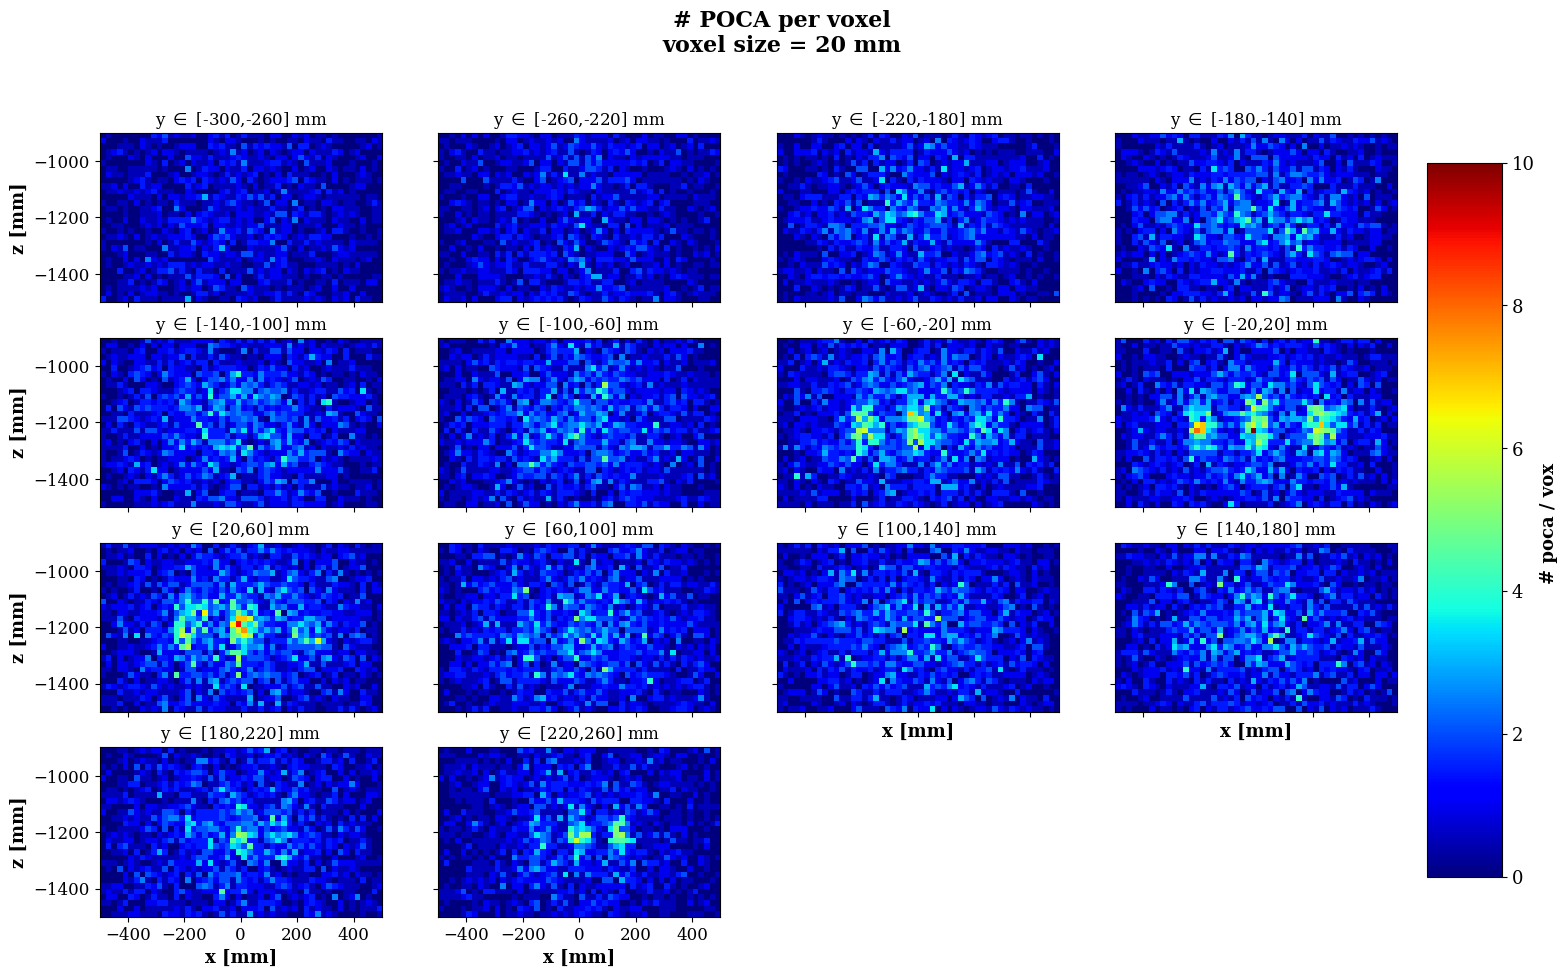

In [16]:
dim = 1 # XY view

poca.plot_pred_by_slice(
    voi = voi, # the volume of interest
    dim = dim,
    xyz_voxel_preds=poca.n_poca_per_vox, # 3D prediction to plot
    voi_slice = (0, voi.n_vox_xyz[dim] - 2), # The range of voxels to consider
    ncols = 4, # The number of columns in the plot
    nslice_per_plot=2, # The number of voxel layer per plot
    filename = str(poca.output_dir) + "/no_dtheta_cut", # Where to save the plot
    fig_suptitle="# POCA per voxel",
    colorbar_label="# poca / vox",
)

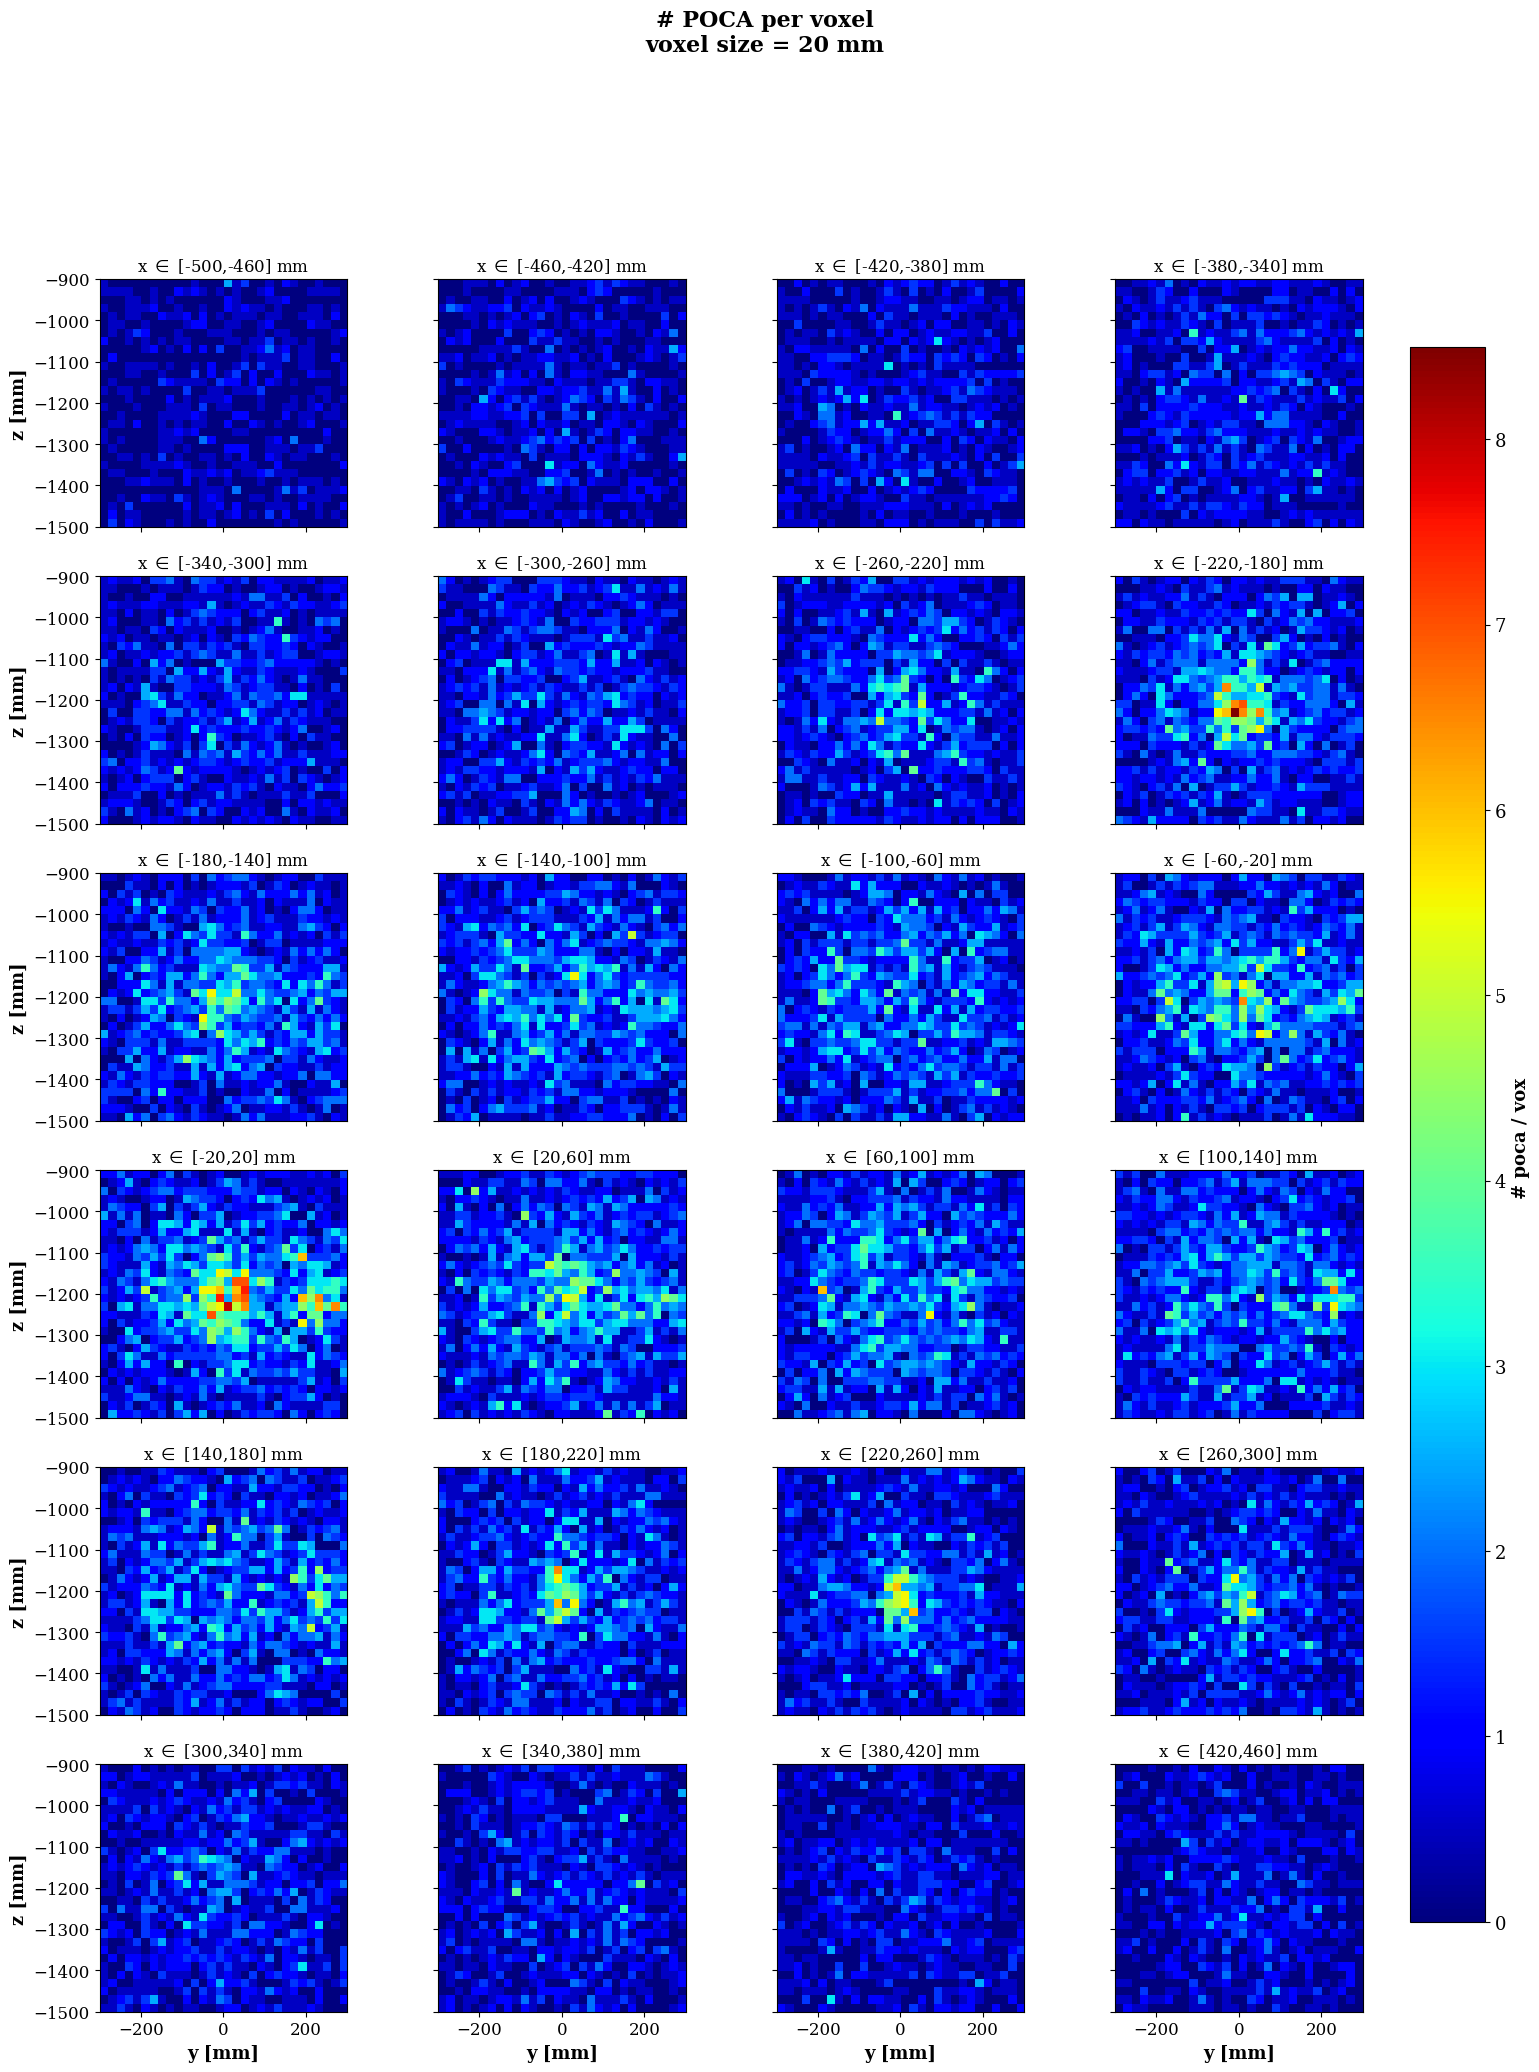

In [17]:
dim = 0 # XY view

poca.plot_pred_by_slice(
    voi = voi, # the volume of interest
    dim = dim,
    xyz_voxel_preds=poca.n_poca_per_vox, # 3D prediction to plot
    voi_slice = (0, voi.n_vox_xyz[dim] - 2), # The range of voxels to consider
    ncols = 4, # The number of columns in the plot
    nslice_per_plot=2, # The number of voxel layer per plot
    filename = str(poca.output_dir) + "/no_dtheta_cut", # Where to save the plot
    fig_suptitle="# POCA per voxel",
    colorbar_label="# poca / vox",
)

**Question**

Compare the scattering density predictions above with ones obtained in exercice 1.

## Noise reduction

A solution to reduce the noise in the scattering density map is to remove muons with small scattering angles.

In [18]:
# Choose a scattering angle threshold
dtheta_thresh = 1 

In [19]:
# Filter muons
mask = mst.dtheta > dtheta_thresh * math.pi / 180
mst._filter_muons(mask)

In [20]:
# Run POCA again

poca = POCA(
    tracking=mst, # The tracks
    voi = voi,# The volume of interest
    output_dir=output_dir + f"poca/{10*dtheta_thresh:.0f}_dtheta_cut/", # The path to the diretcory wherre to save the data
)


../../output/test1/poca/10_dtheta_cut directory already exists

Assigning voxel to each POCA point:


Class attributes saved at ../../output/test1/poca/10_dtheta_cut/poca.hdf5


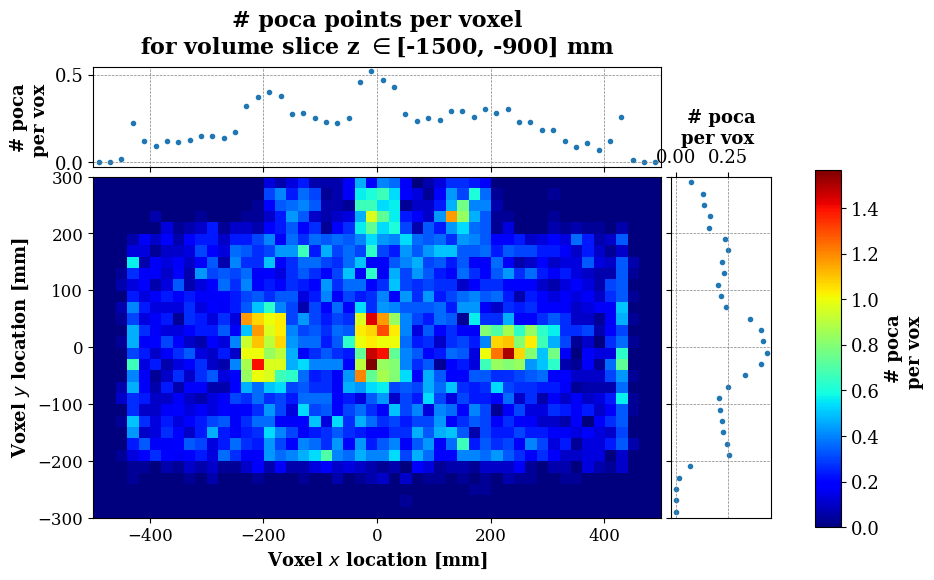

In [21]:
dim = 2

# Plot the predictions in the XY plane
poca.plot_pred_slice(
    voi = voi, # The volume of interest
    xyz_voxel_preds=poca.n_poca_per_vox, # 3D prediction to plot
    dim = dim, # Projection, 2 == XY projection
    filename = str(poca.output_dir) + "/n_poca", # Where to save the plot
    voi_slice = (0, voi.n_vox_xyz[dim] - 1), # The range of voxels to consider
    fig_suptitle="# poca points per voxel", # Title of the figure
    pred_label = "# poca\nper vox",
    pred_unit = ""
)

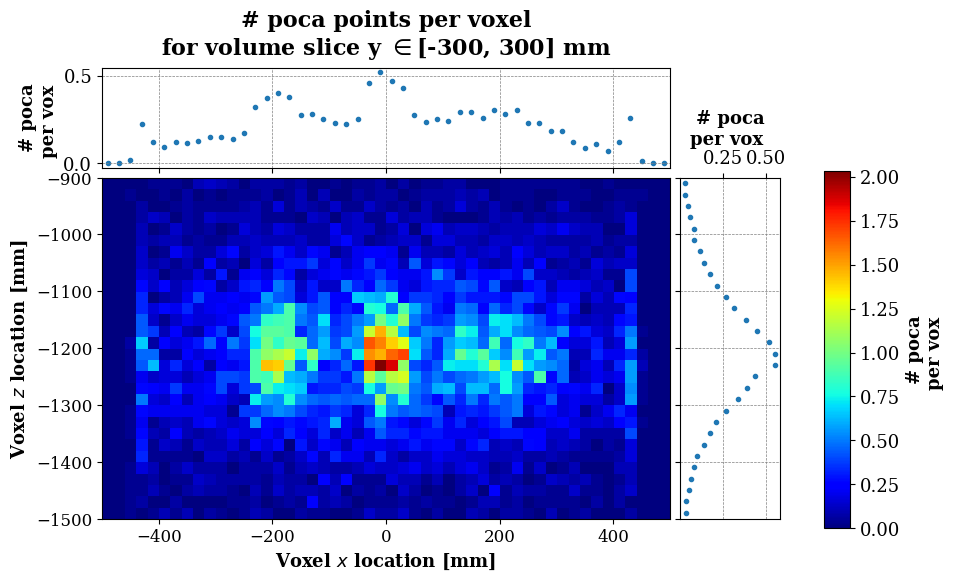

In [22]:
dim = 1

# Plot the predictions in the XY plane
poca.plot_pred_slice(
    voi = voi, # The volume of interest
    xyz_voxel_preds=poca.n_poca_per_vox, # 3D prediction to plot
    dim = dim, # Projection, 2 == XY projection
    filename = str(poca.output_dir) + "/n_poca", # Where to save the plot
    voi_slice = (0, voi.n_vox_xyz[dim] - 1), # The range of voxels to consider
    fig_suptitle="# poca points per voxel", # Title of the figure
    pred_label = "# poca\nper vox",
    pred_unit = ""
)

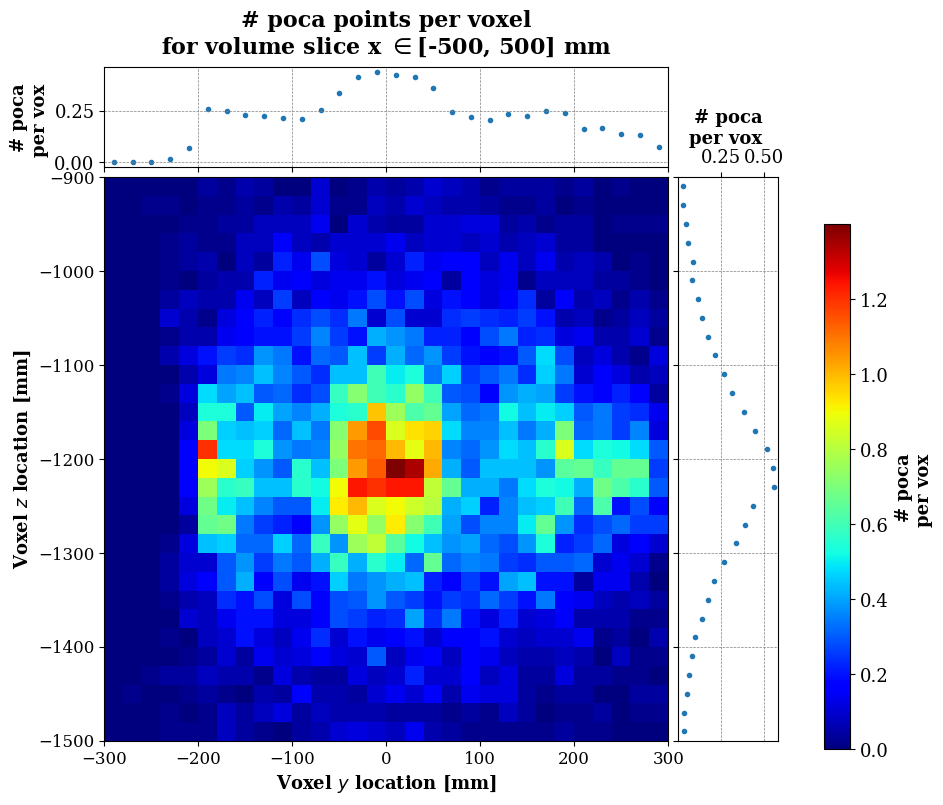

In [23]:
dim = 0

poca.plot_pred_slice(
    voi = voi, # The volume of interest
    xyz_voxel_preds=poca.n_poca_per_vox, # 3D prediction to plot
    dim = dim, # Projection, 2 == XY projection
    filename = str(poca.output_dir) + "/n_poca", # Where to save the plot
    voi_slice = (0, voi.n_vox_xyz[dim] - 1), # The range of voxels to consider
    fig_suptitle="# poca points per voxel", # Title of the figure
    pred_label = "# poca\nper vox",
    pred_unit = ""
)

**Question**

1 - Compare the scattering density predictions abovve with theones obttained witheout applying any cut.


2 - As usual in experimental physics, we would like to reach the optimal signal to noise ratio. Find the optimal value of the cut on the scattering angle.


***Help***: By producing scattering density plots obtained for various cuts on `dtheta`, one can get an idea of which values are suitable.

Below is an example of a function that can produce plots for various value of `dtheta` cut: 

In [24]:
from typing import List, Optional
from pathlib import Path
from copy import deepcopy

def dtheta_cut_scan(
        dtheta_values: List[float], 
        mst: TrackingMST, 
        directory: Optional[str] = None) -> None:

    from utils.tools import apply_gaussian_filter
    from utils.save import AbsSave


    # Loop over kernel sizes
    for dtheta_value in dtheta_values:

        # Create directory to sae the plots
        directory = (str(poca.output_dir) + "/dtheta_cut_scan/") if directory is None else directory
        AbsSave.create_directory(Path(directory))

        # Plot name 
        plot_name = f"{10 * dtheta_value:.0f}_dtheta_cut_poca_preds"

        # Filter muons
        mst_local = deepcopy(mst)
        mst_local._filter_muons(mst_local.dtheta > dtheta_value)

        # Plot the predictions using your favorite plotting methods
        for dim in (0, 1, 2):
            poca.plot_pred_by_slice(
                voi = voi, # the volume of interest
                dim = dim, # Projection
                xyz_voxel_preds=poca.n_poca_per_vox, # 3D prediction to plot
                voi_slice = (0, voi.n_vox_xyz[dim] - 2), # The range of voxels to consider
                ncols = 4, # The number of columns in the plot
                nslice_per_plot=2, # The number of voxel layer per plot
                filename = directory + plot_name + "sliced", # Where to save the plot
                fig_suptitle="# POCA per voxel",
                colorbar_label="# poca / vox",
            )

            poca.plot_pred_slice(
                voi = voi, # The volume of interest
                xyz_voxel_preds=poca.n_poca_per_vox, # 3D prediction to plot
                dim = dim, # Projection
                filename = directory + plot_name, # Where to save the plot
                voi_slice = (0, voi.n_vox_xyz[dim] - 1), # The range of voxels to consider
                fig_suptitle="# poca points per voxel", # Title of the figure
                pred_label = "# poca\nper vox",
                pred_unit = ""
            )

In [25]:
dtheta_values = np.linspace(0.1, 2, 20)
dtheta_values

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. ])

In [26]:
poca.output_dir

PosixPath('../../output/test1/poca/10_dtheta_cut')


../../output/test1/poca/dtheta_cut_scan directory created


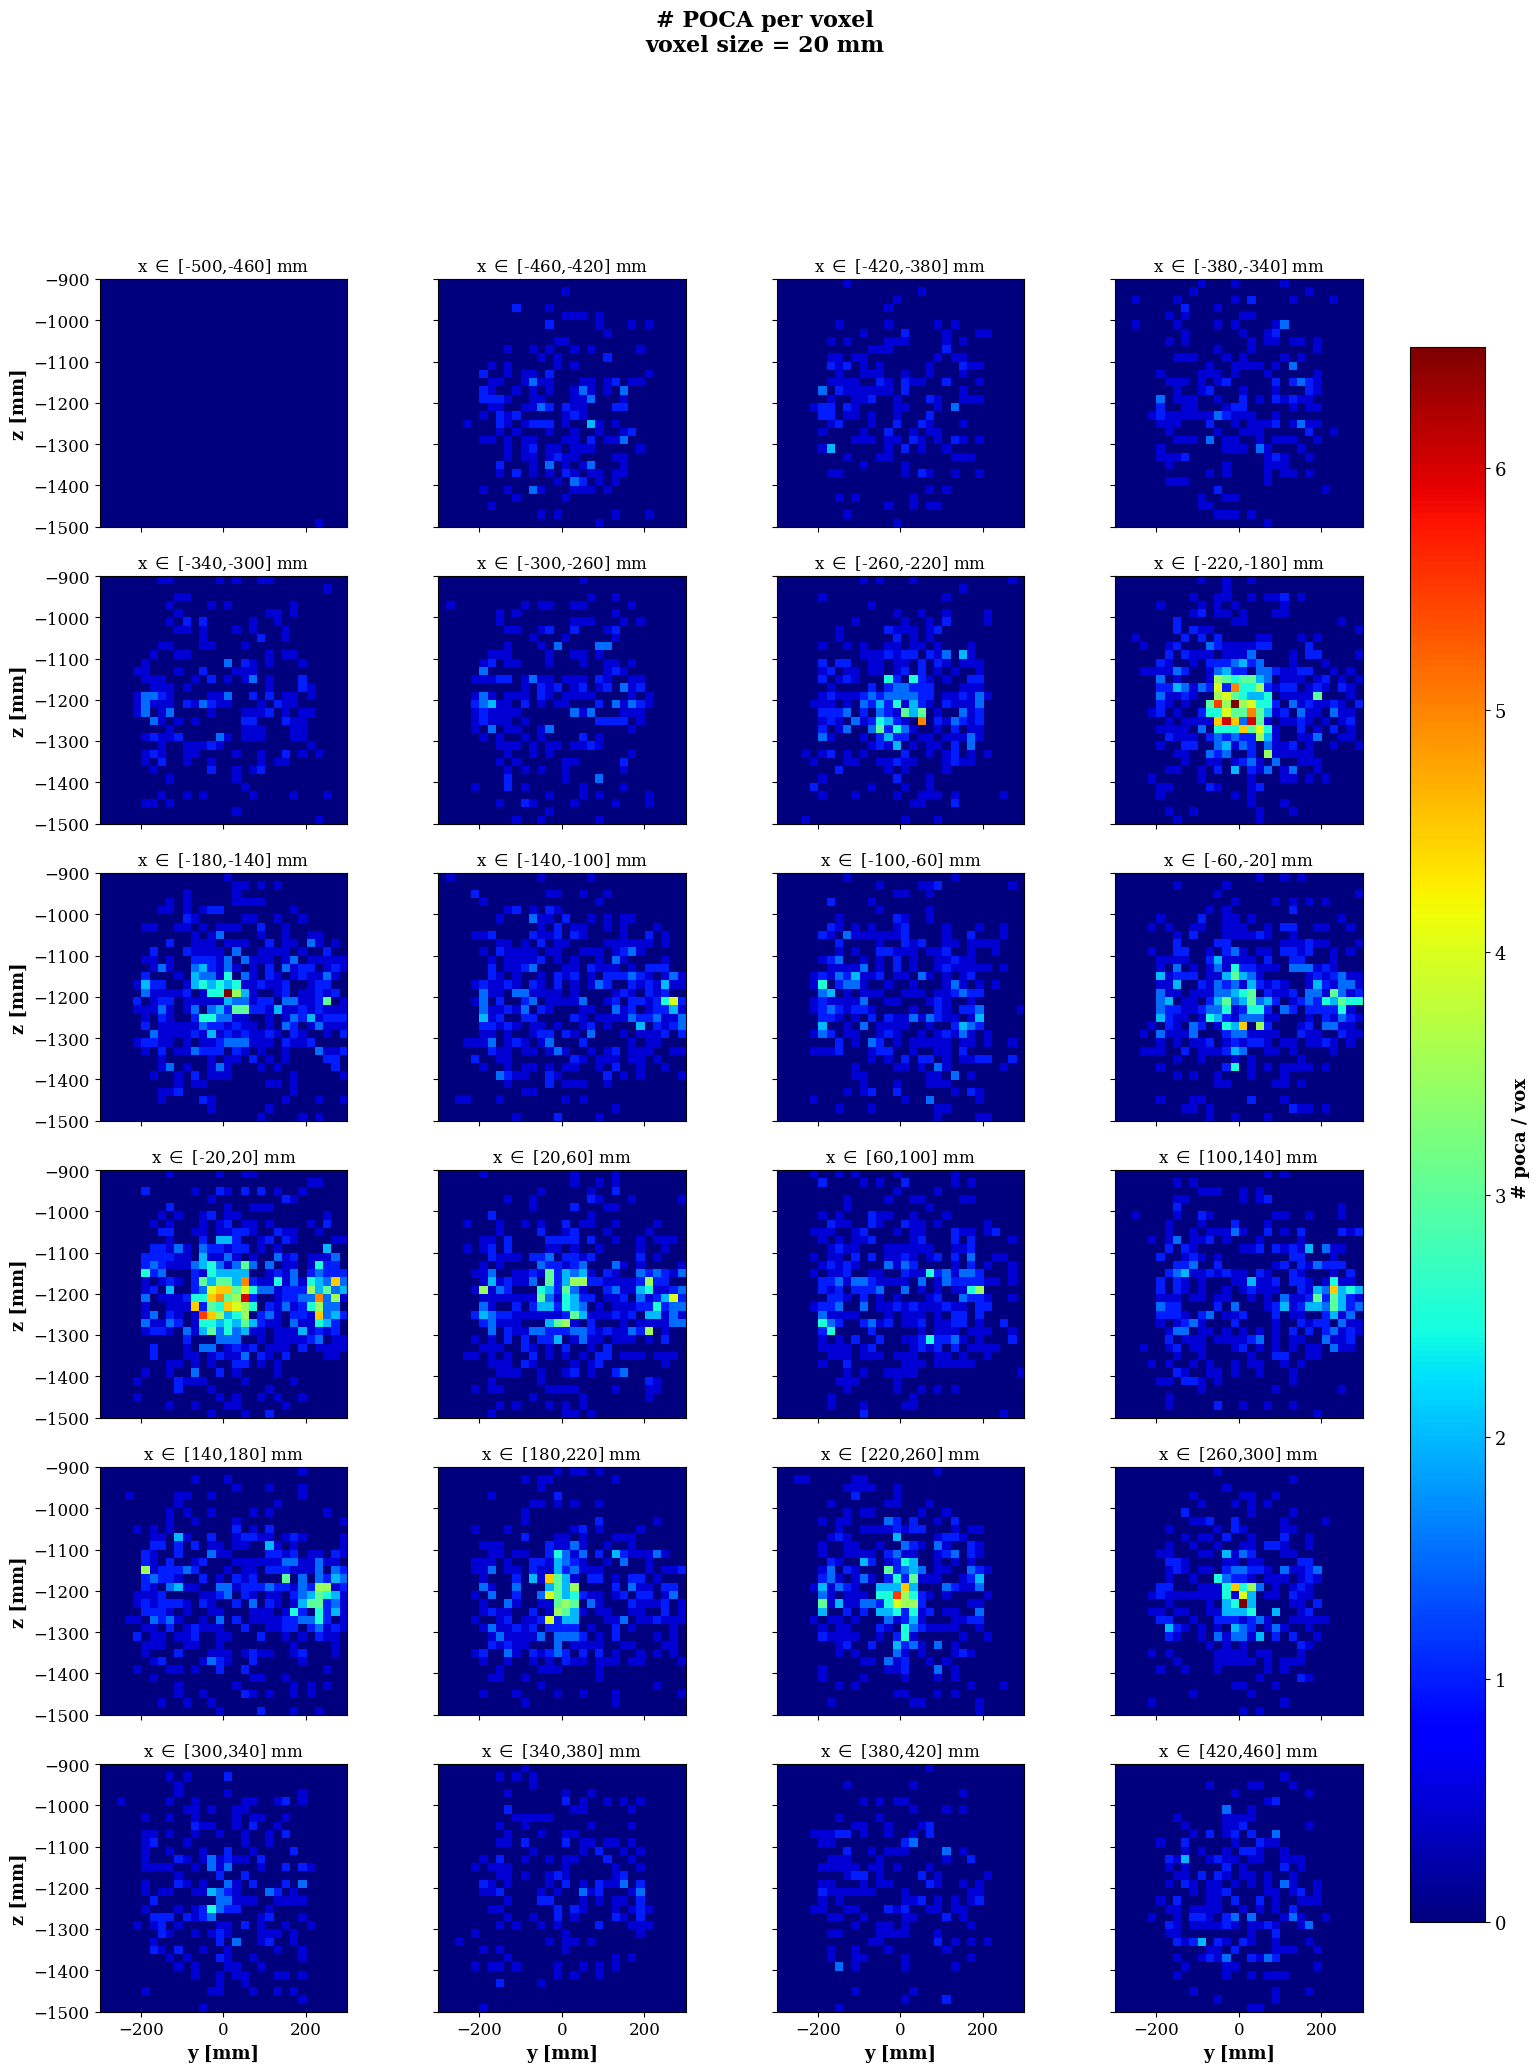

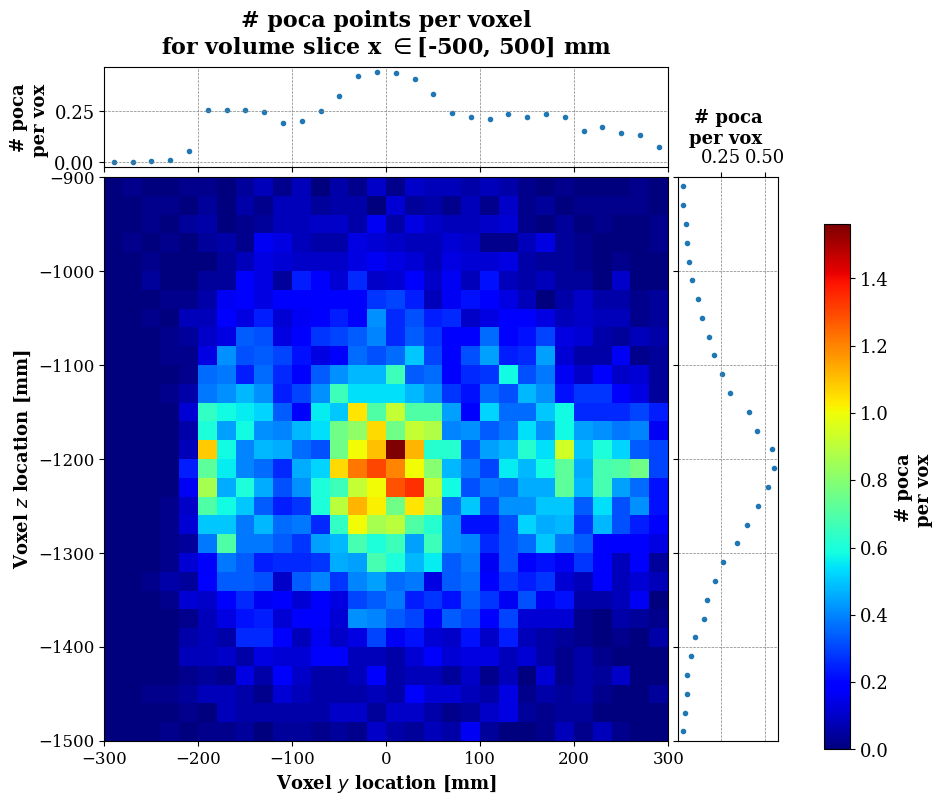

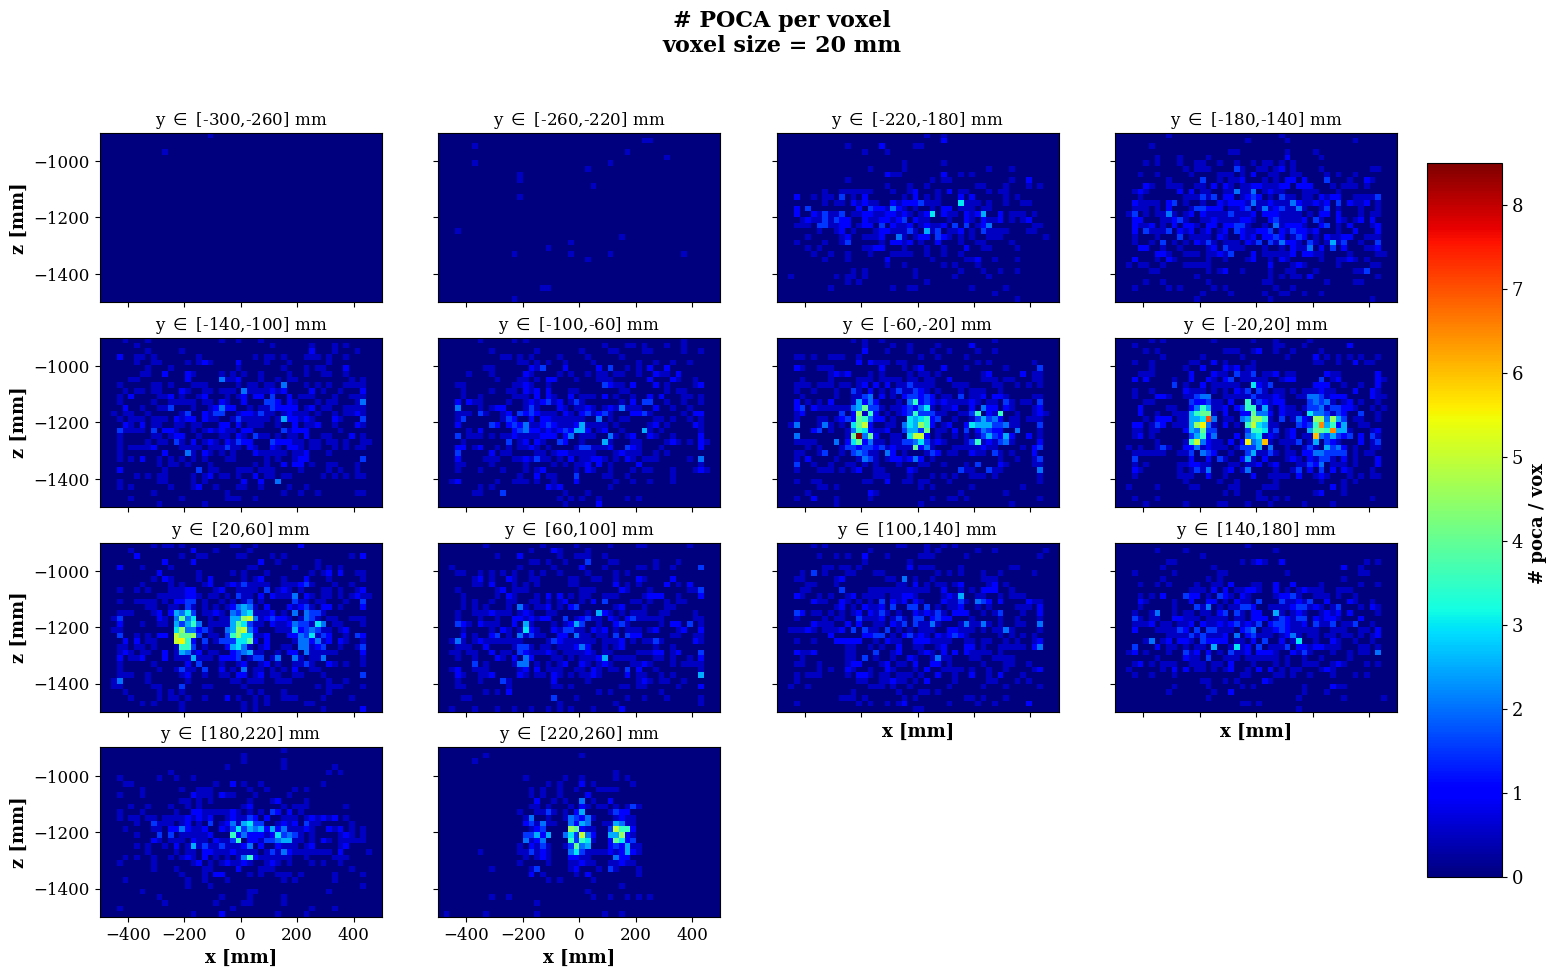

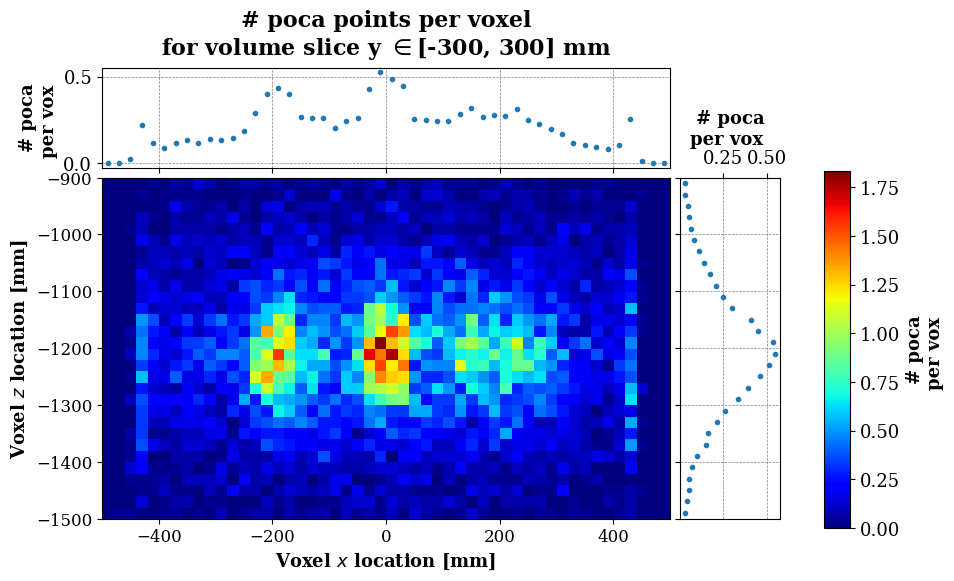

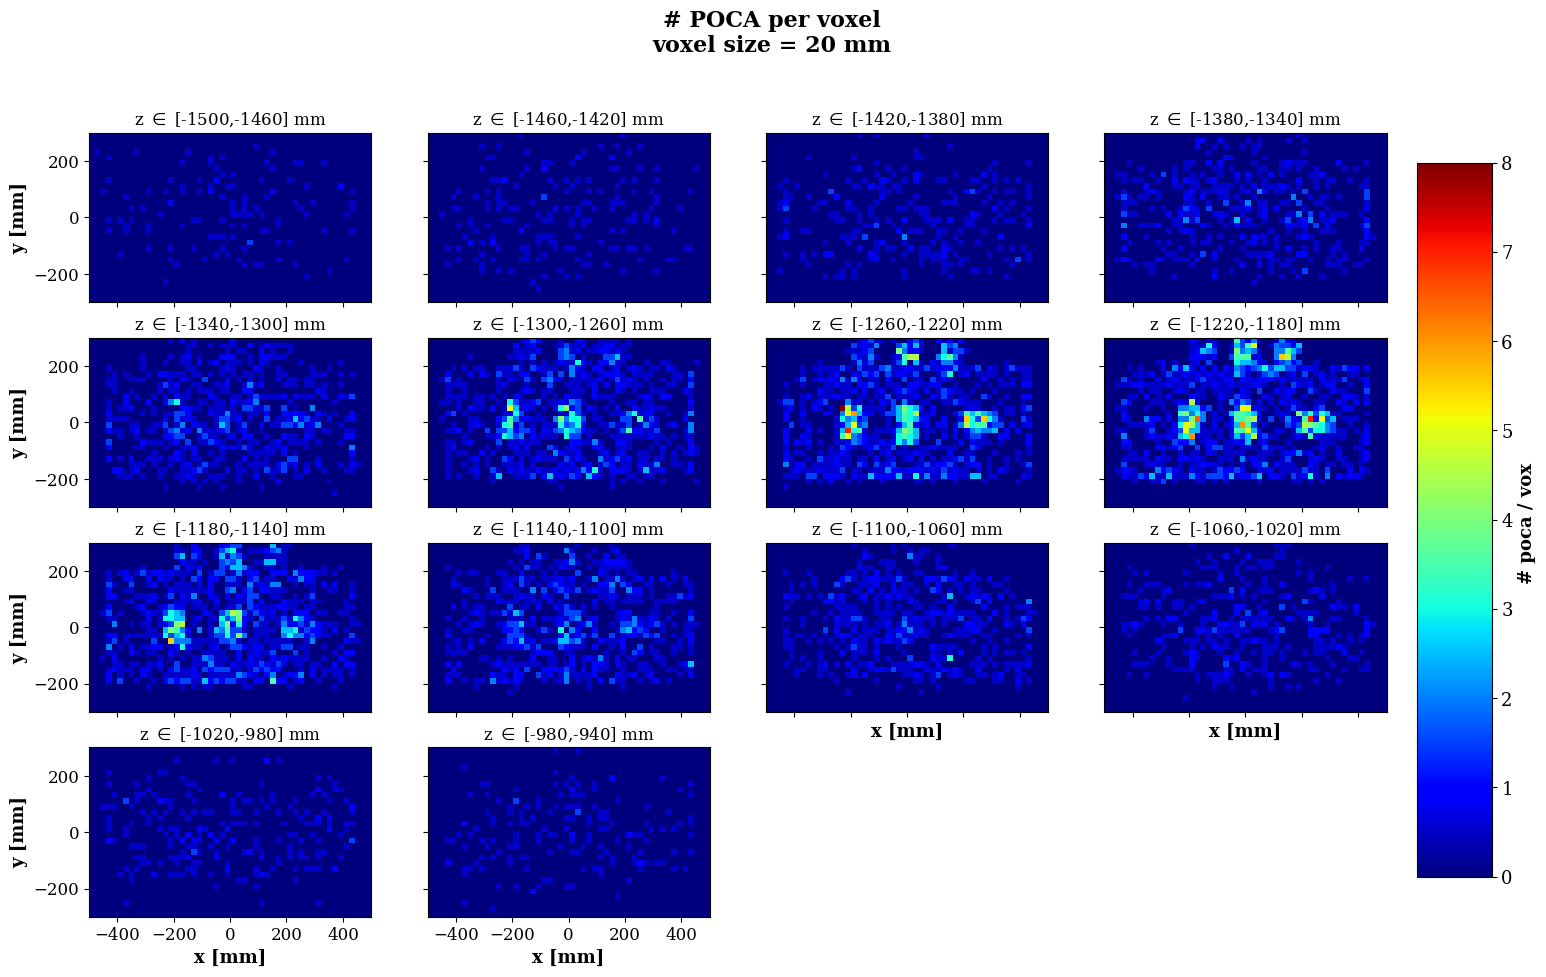

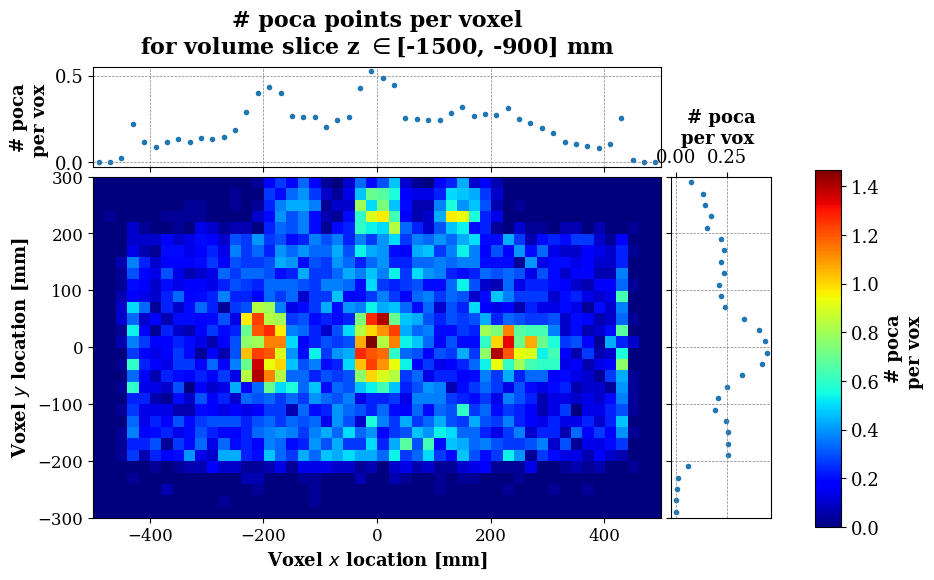


../../output/test1/poca/dtheta_cut_scan directory already exists


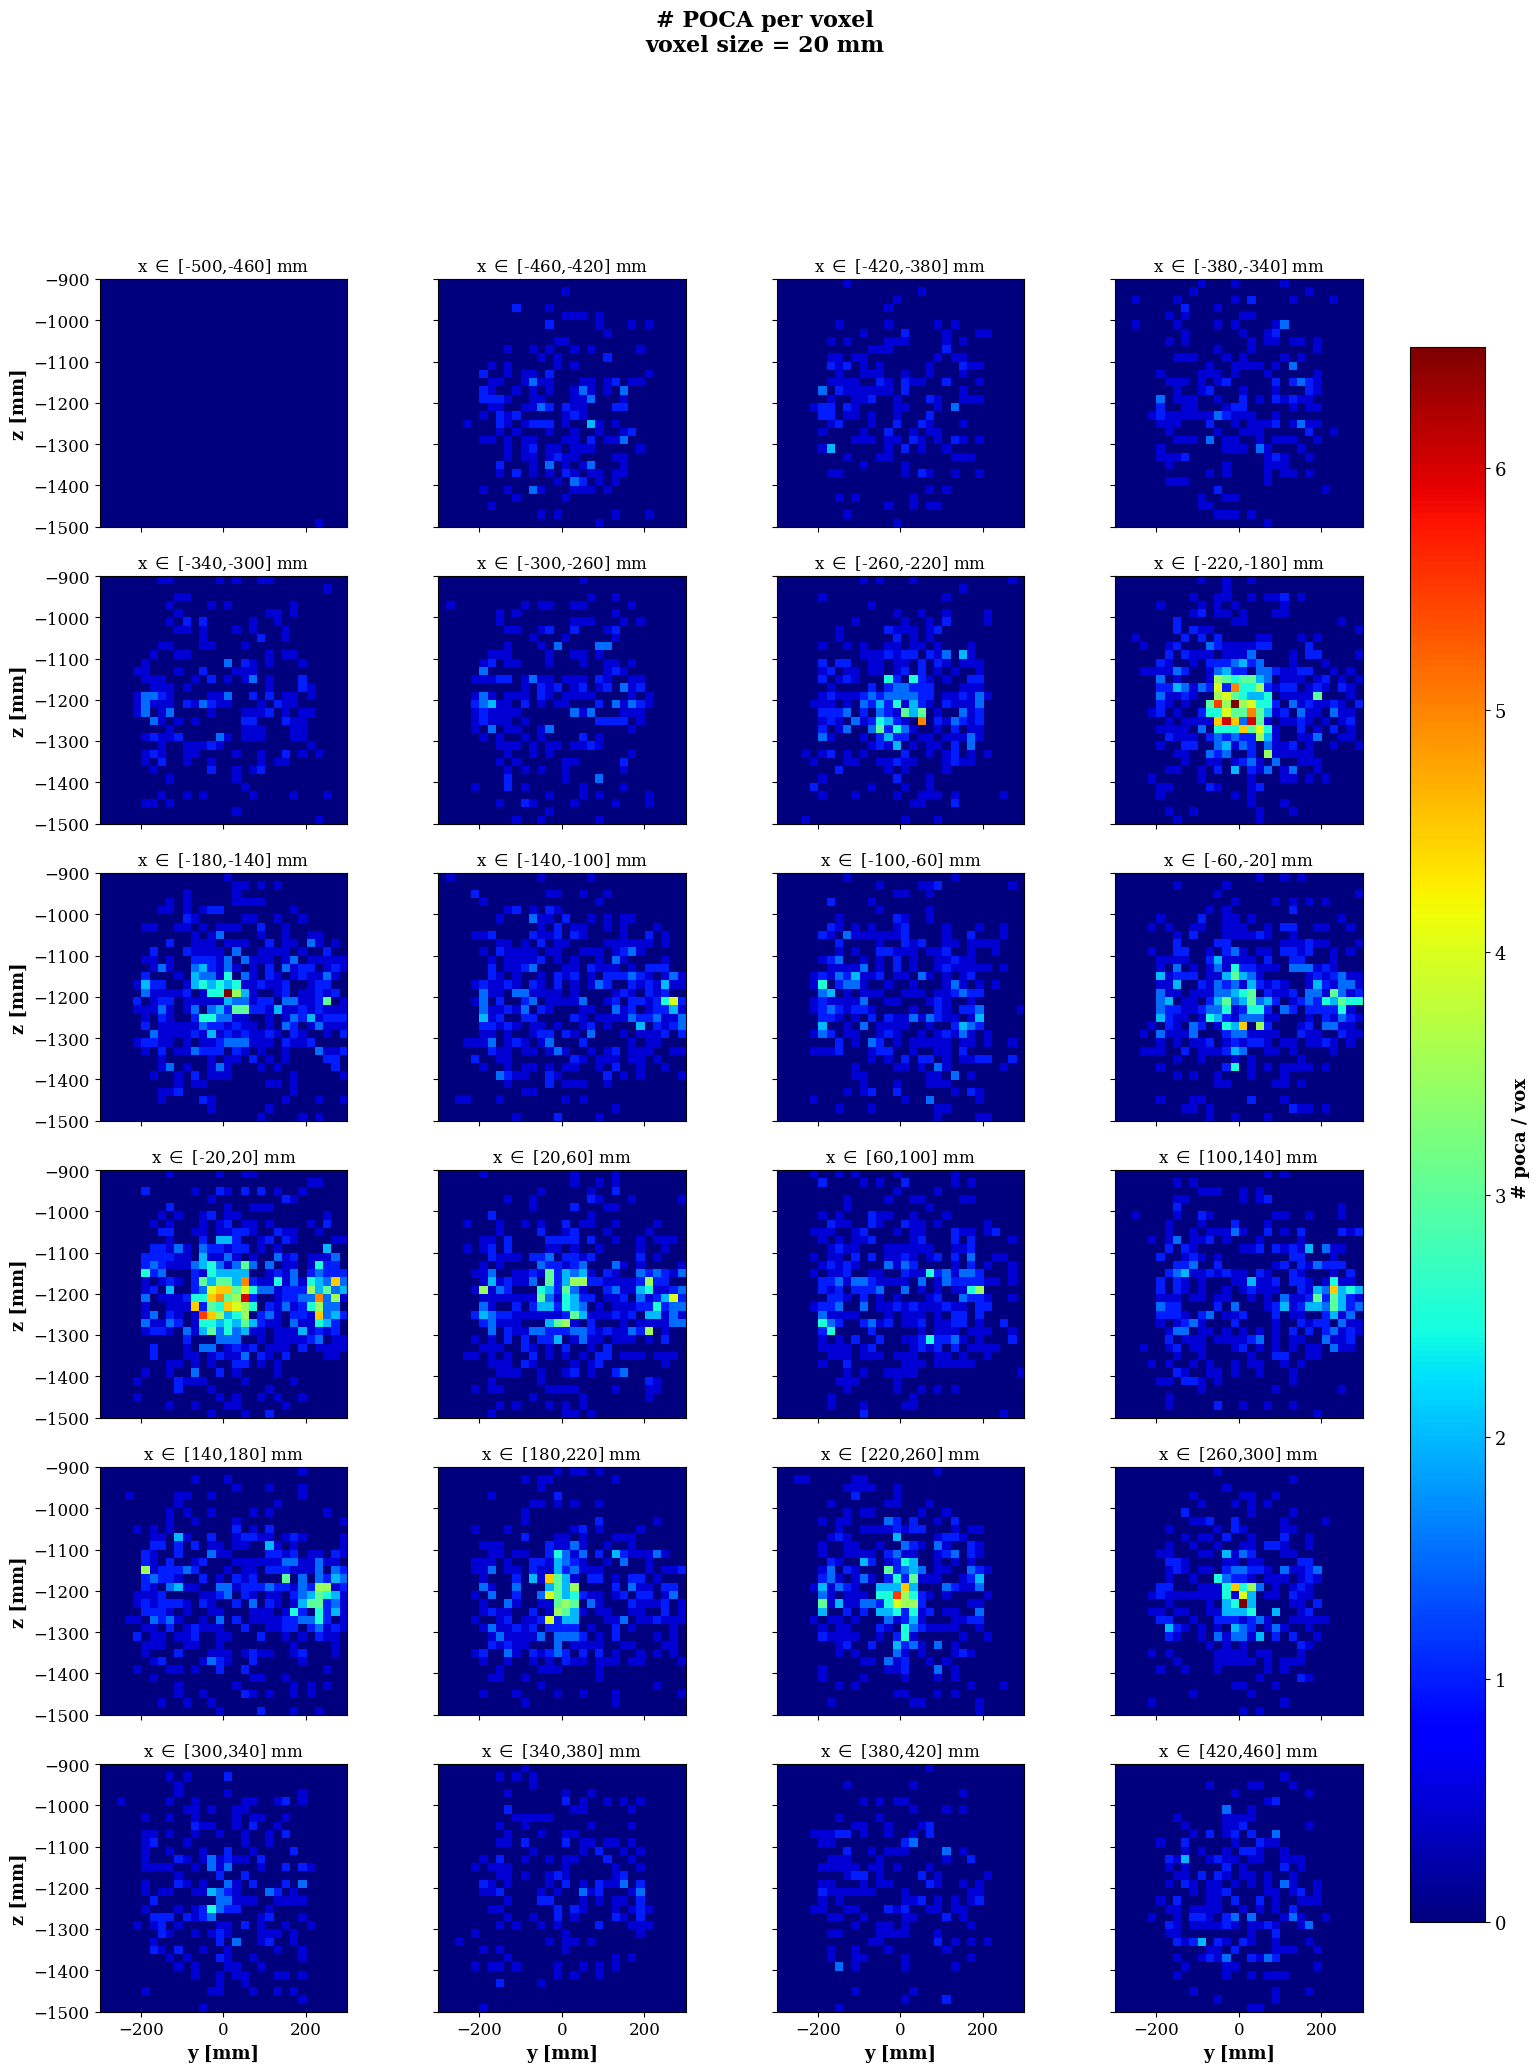

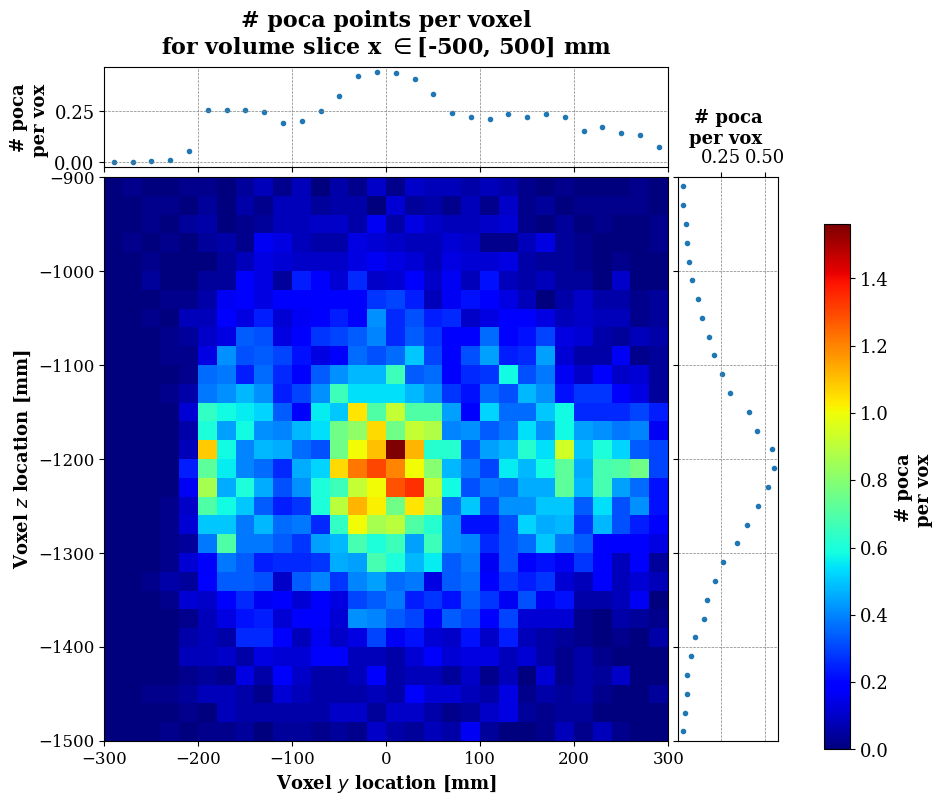

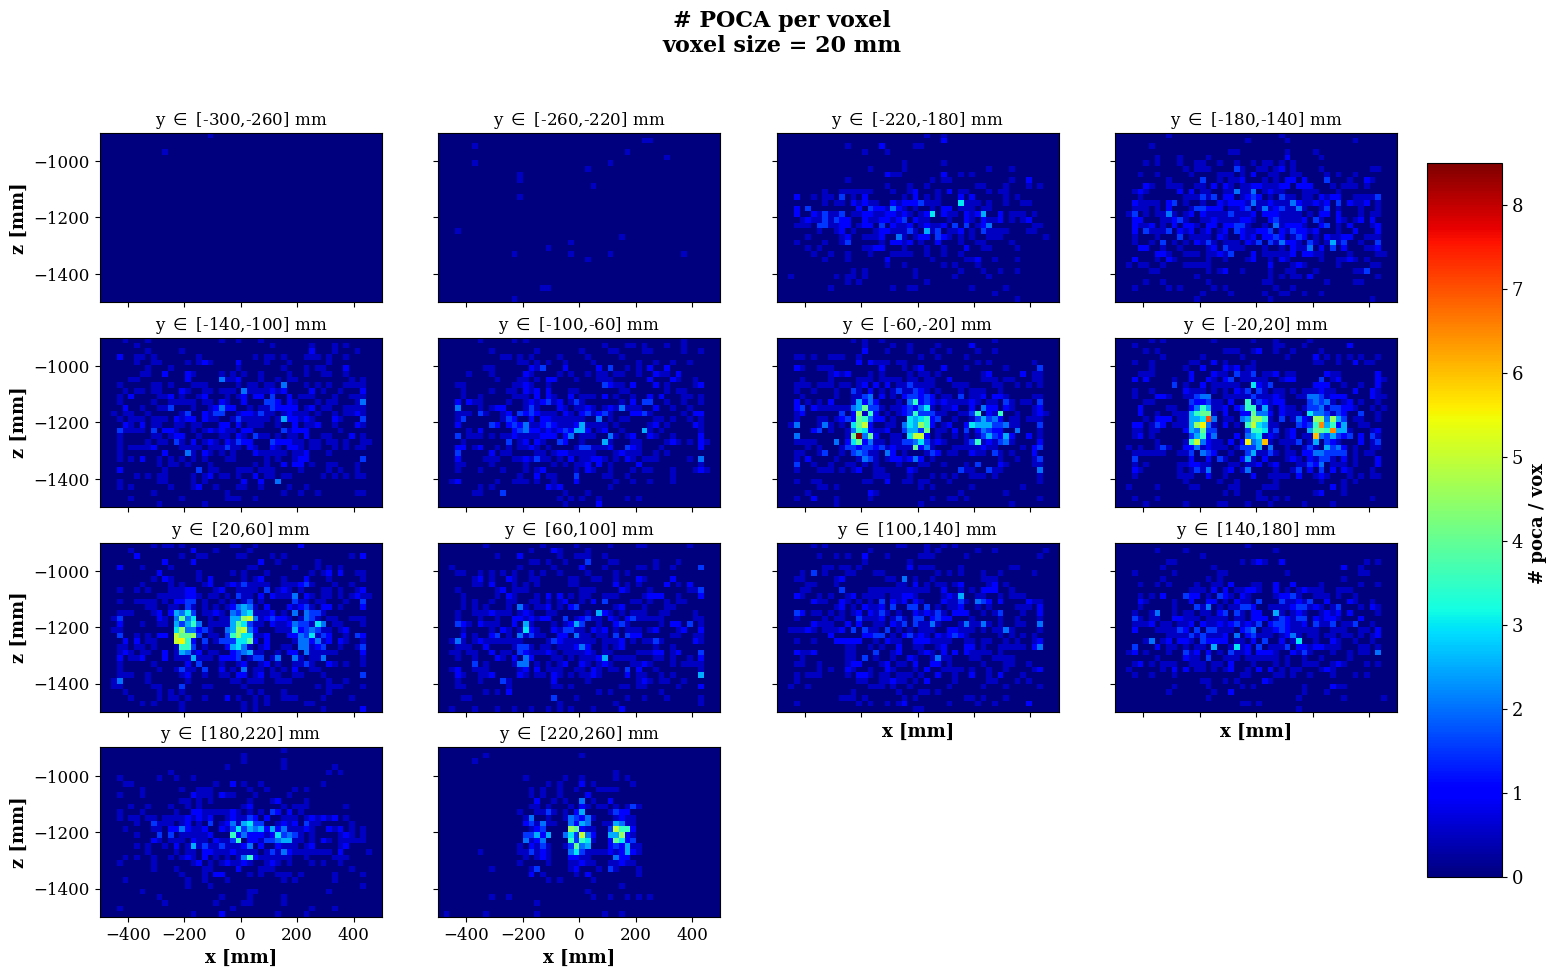

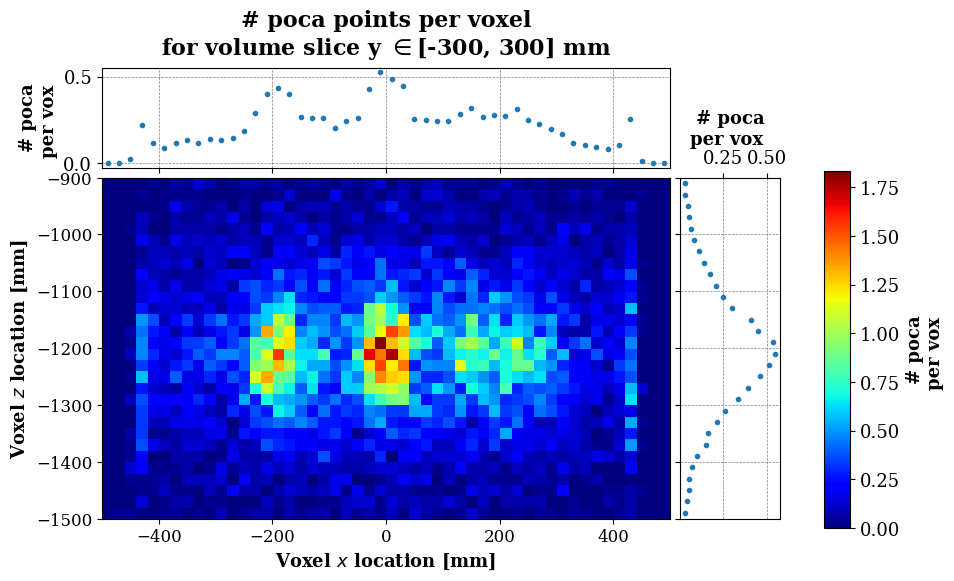

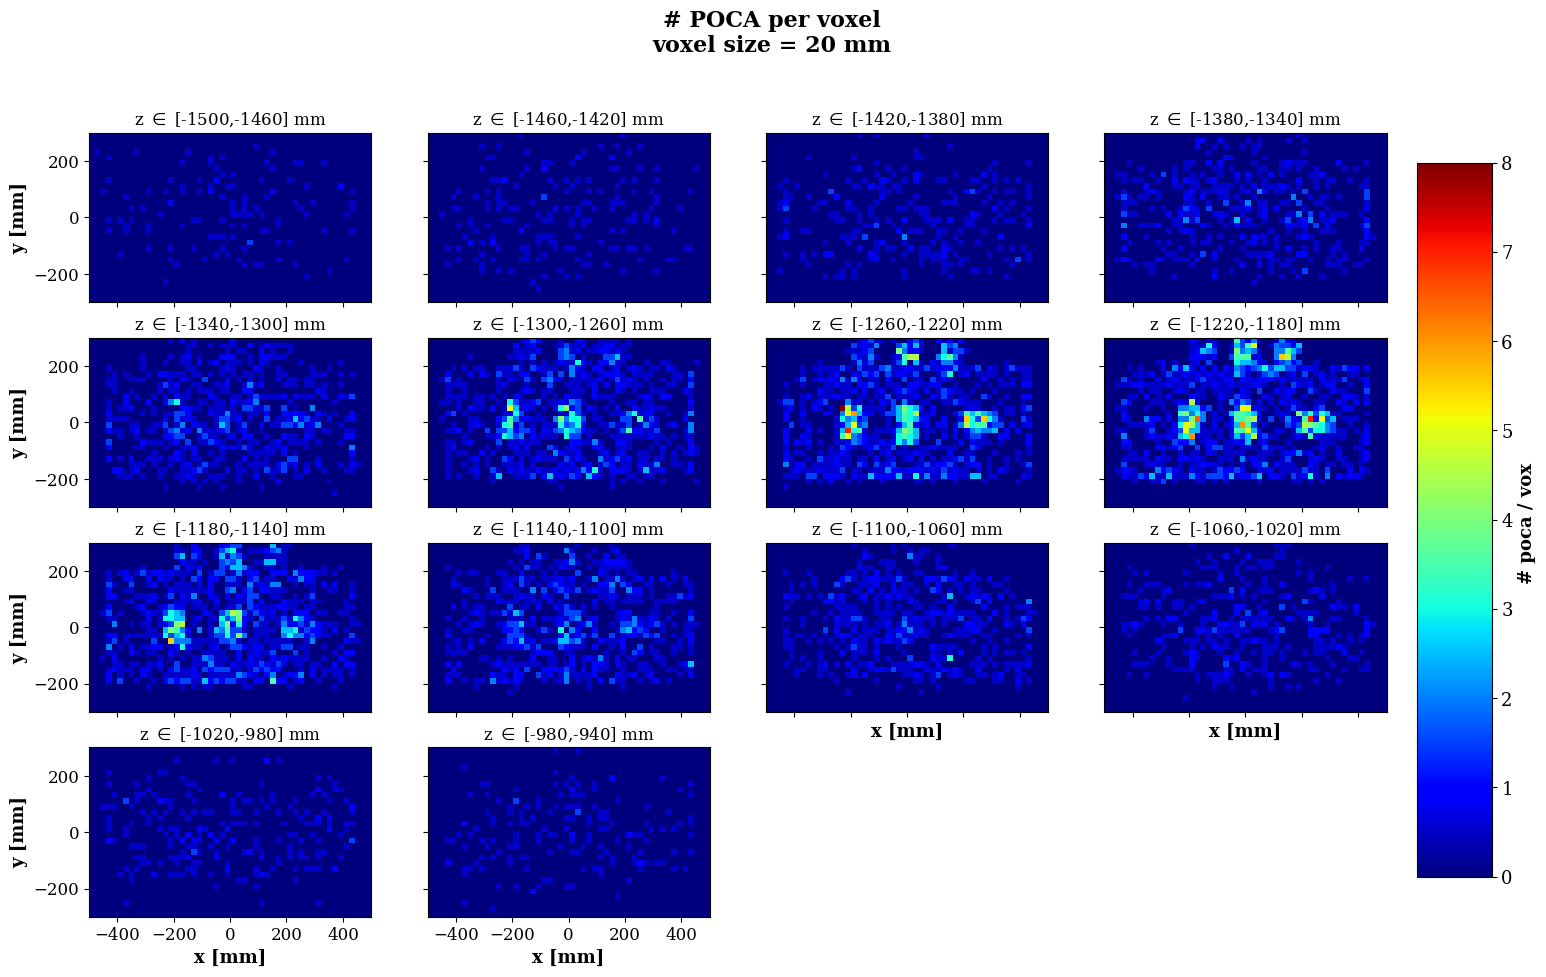

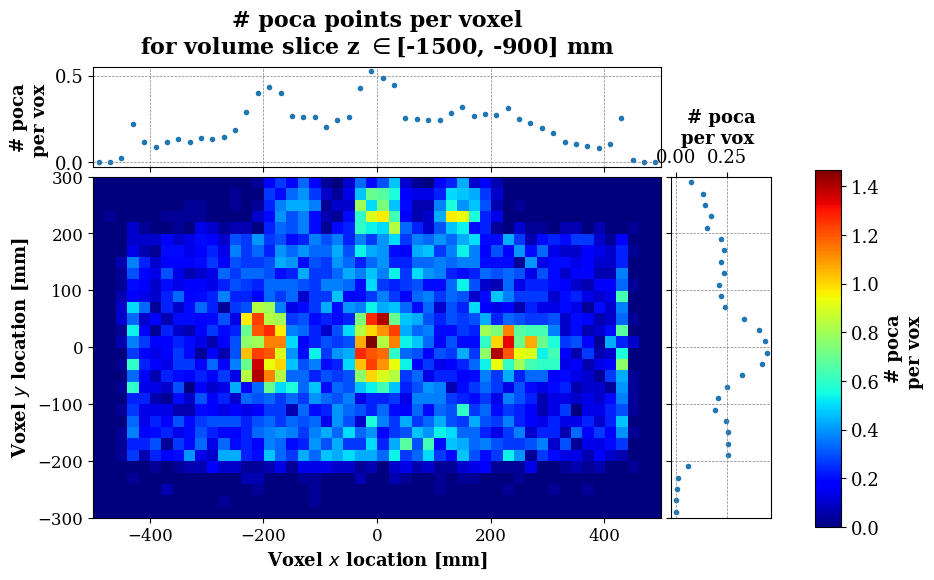


../../output/test1/poca/dtheta_cut_scan directory already exists


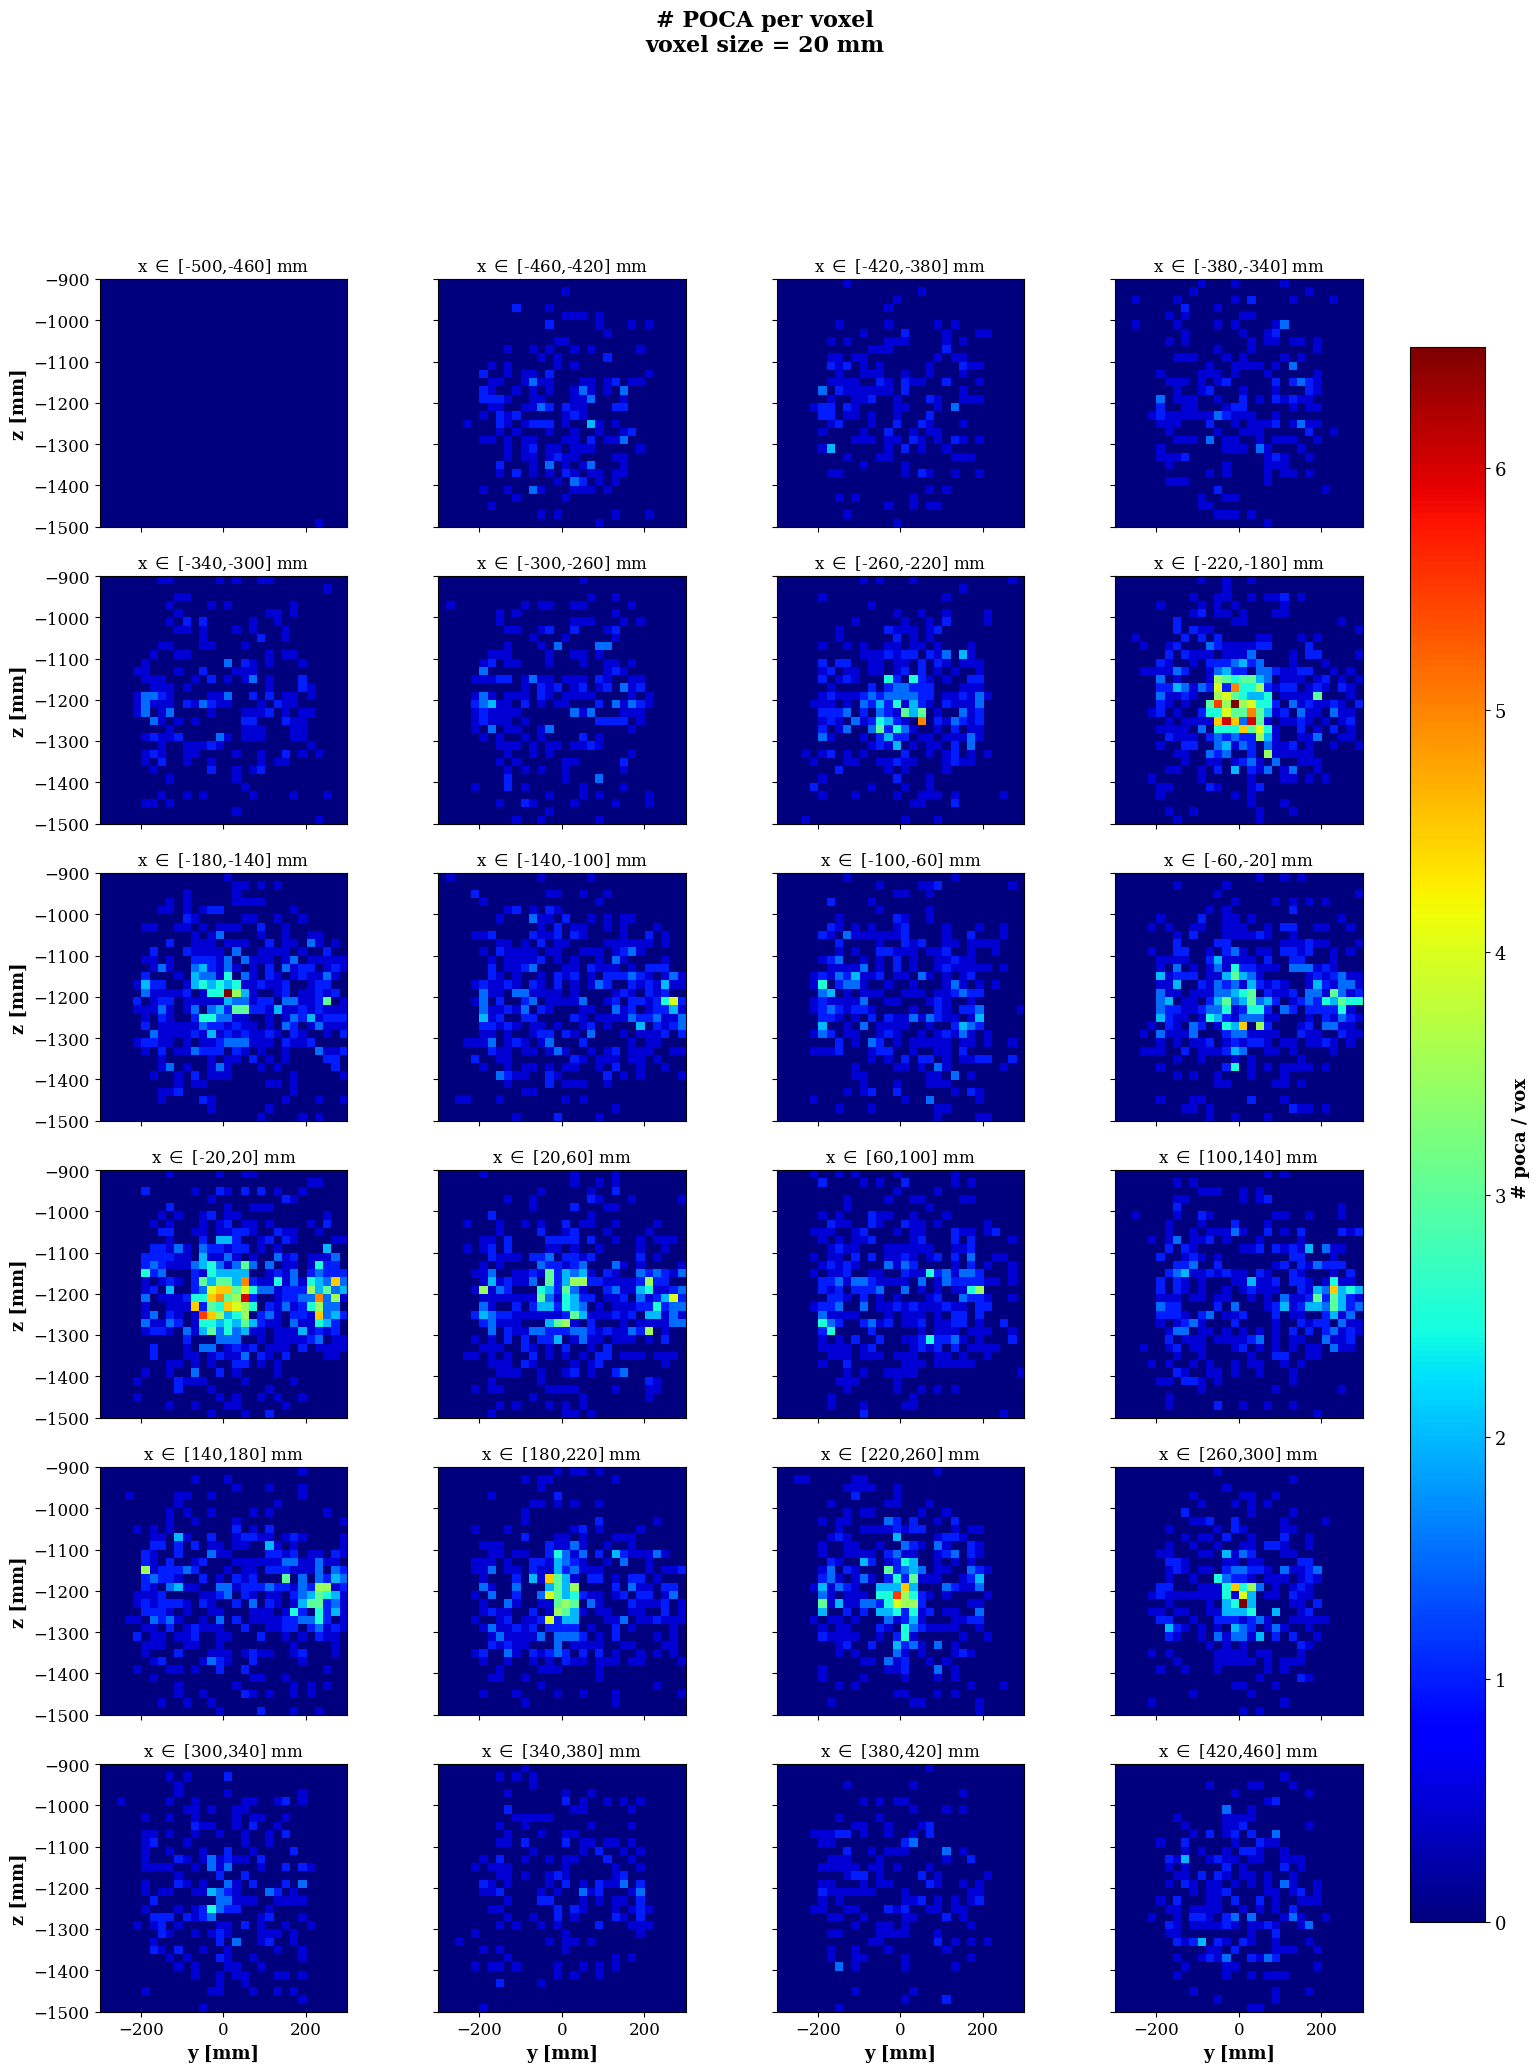

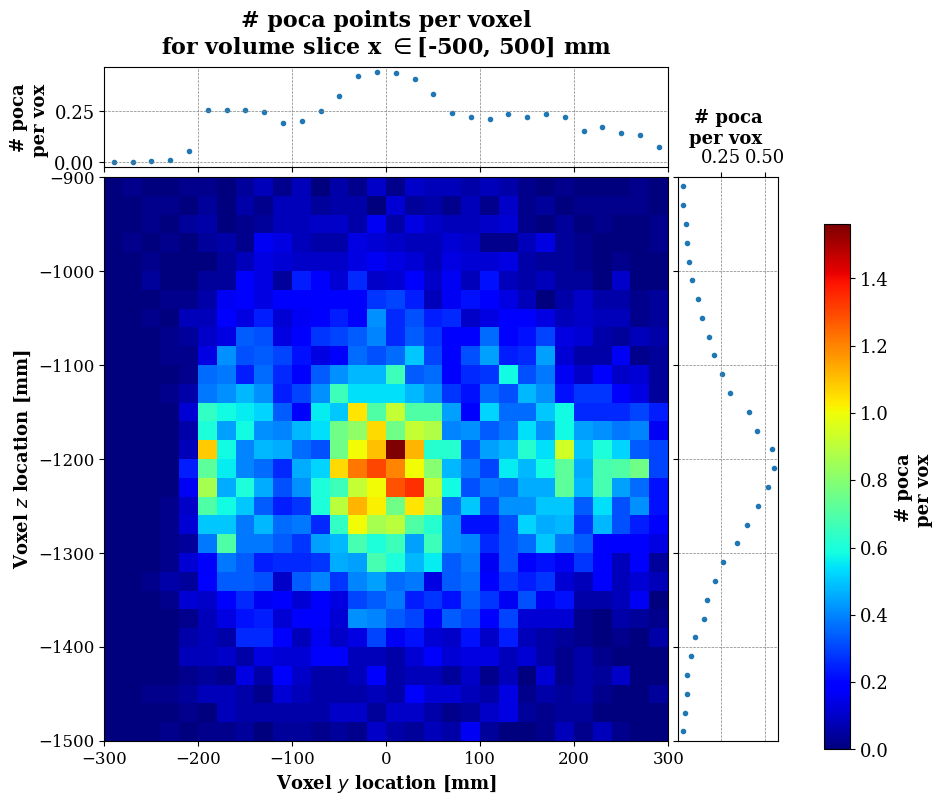

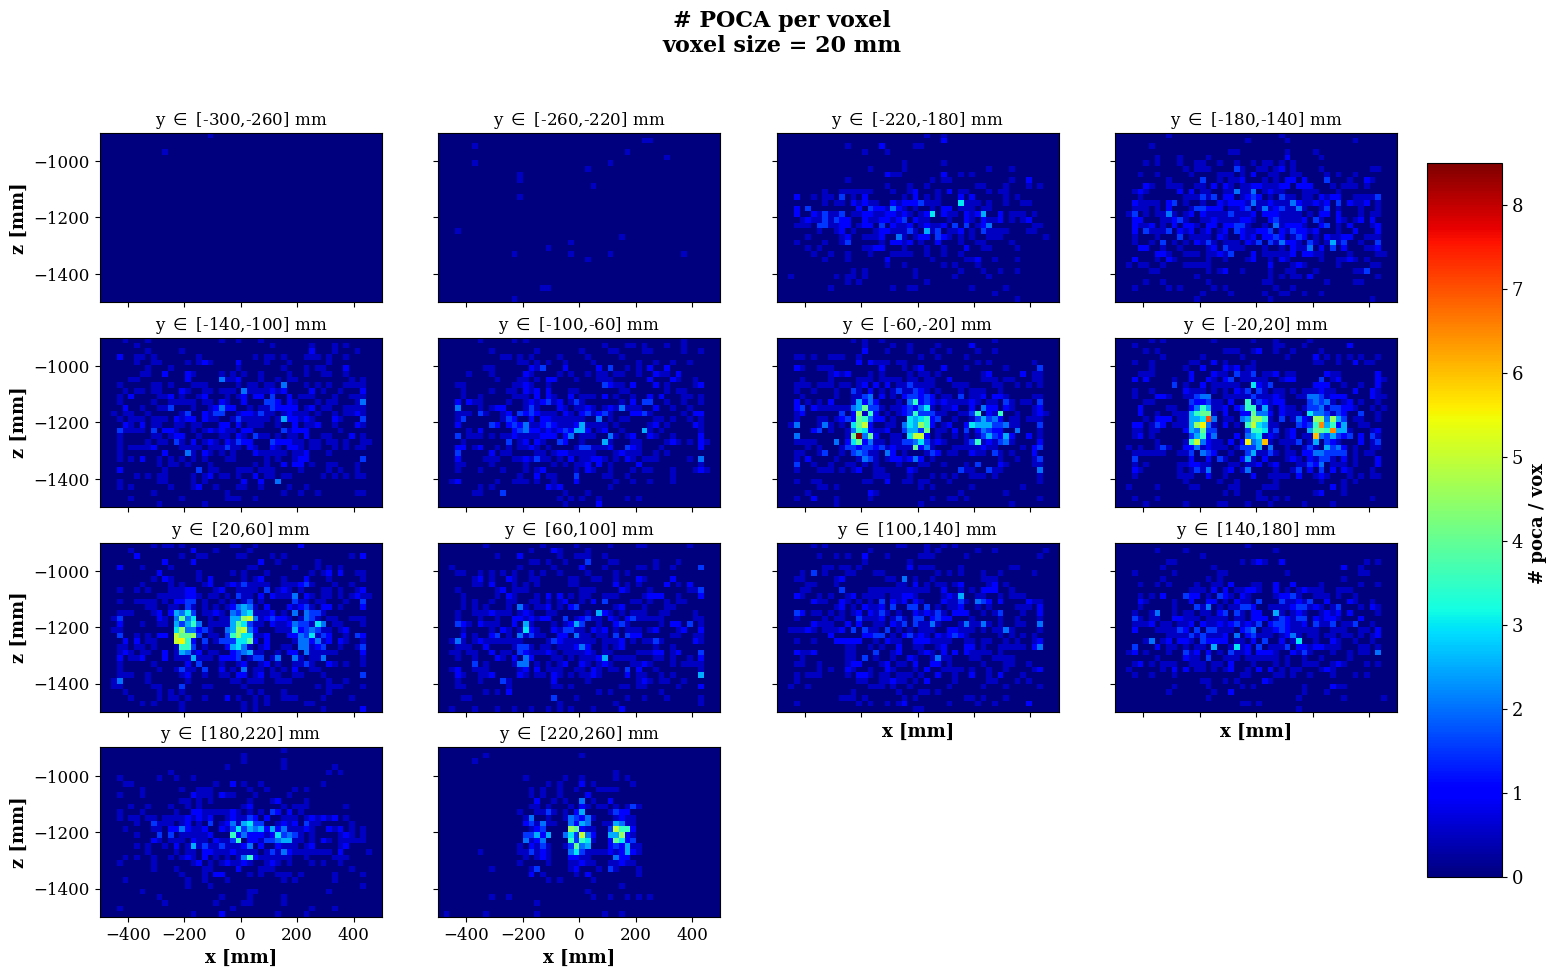

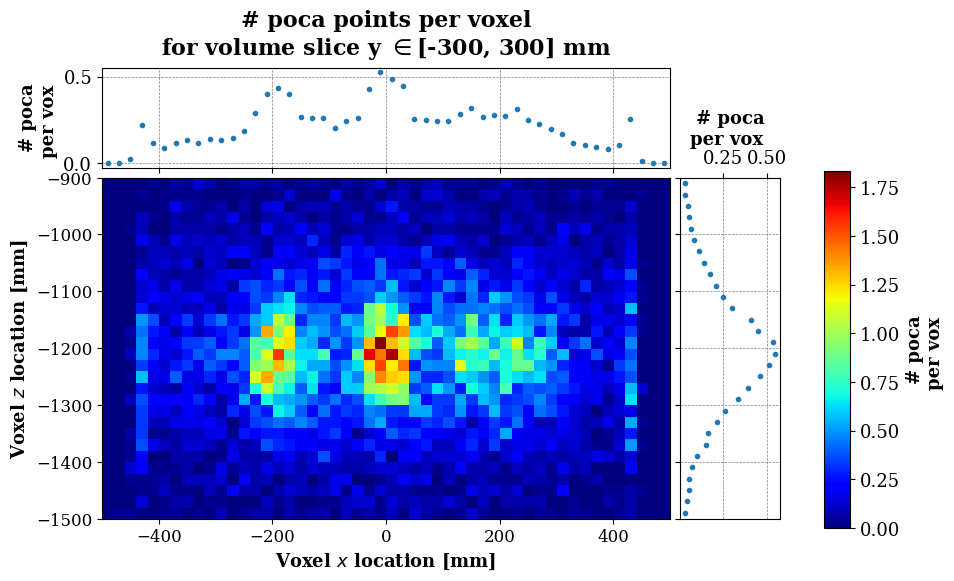

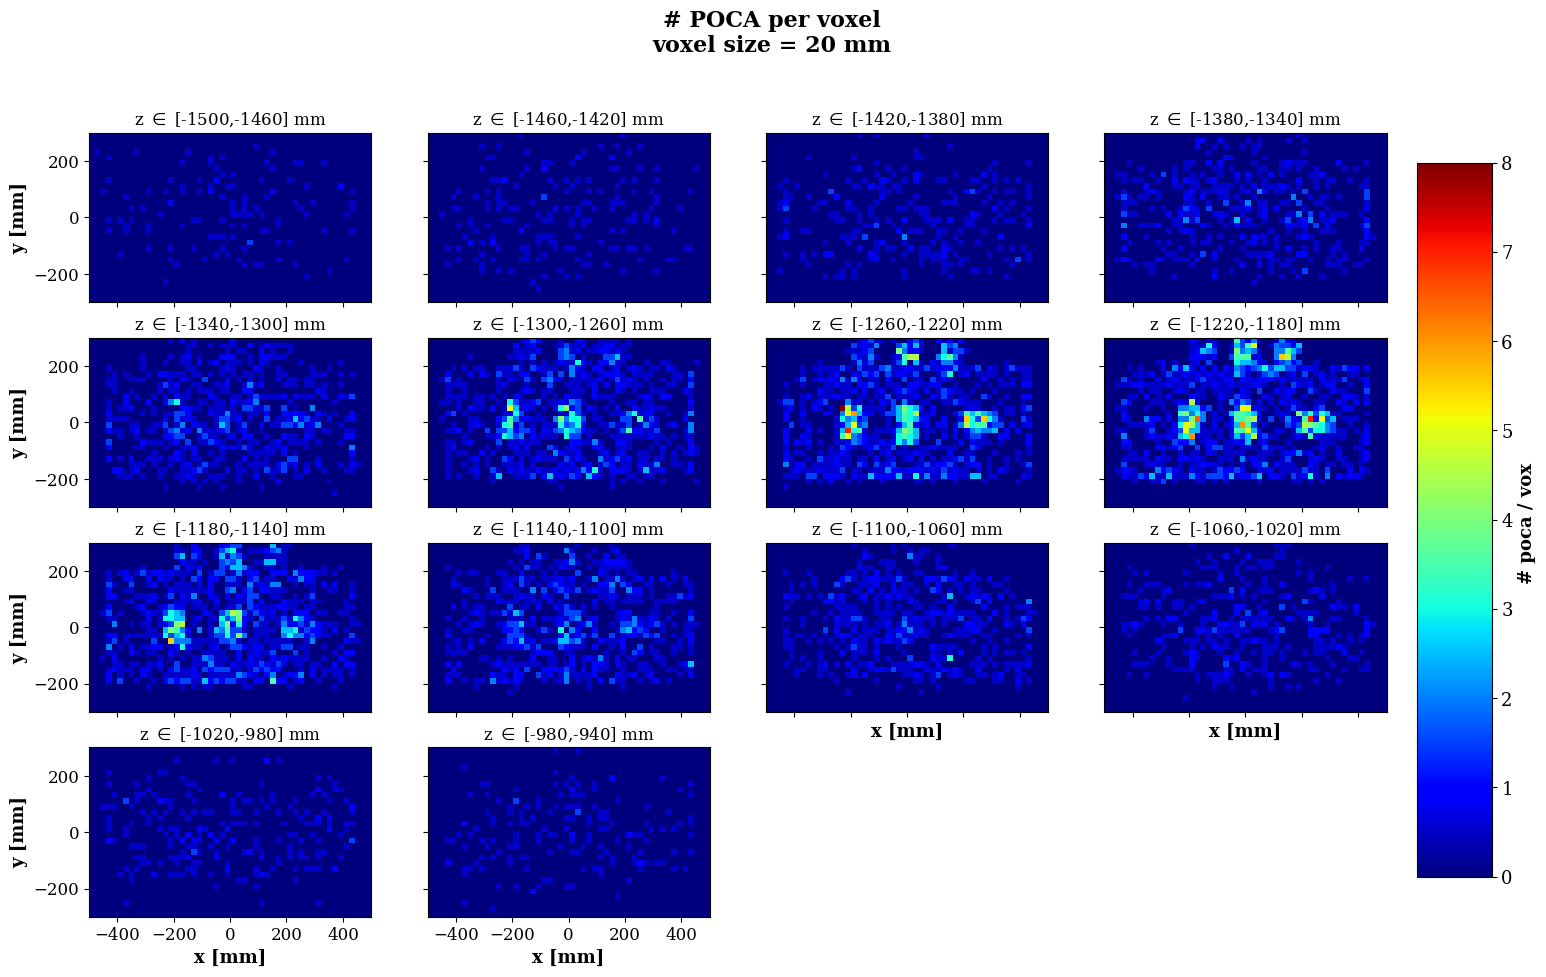

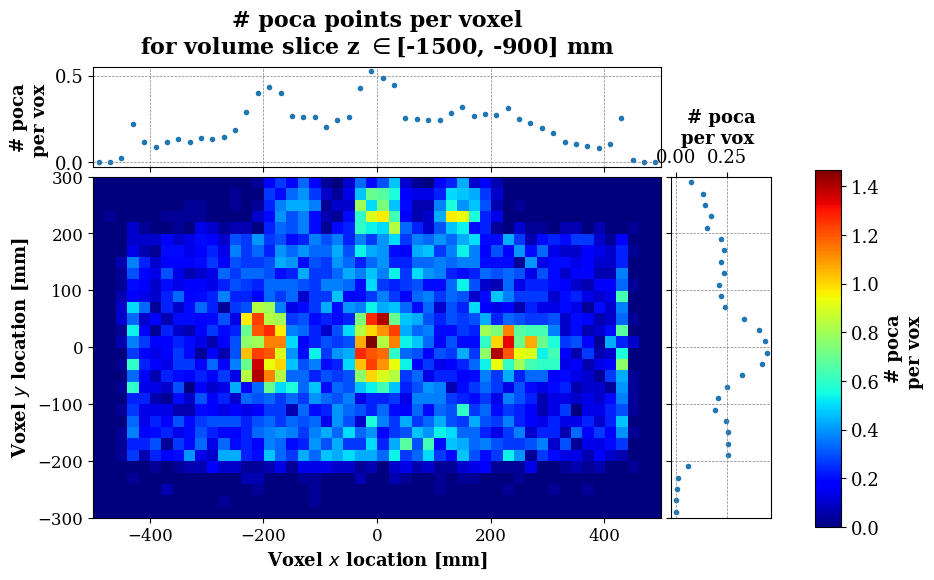


../../output/test1/poca/dtheta_cut_scan directory already exists


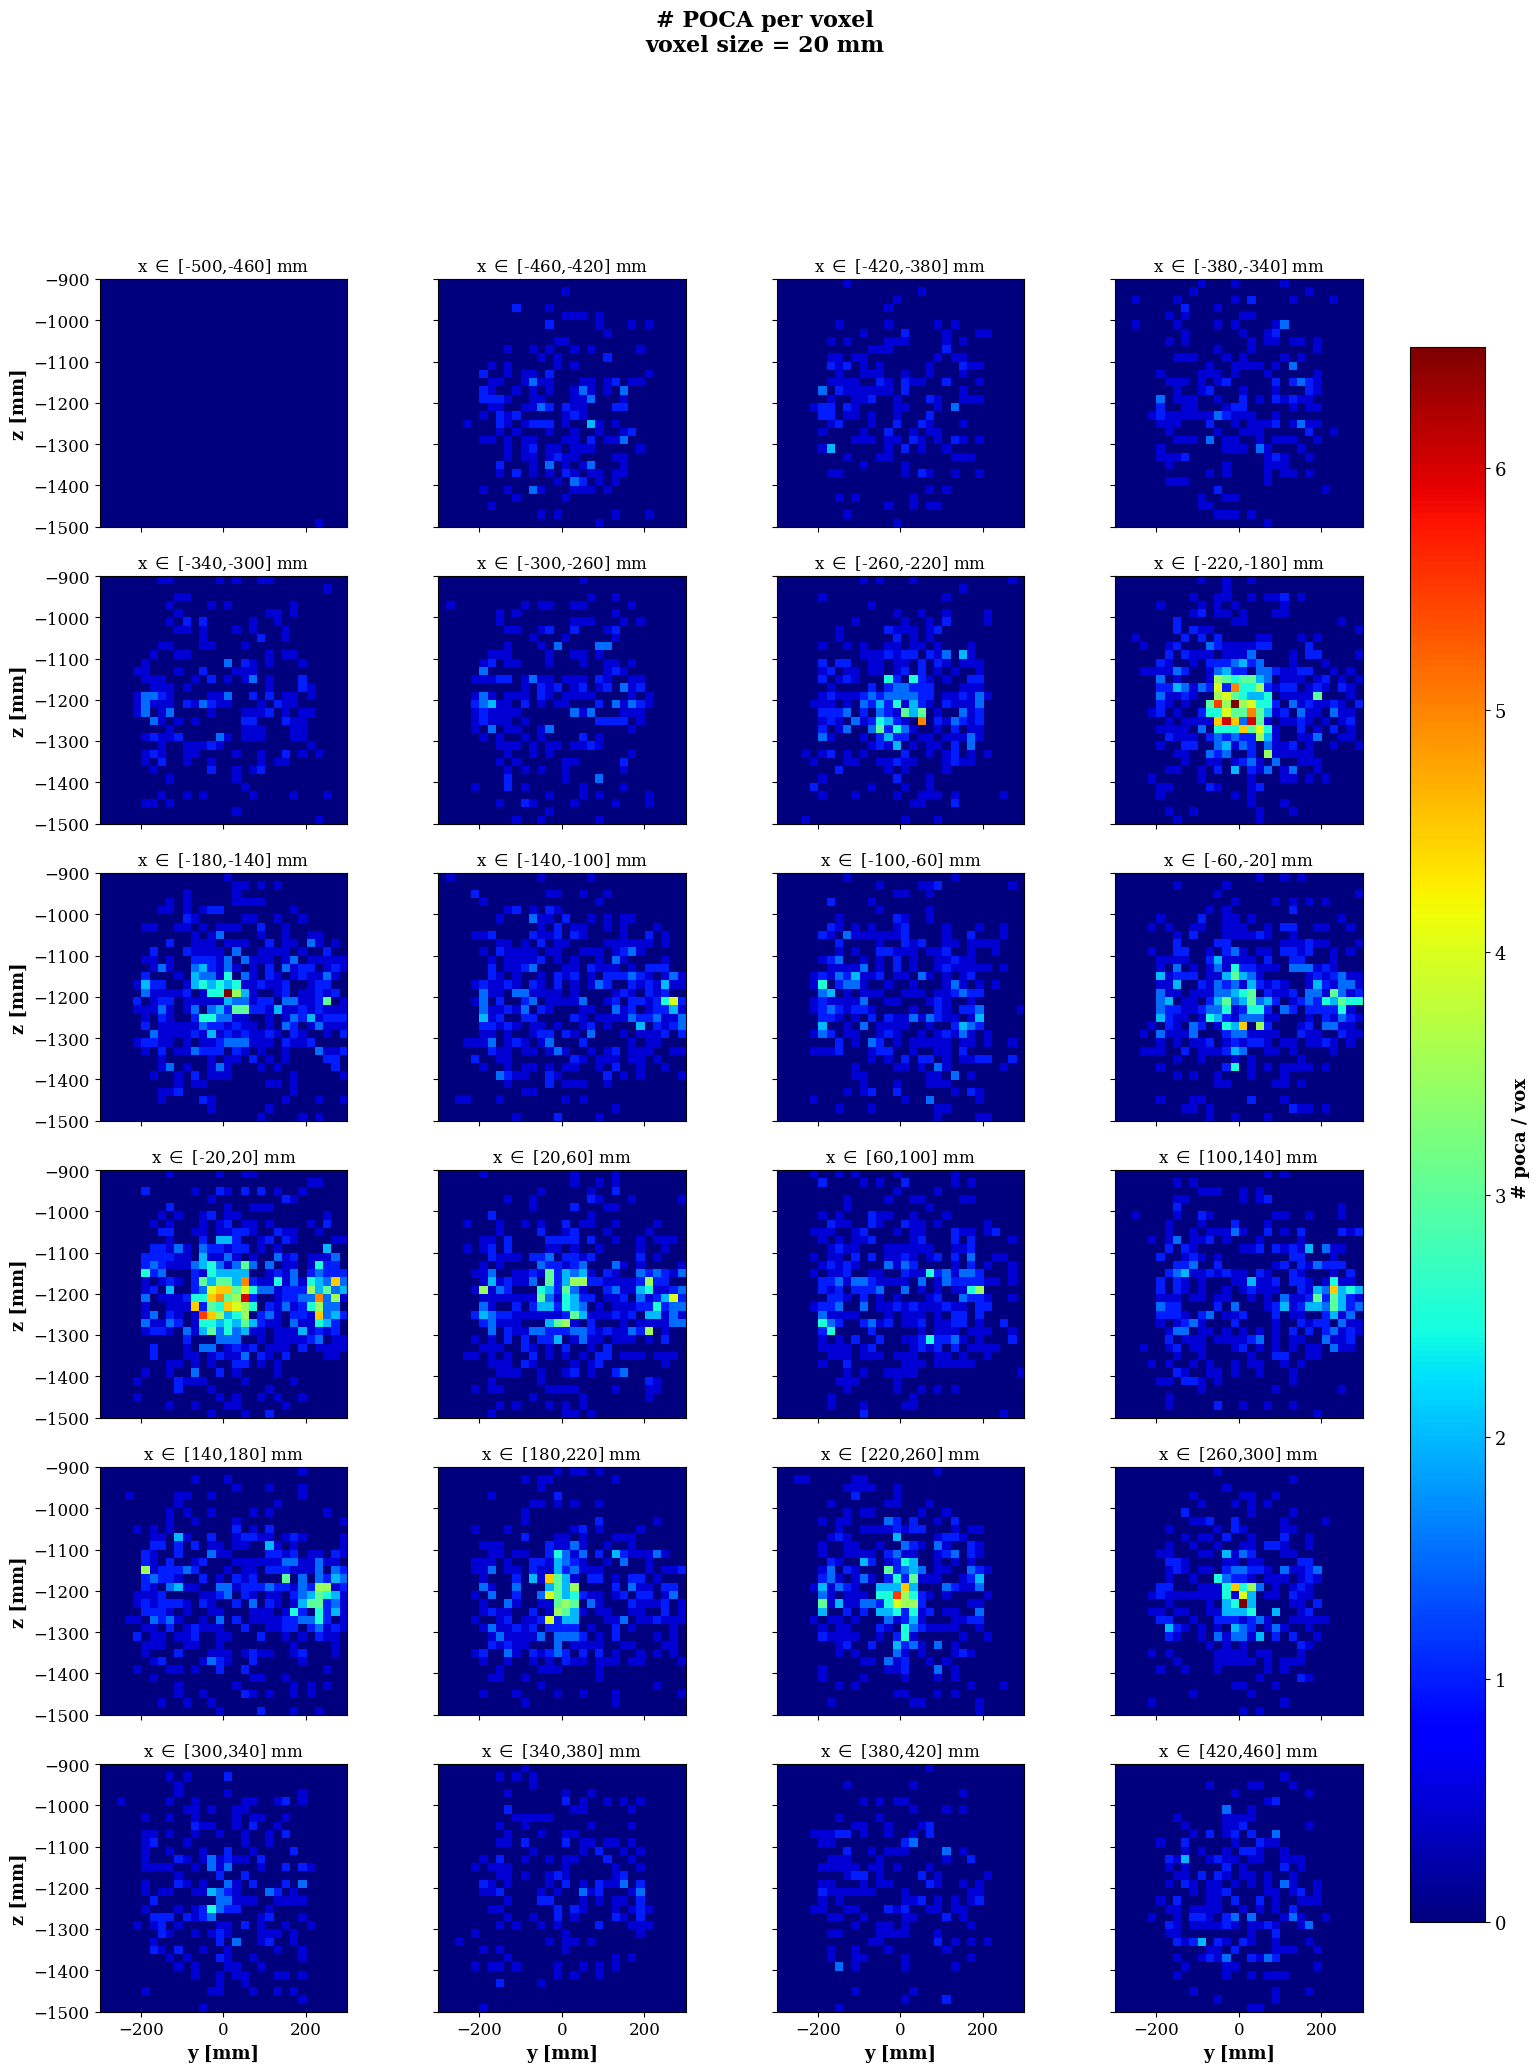

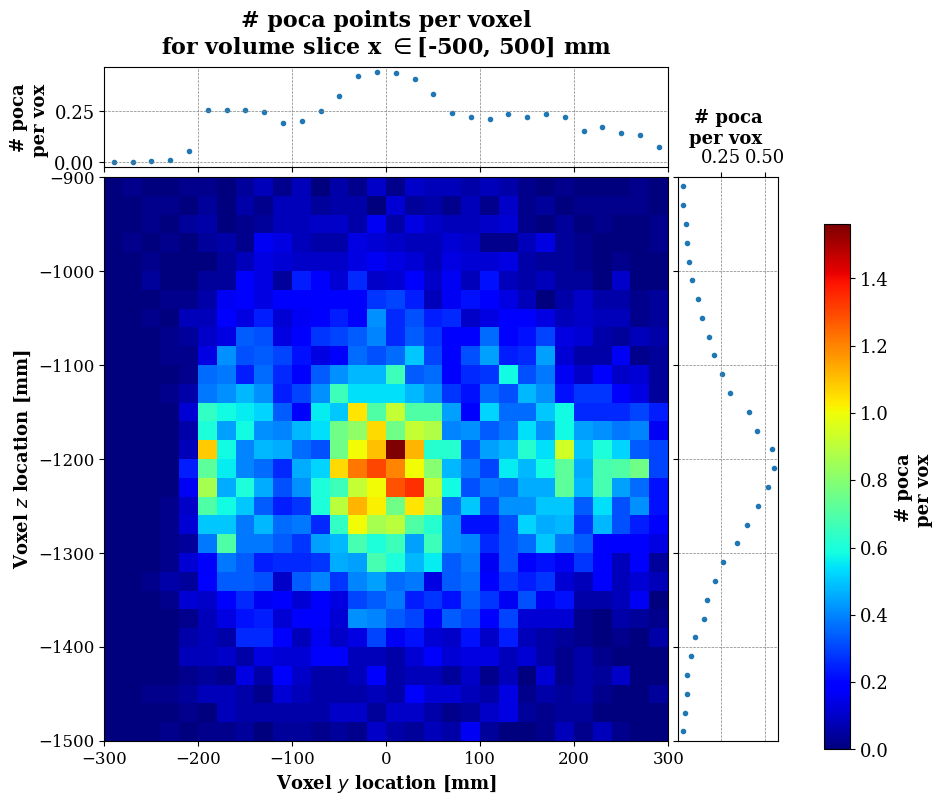

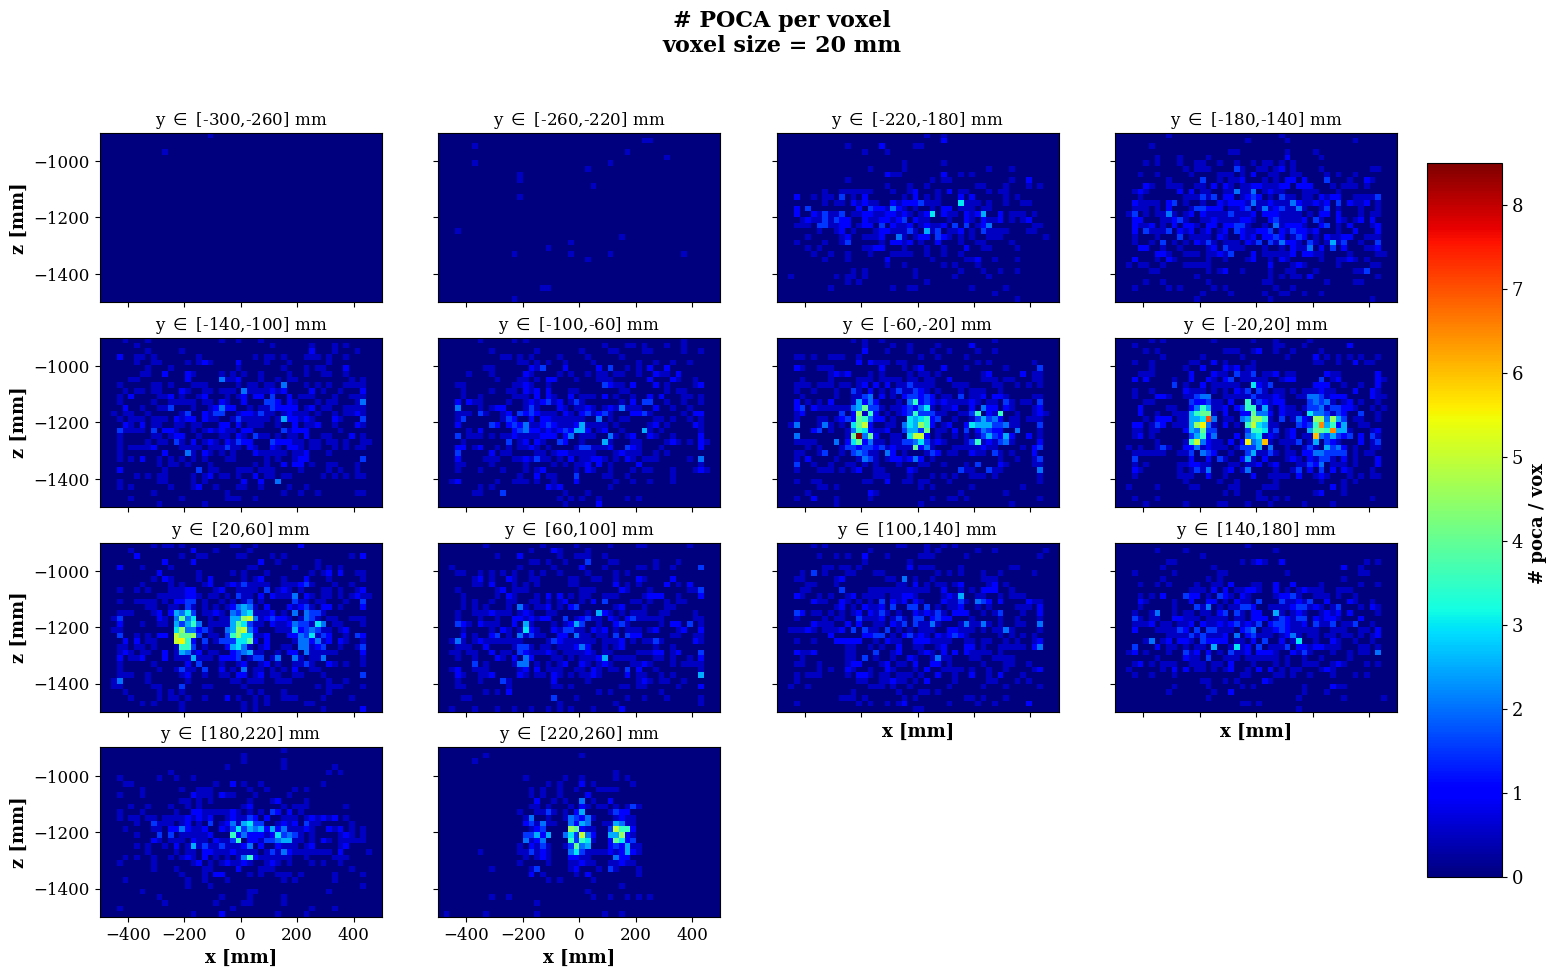

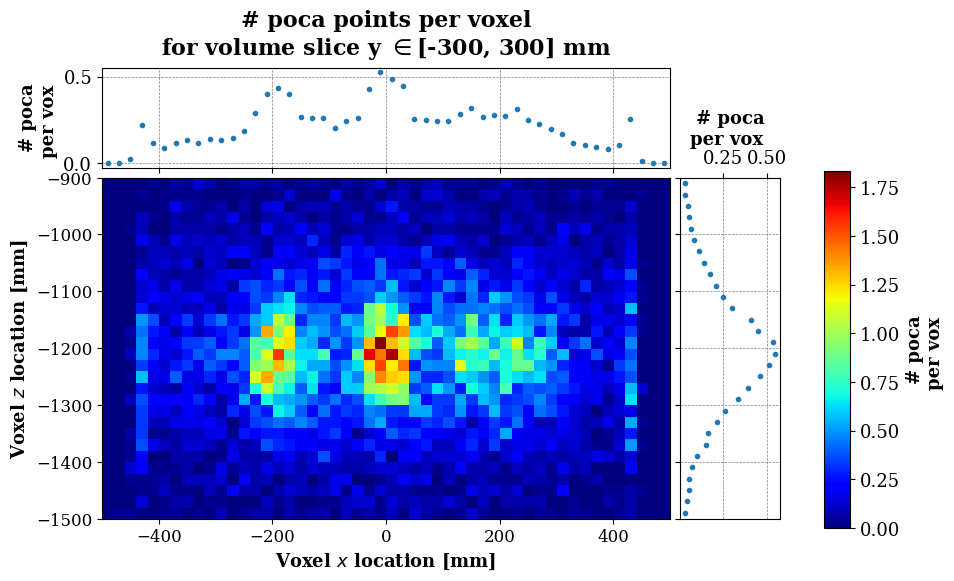

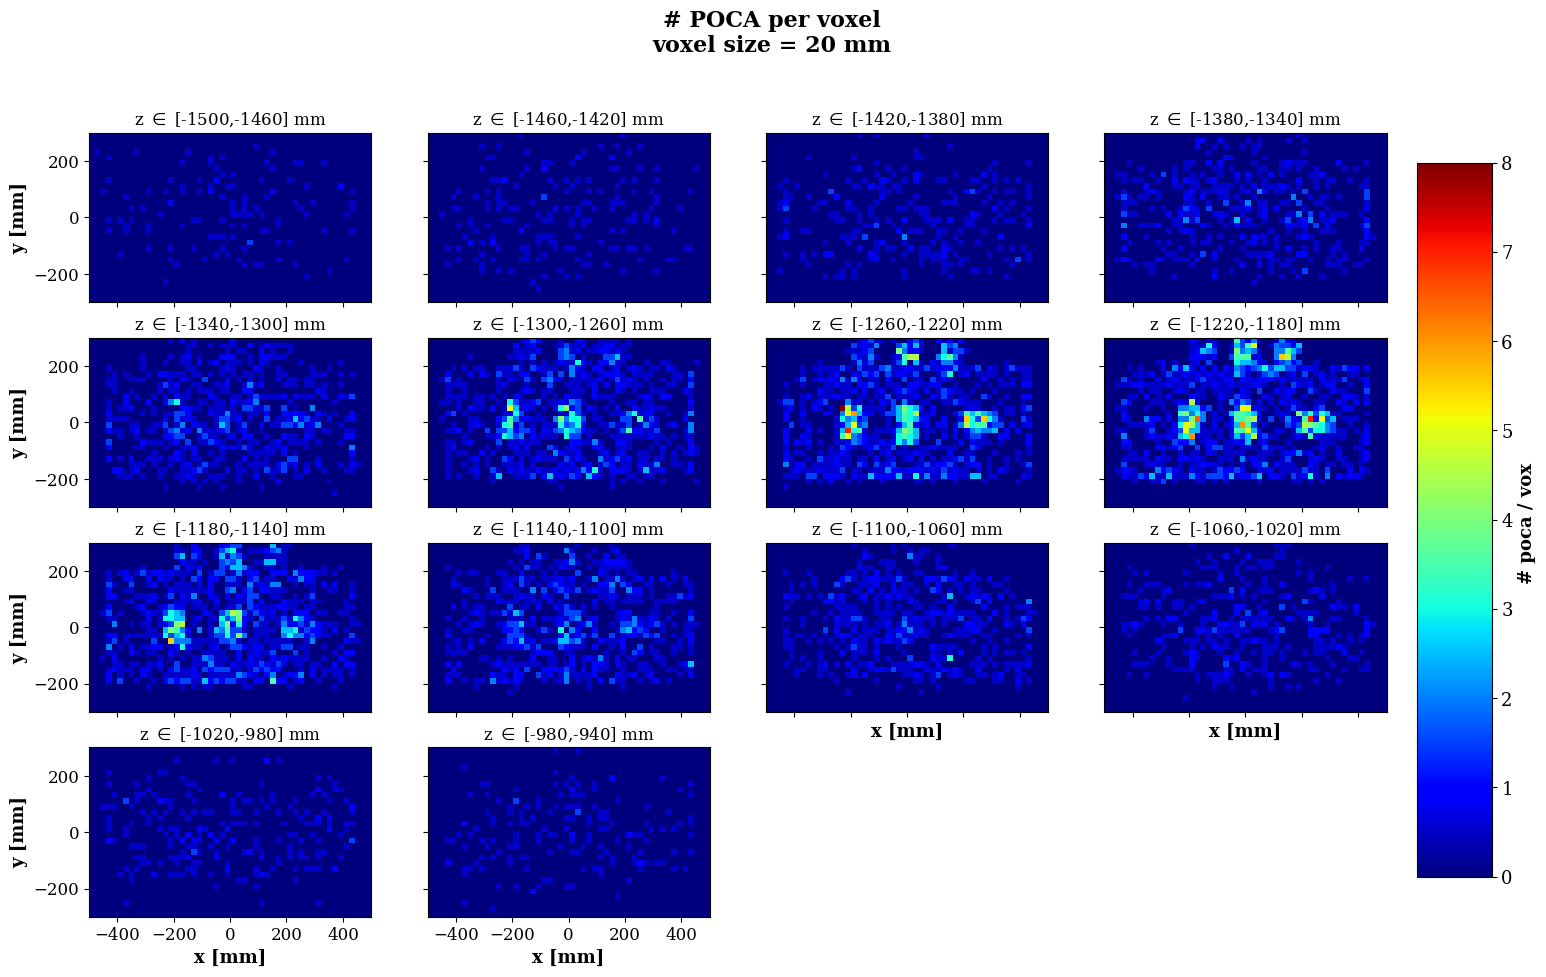

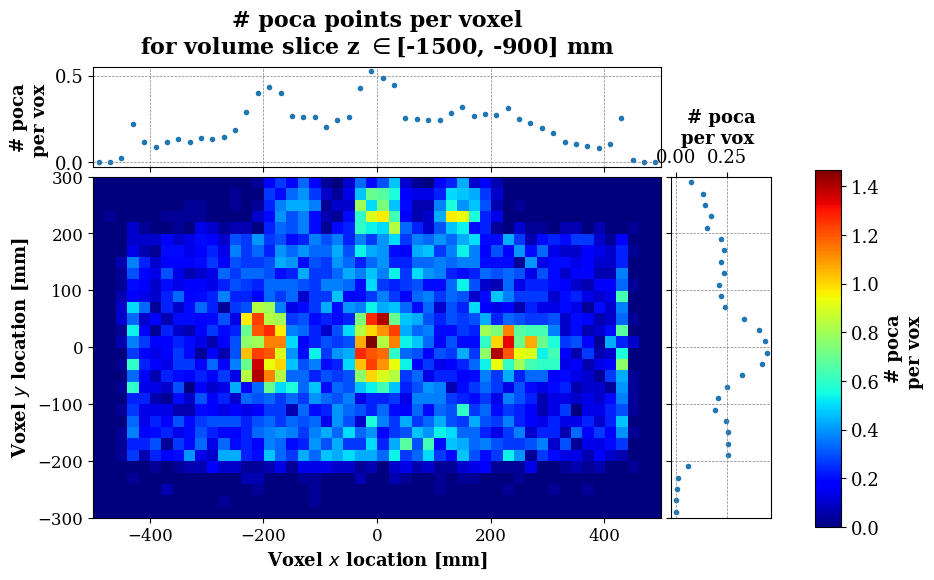


../../output/test1/poca/dtheta_cut_scan directory already exists


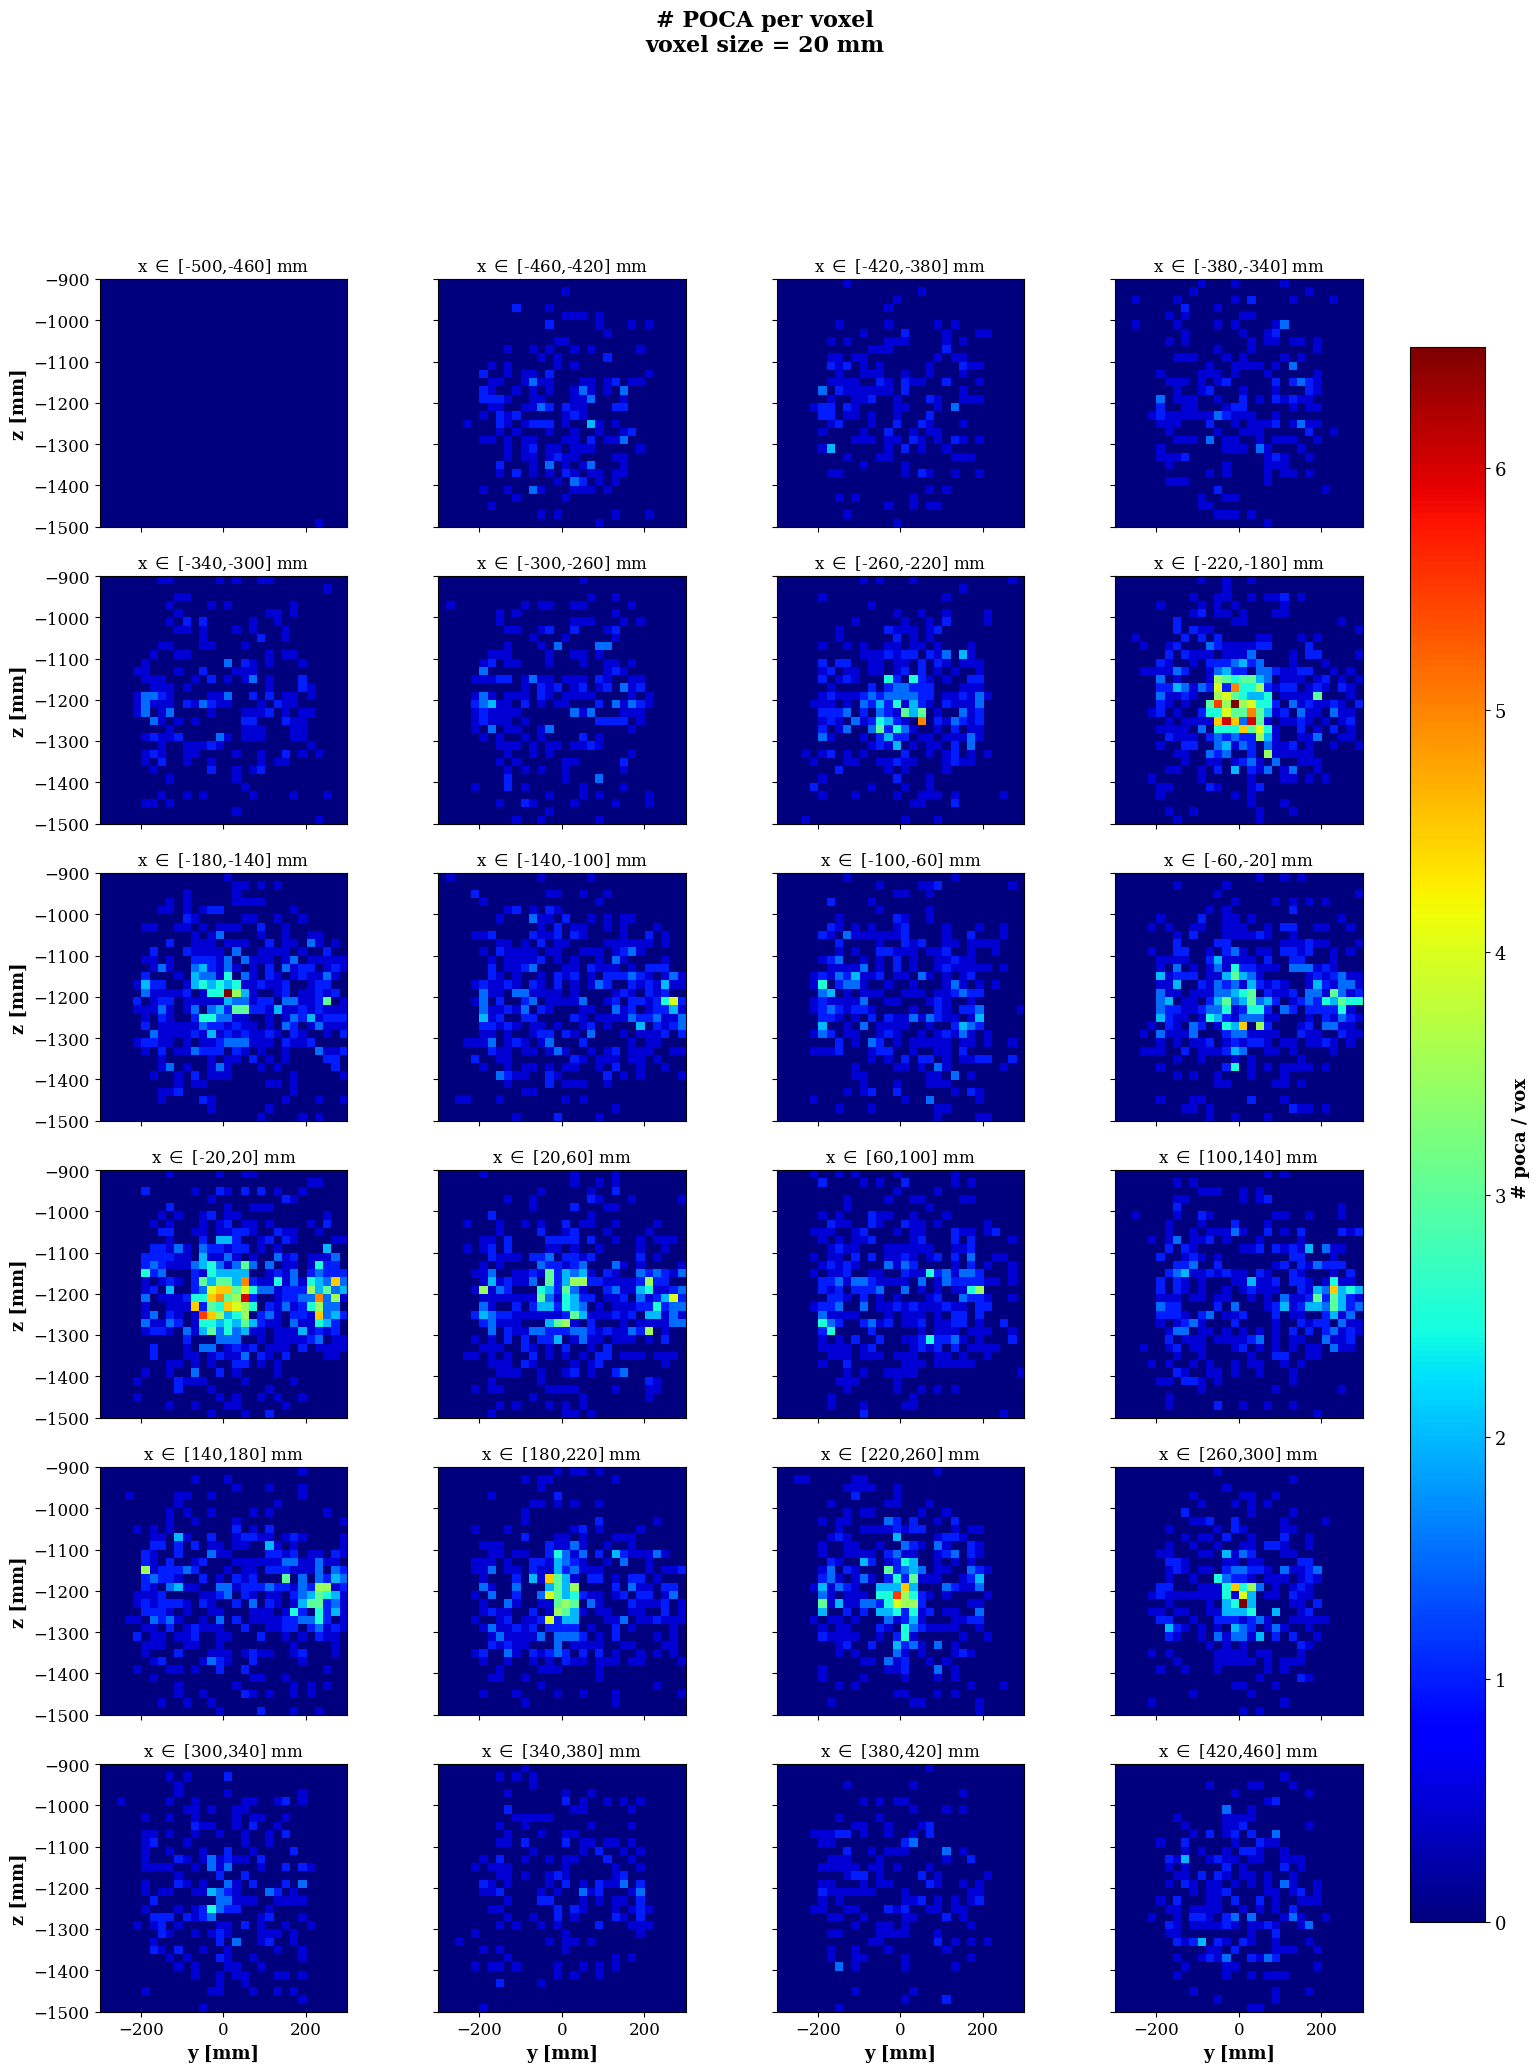

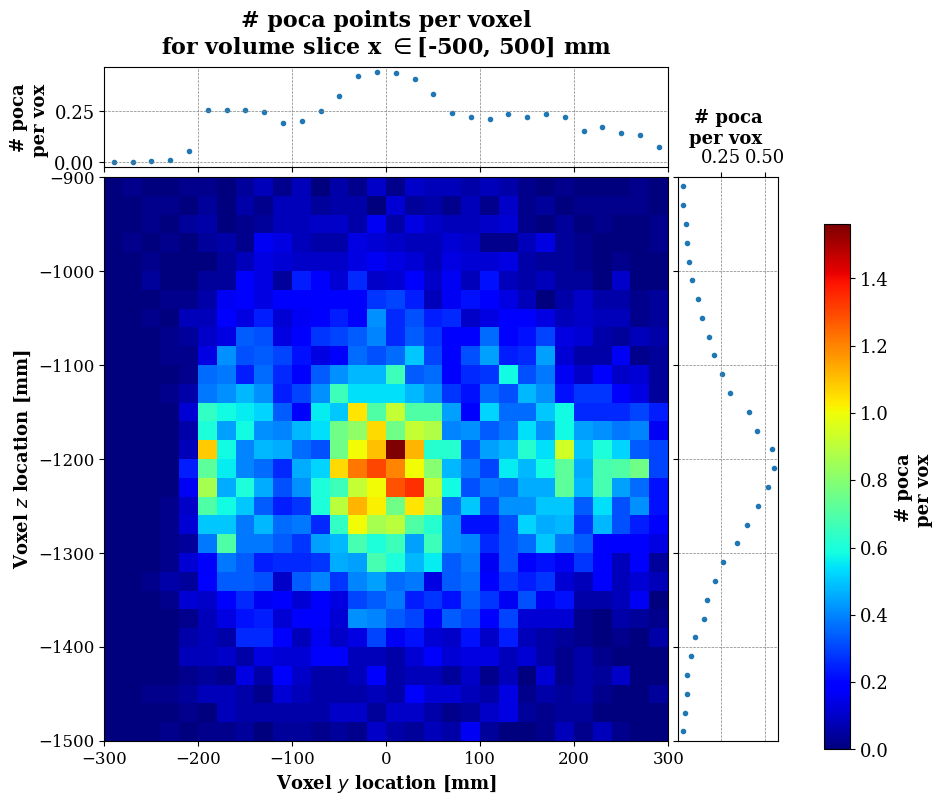

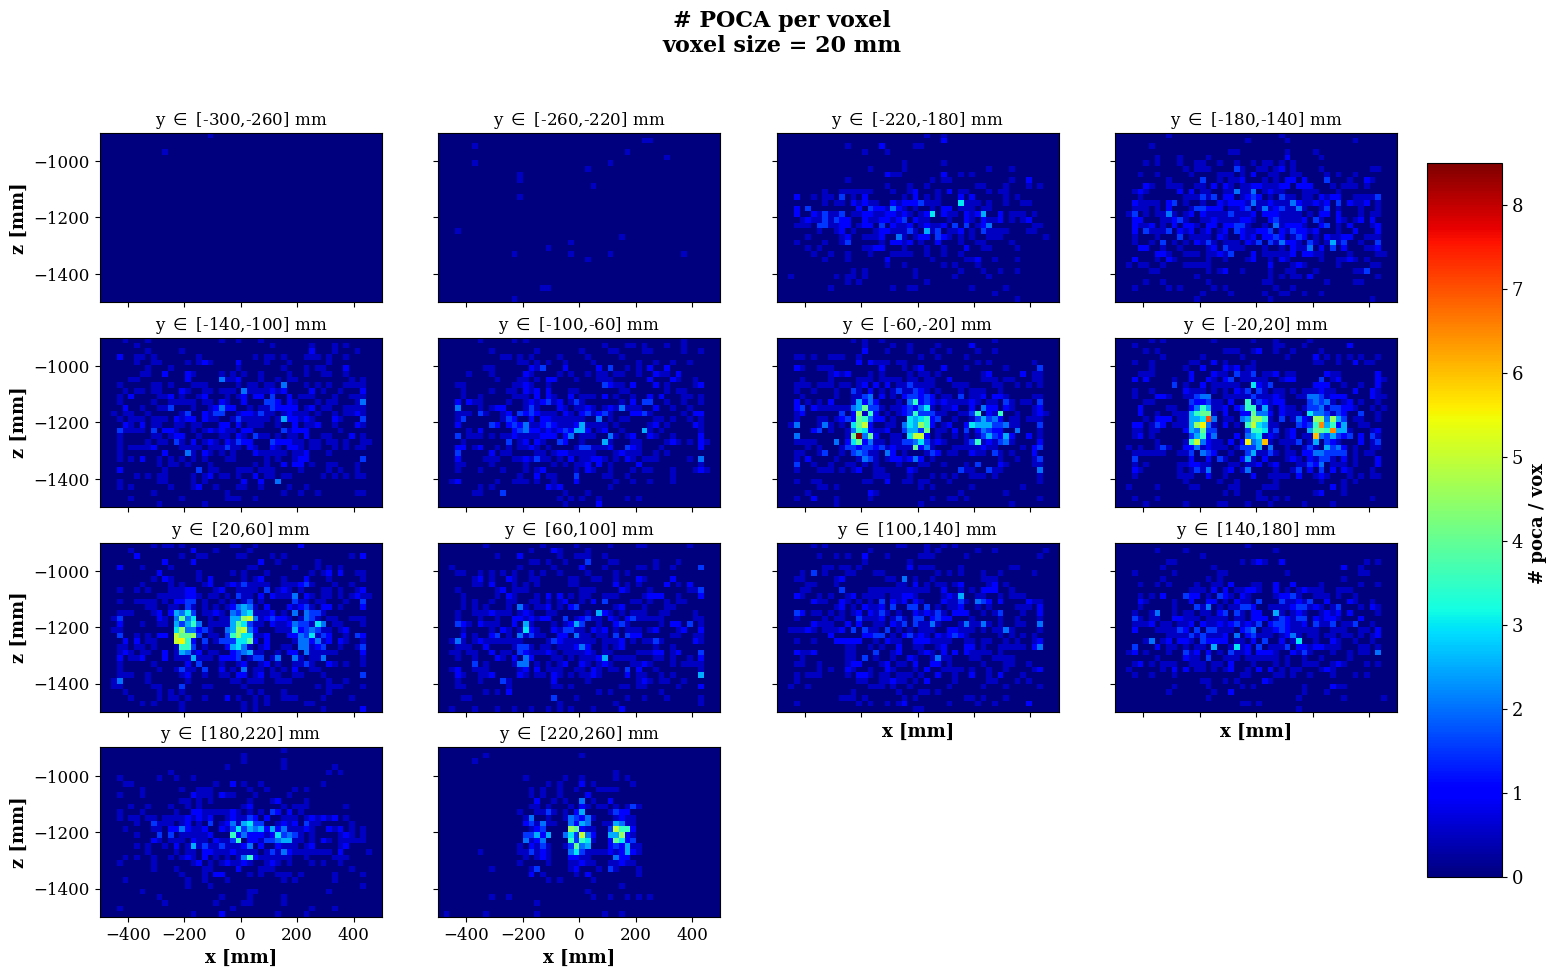

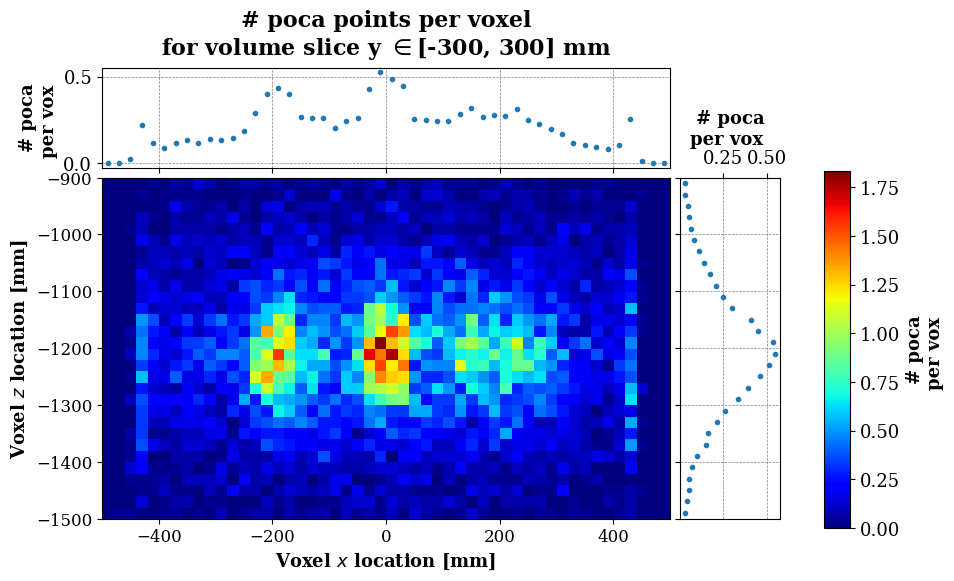

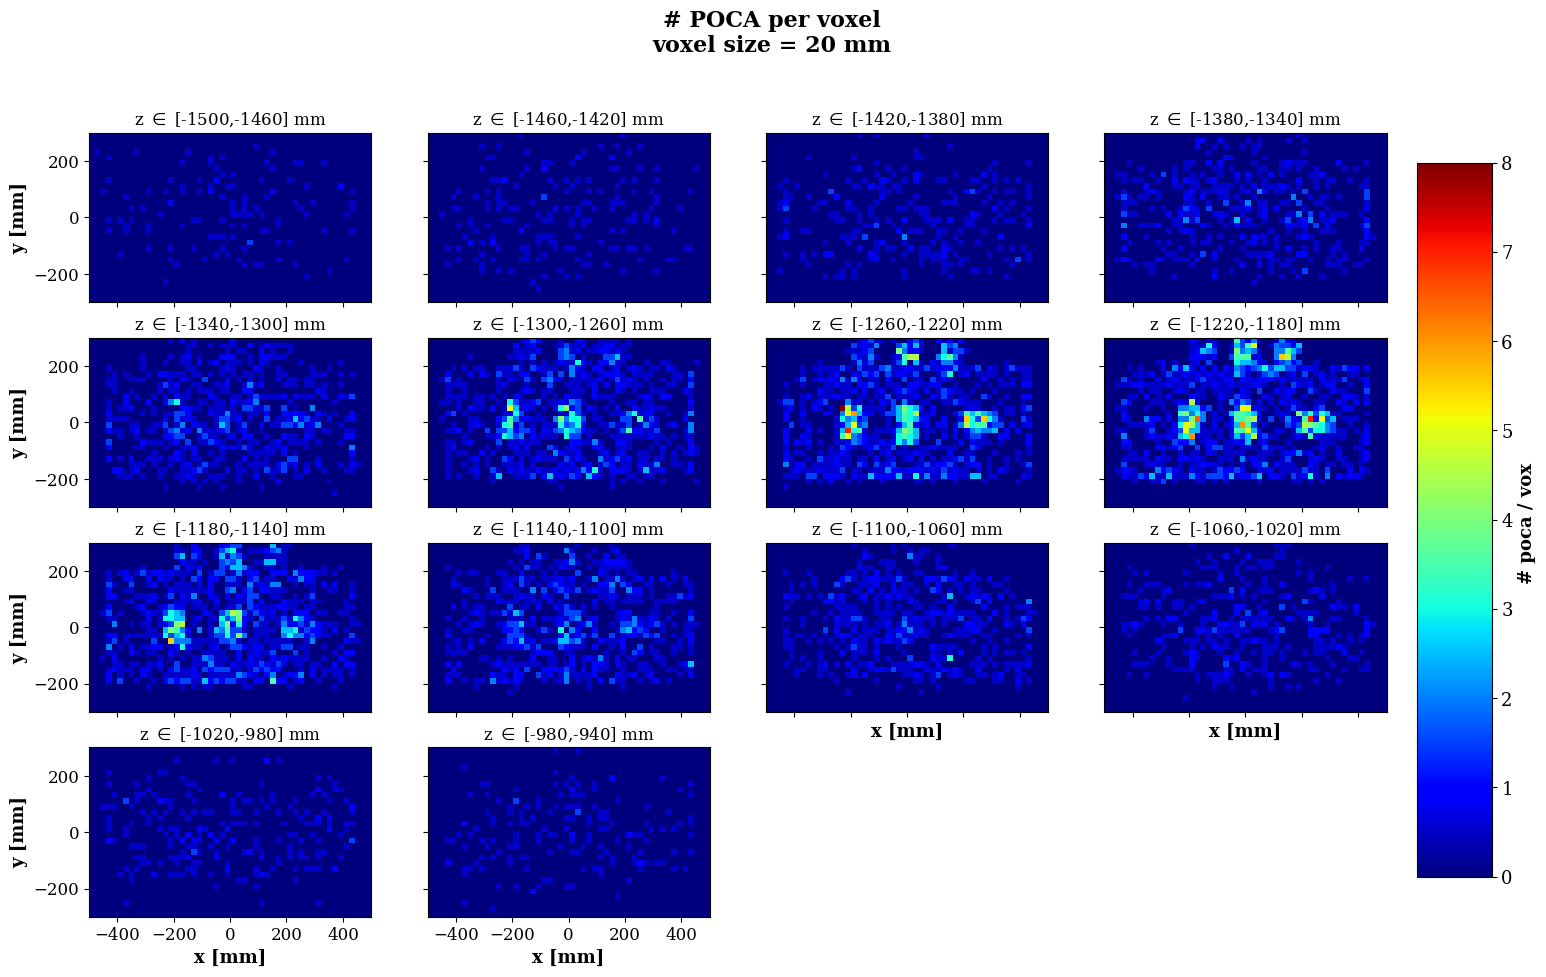

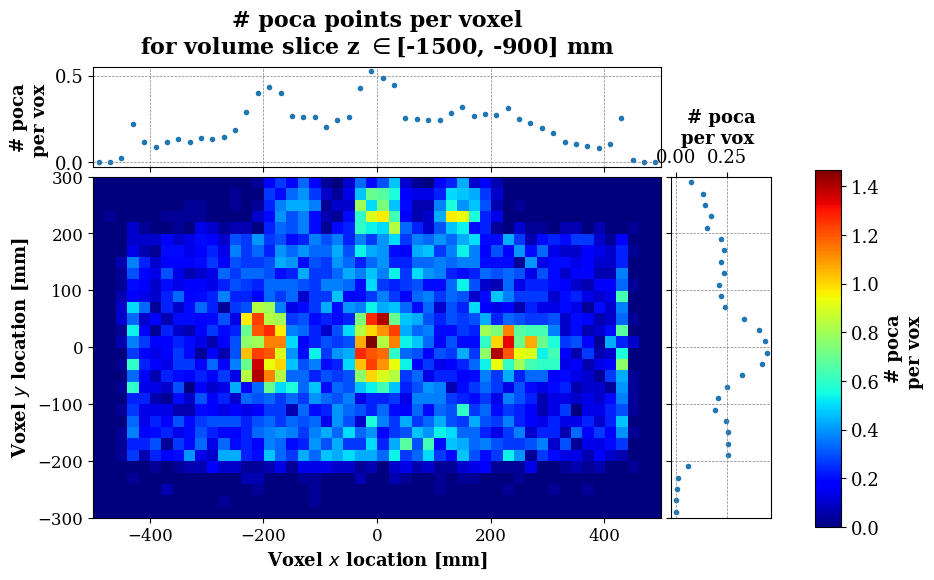


../../output/test1/poca/dtheta_cut_scan directory already exists


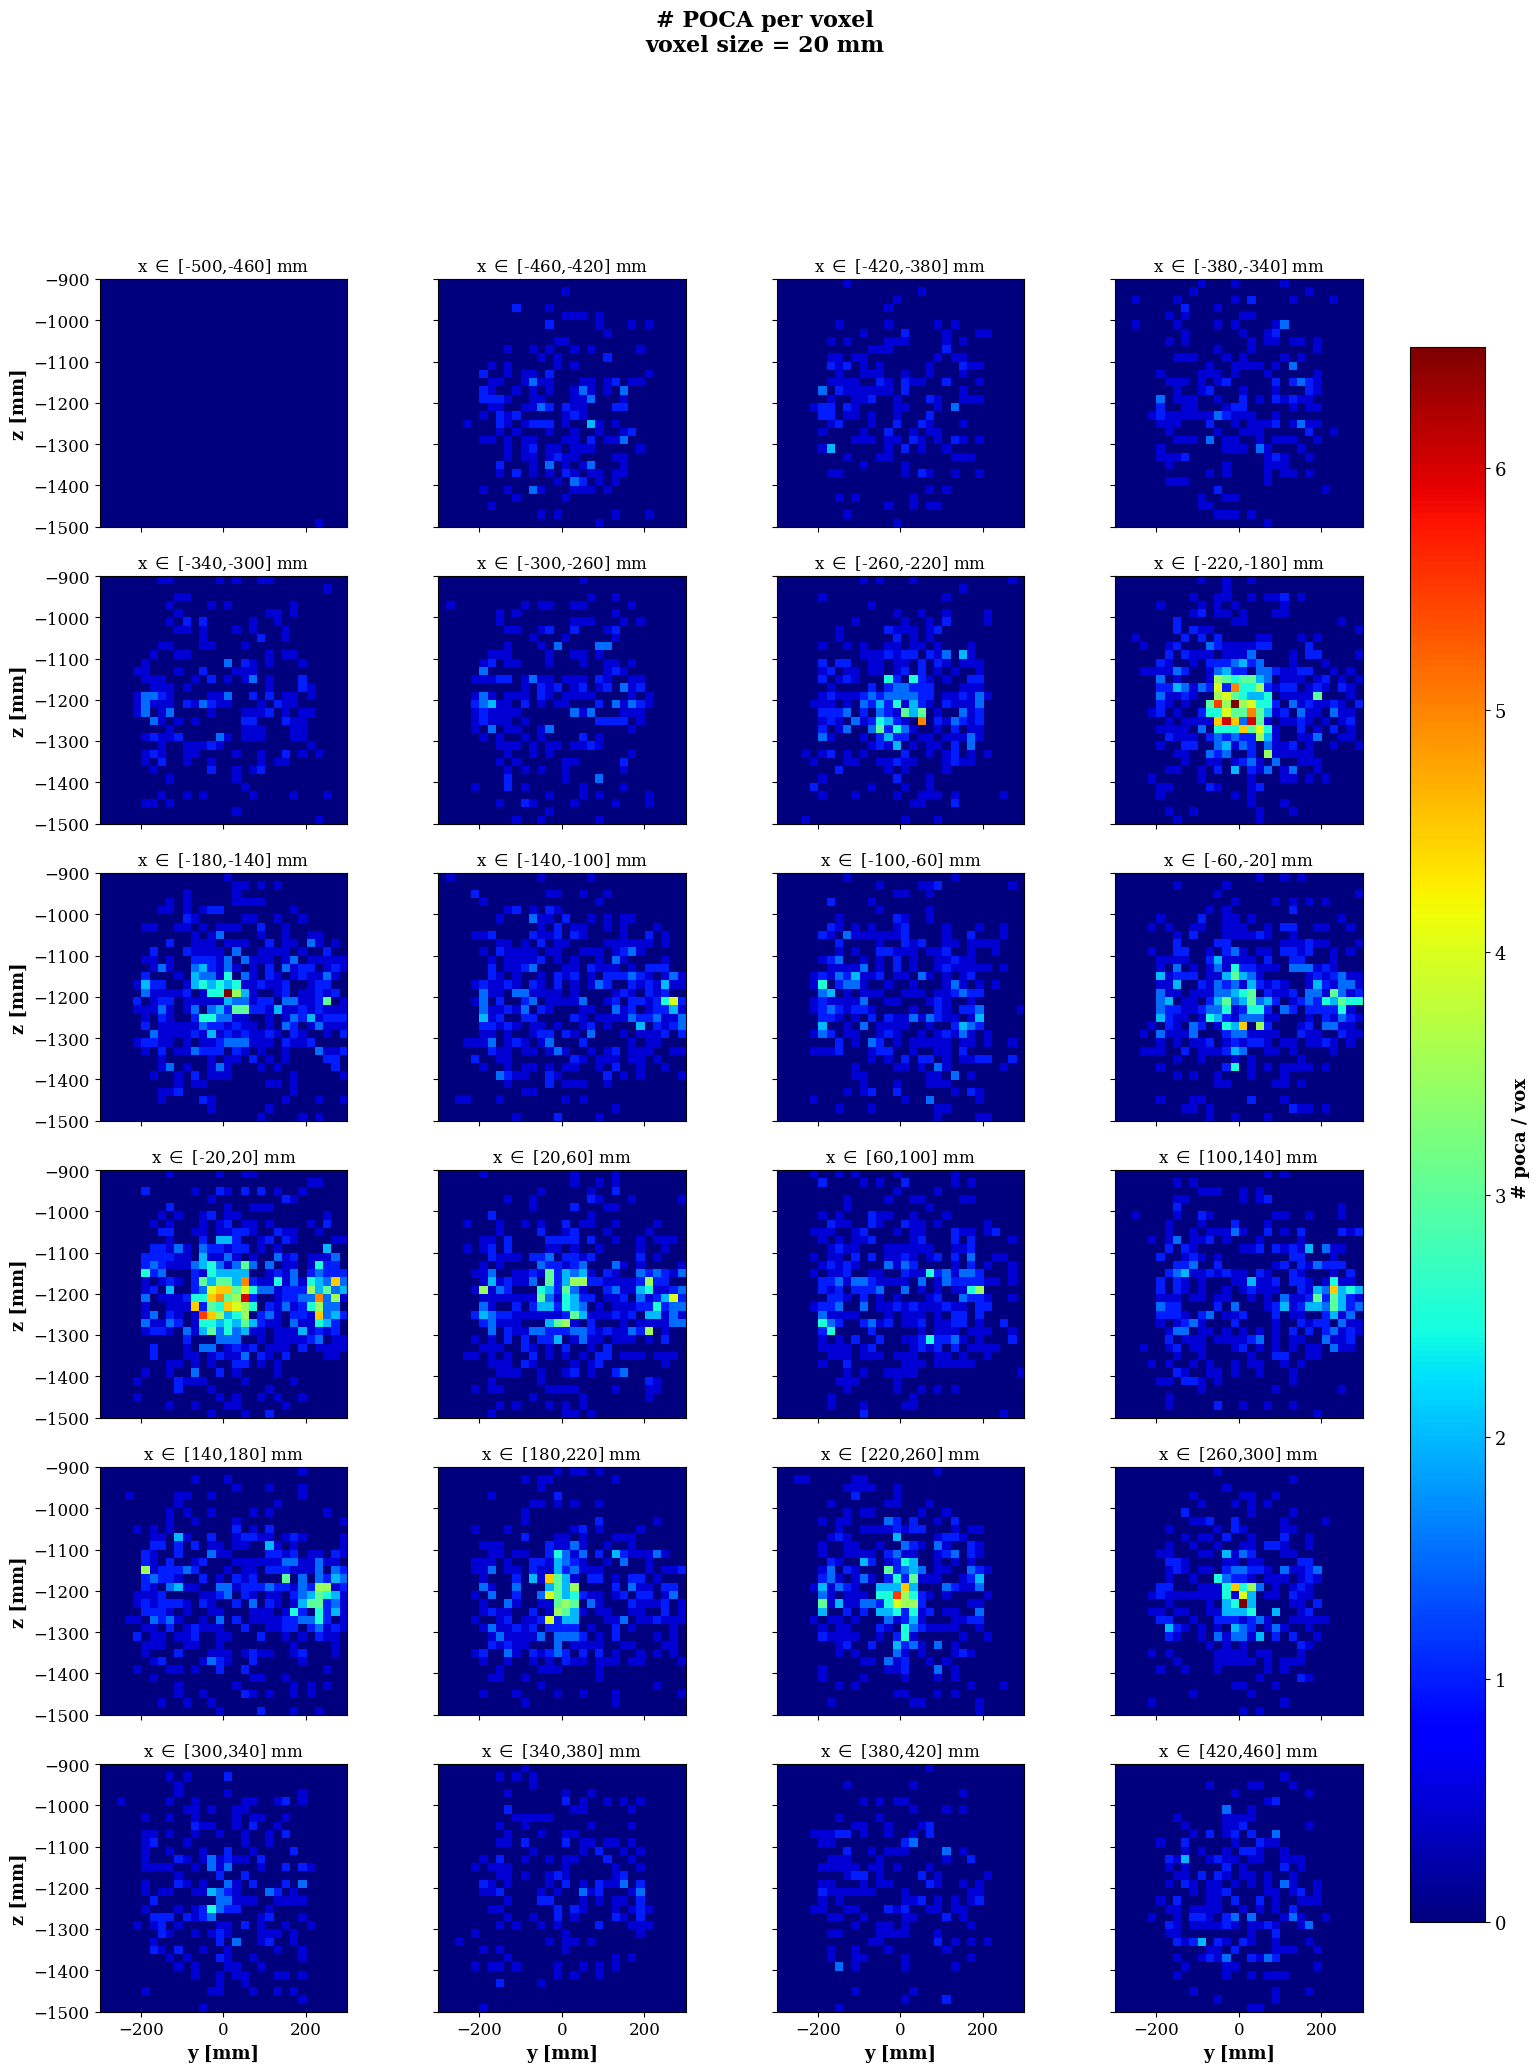

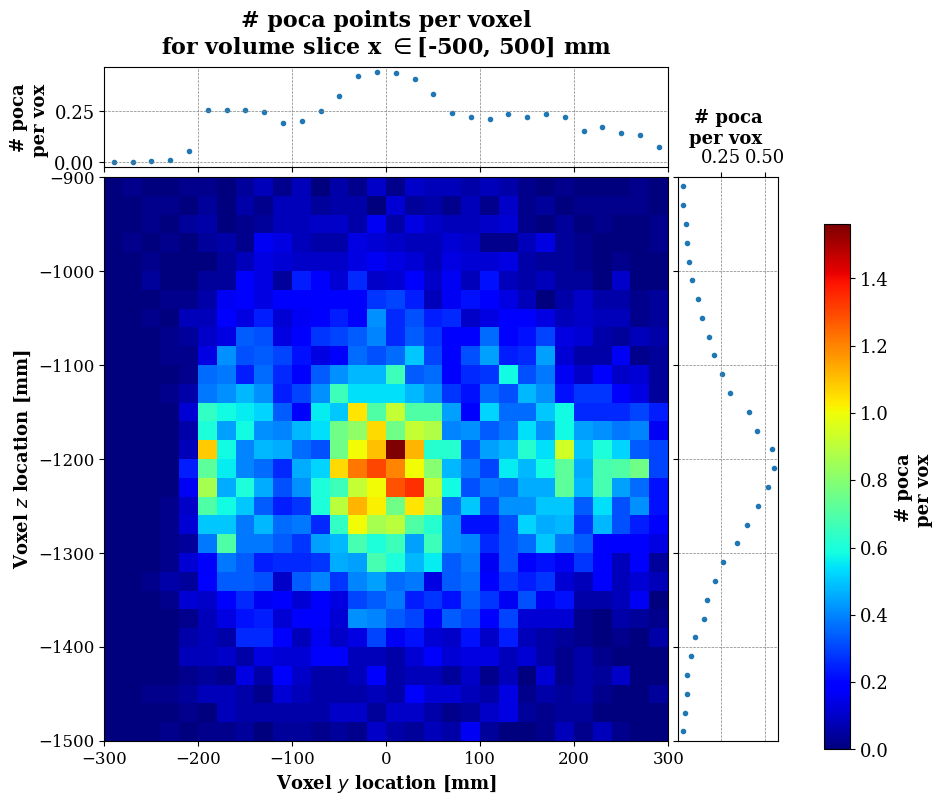

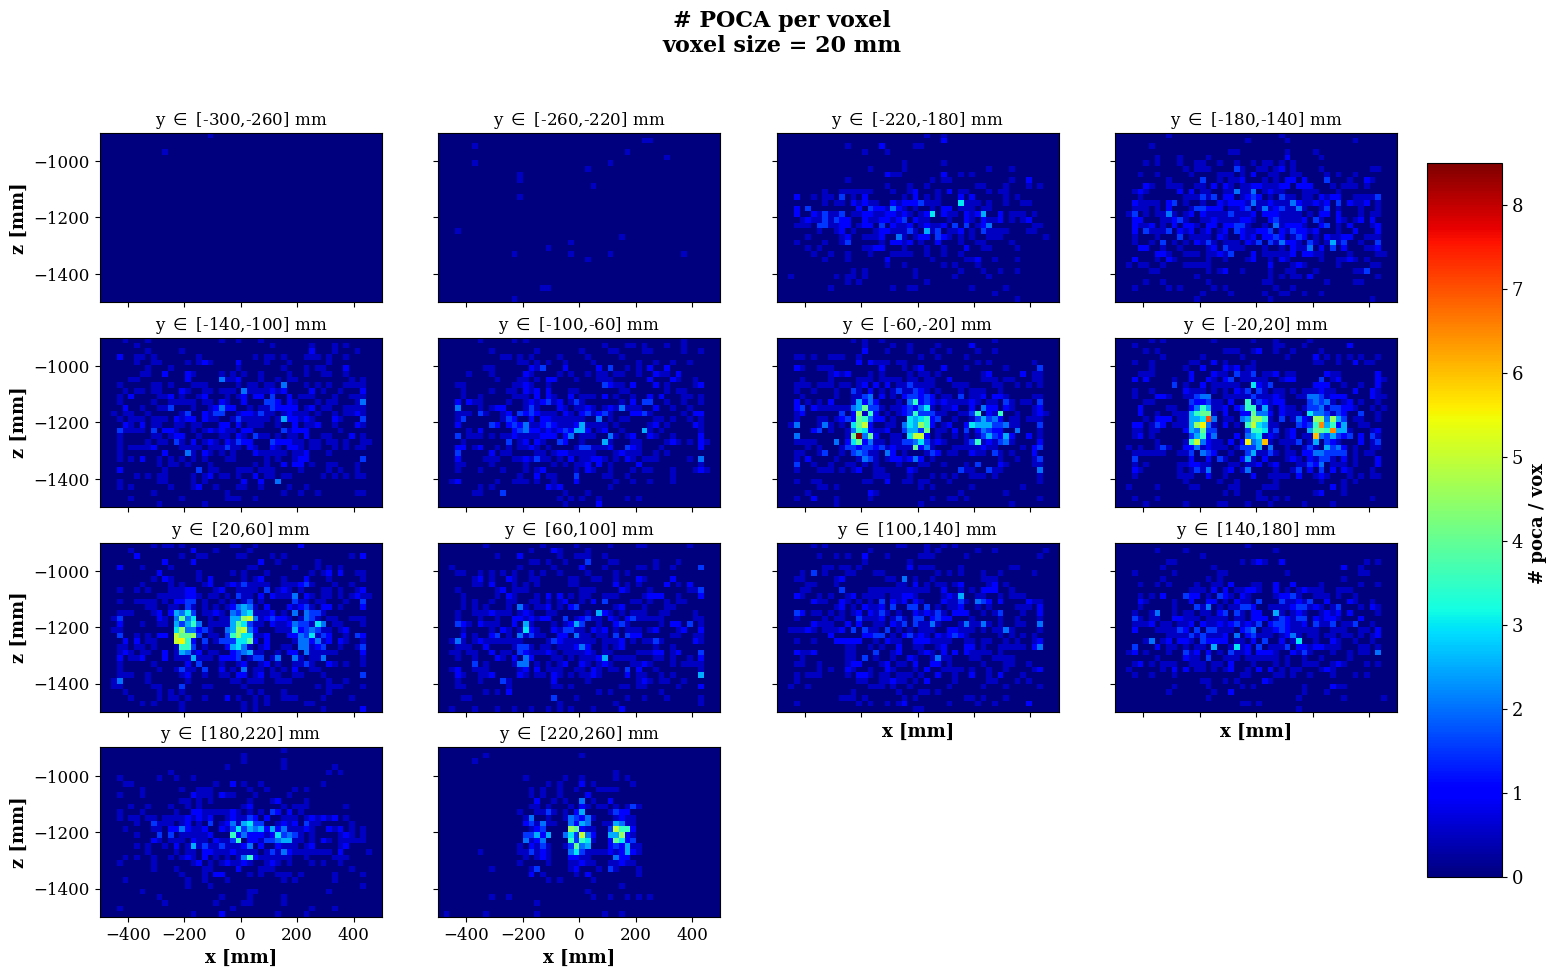

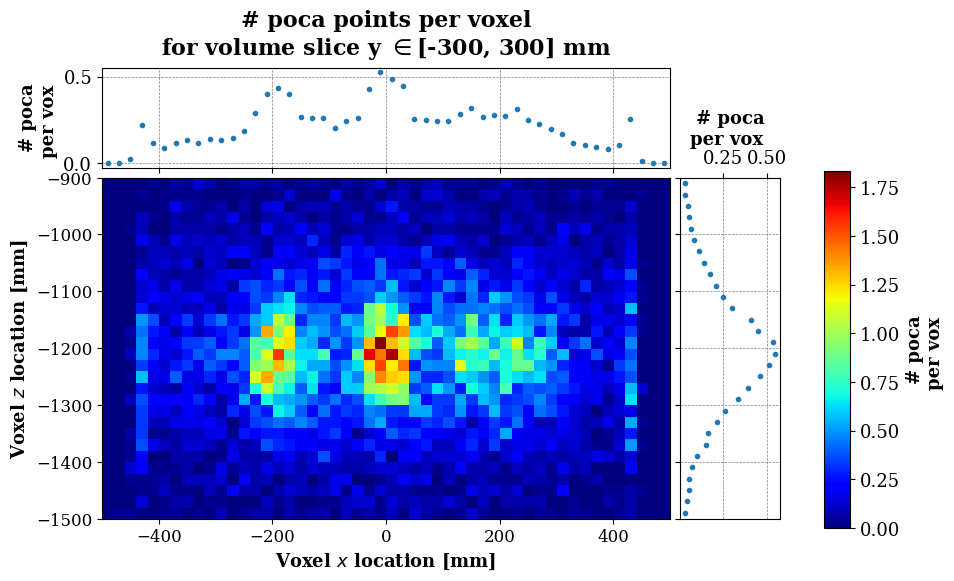

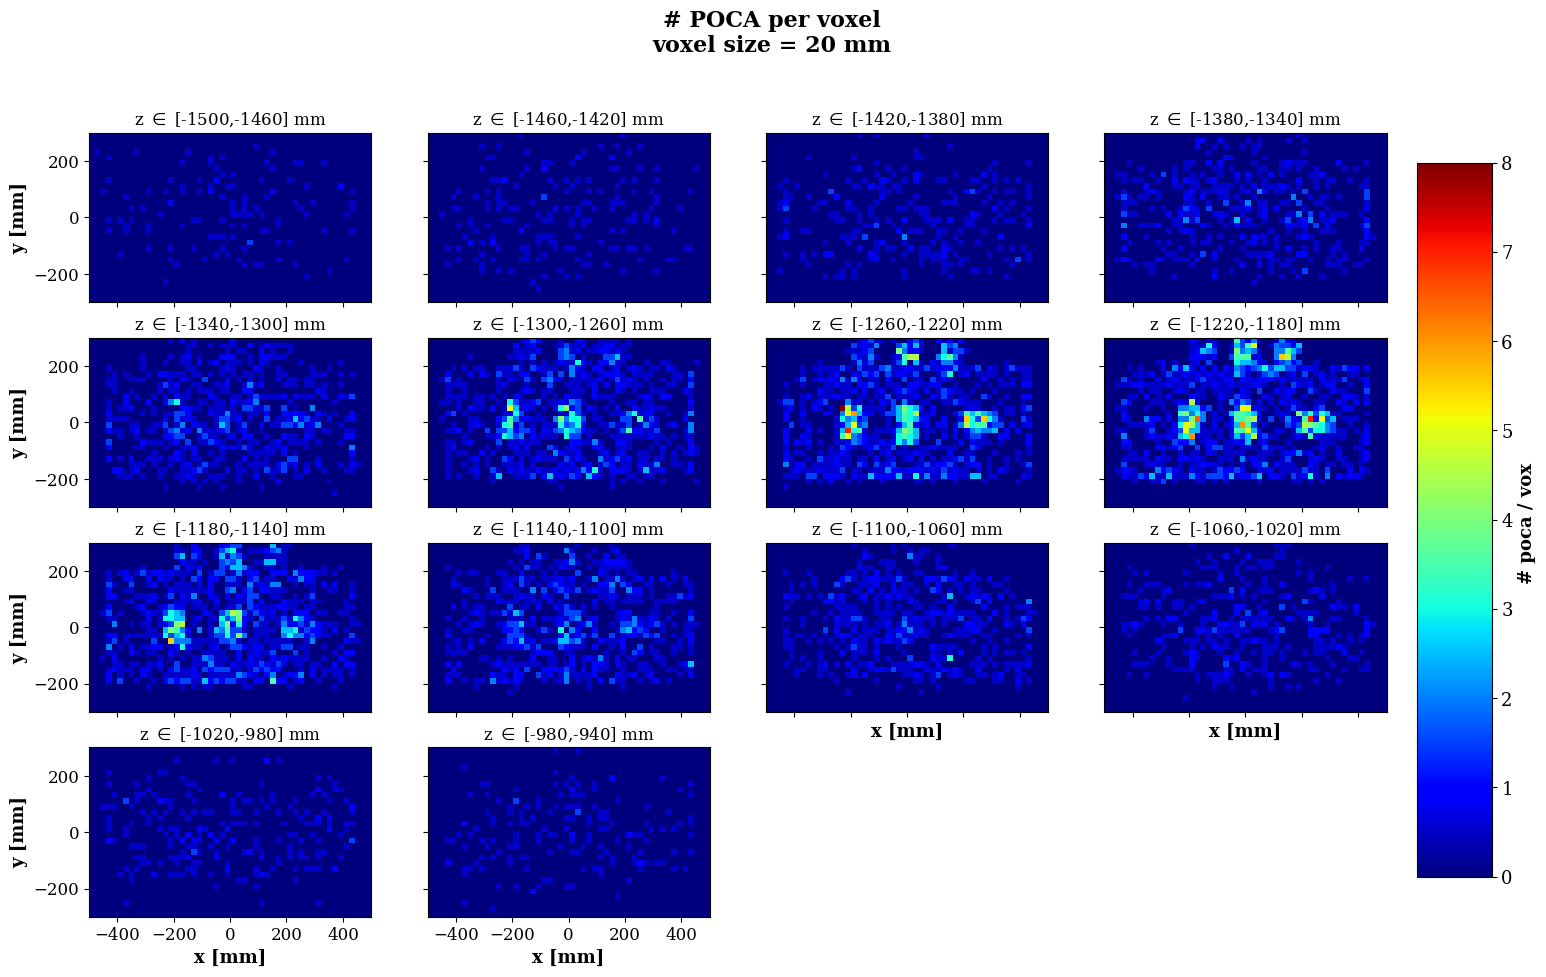

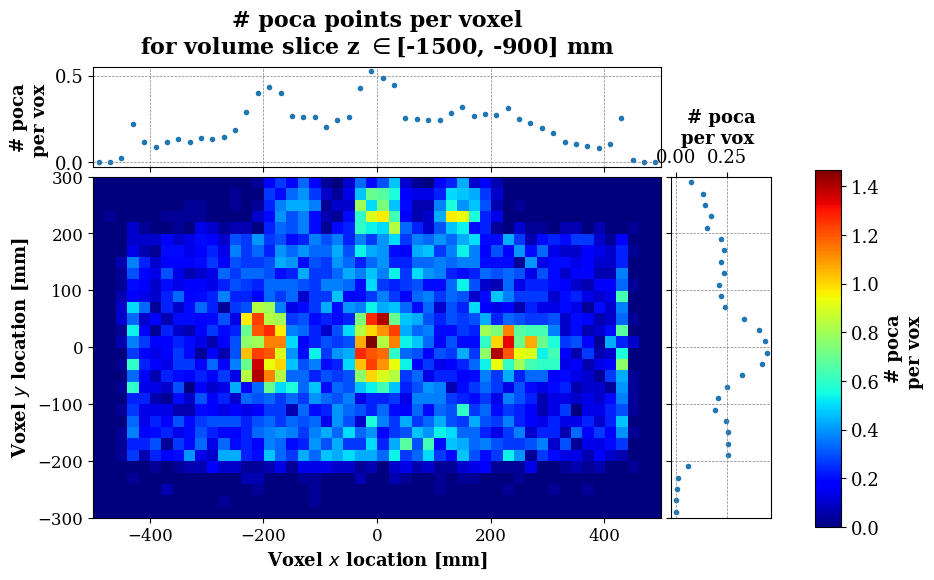


../../output/test1/poca/dtheta_cut_scan directory already exists


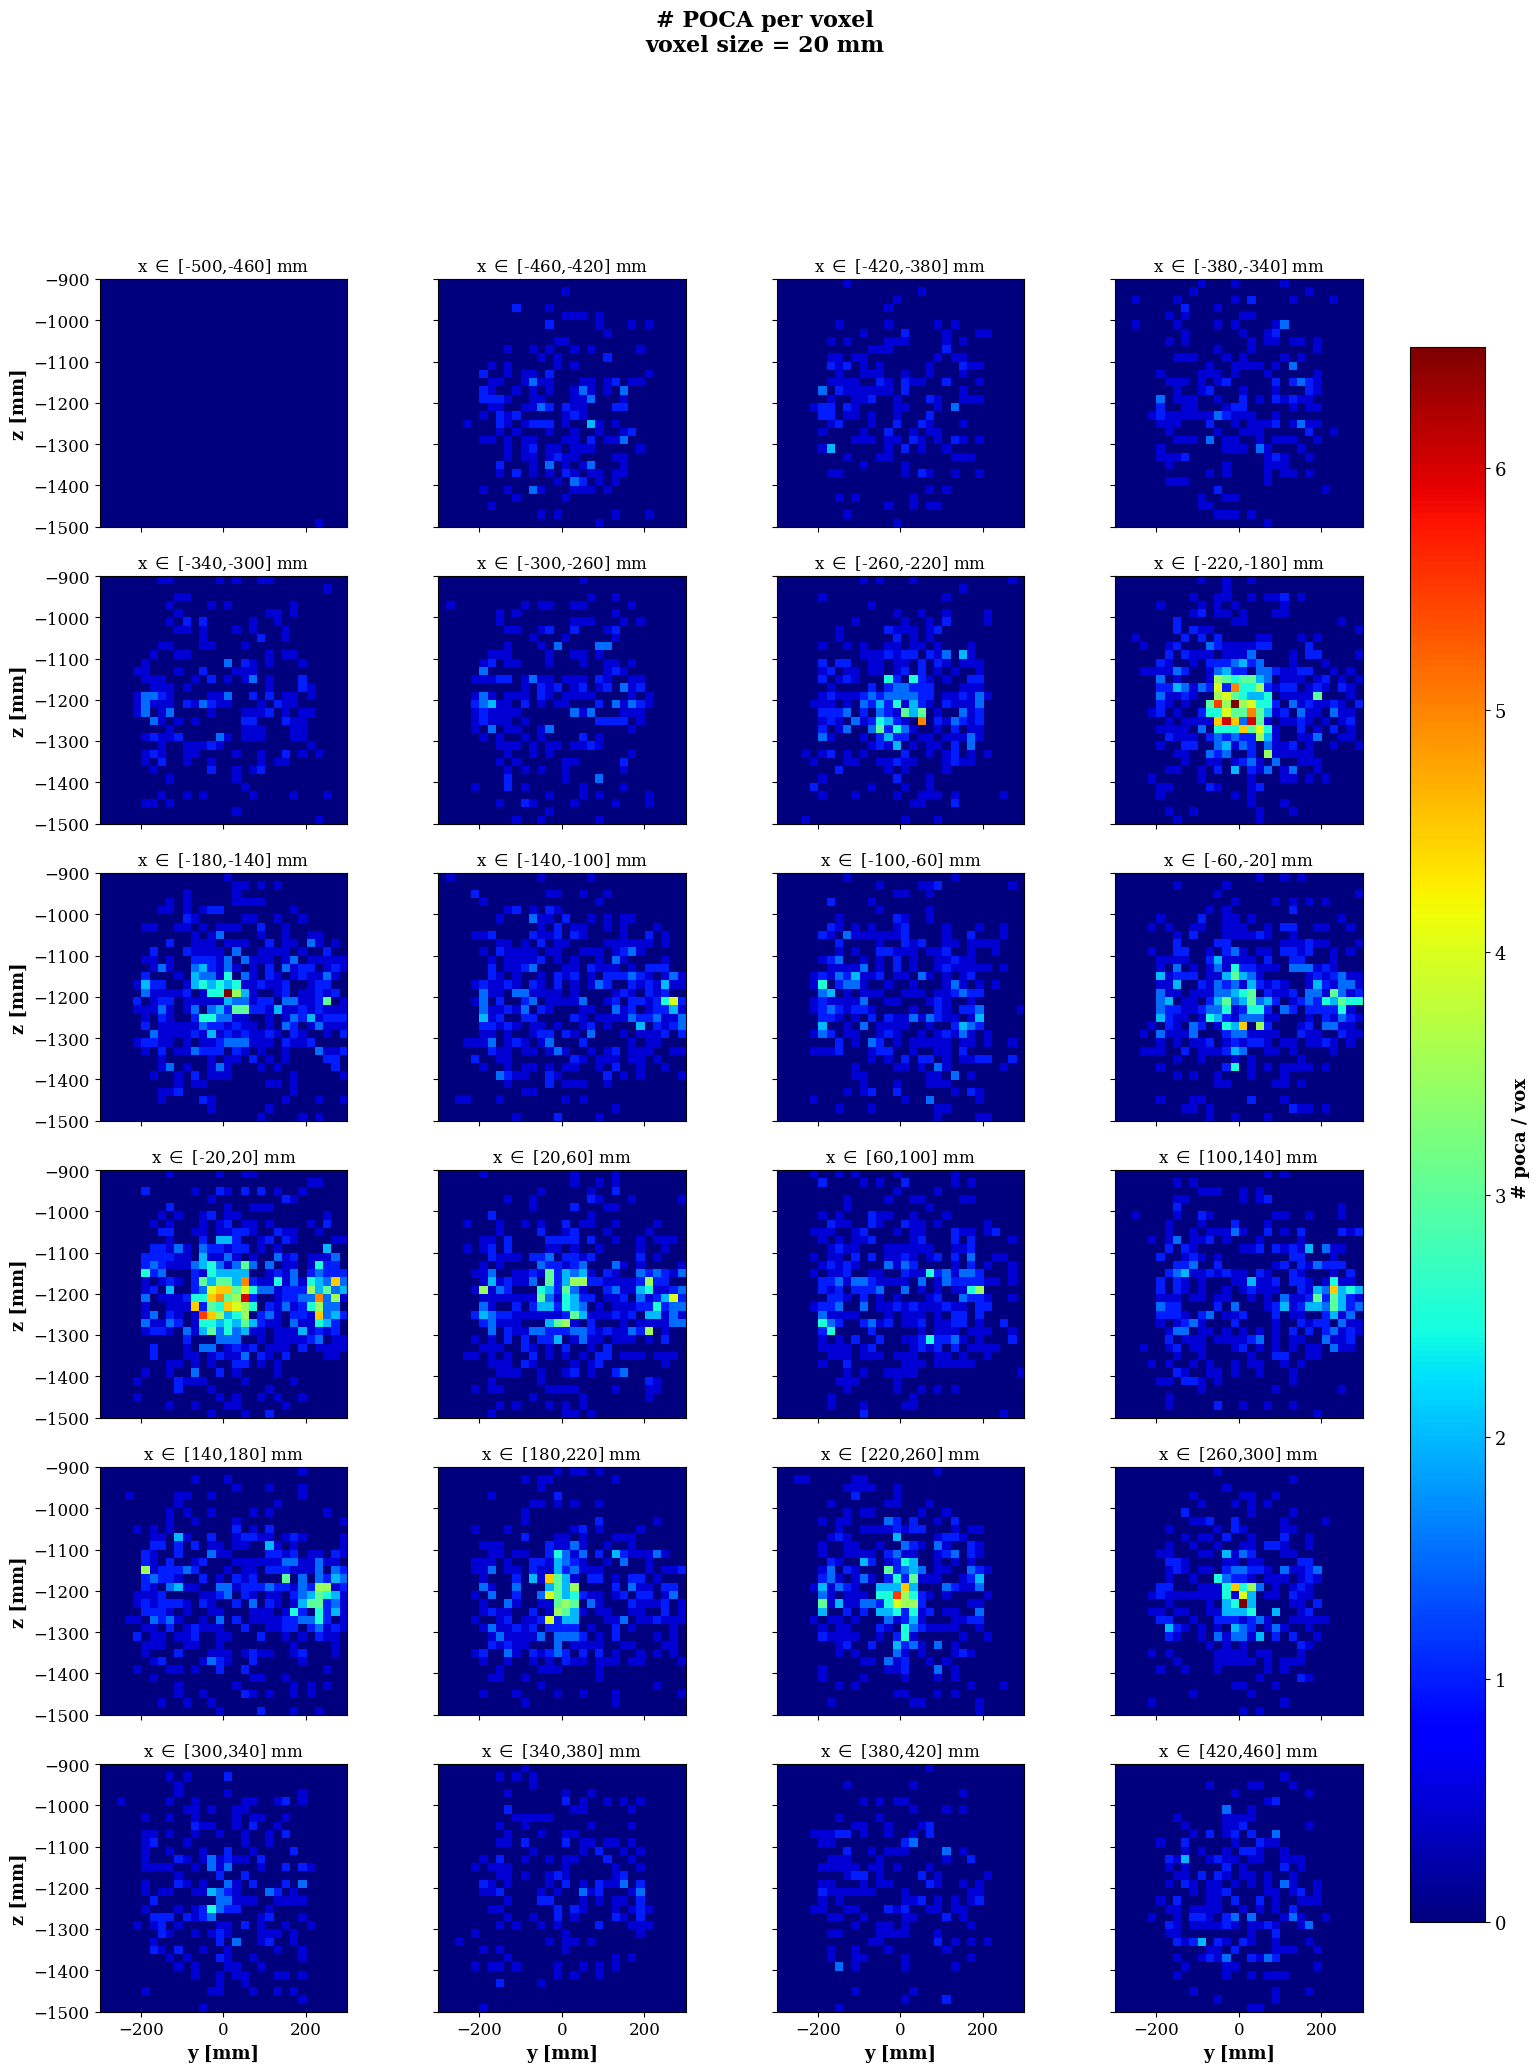

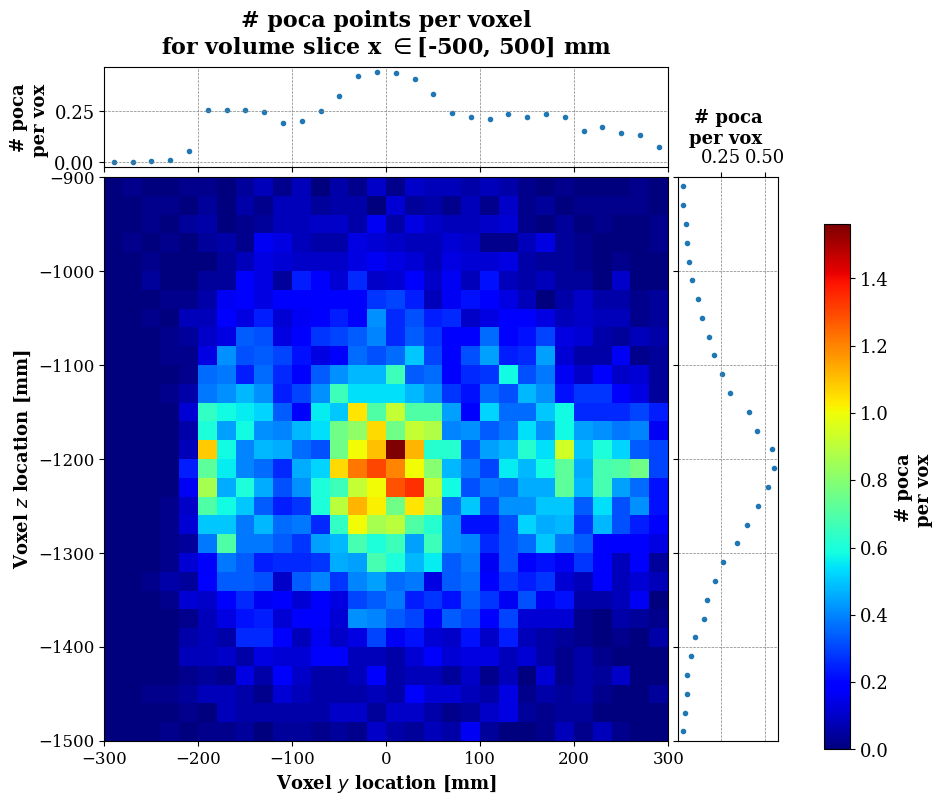

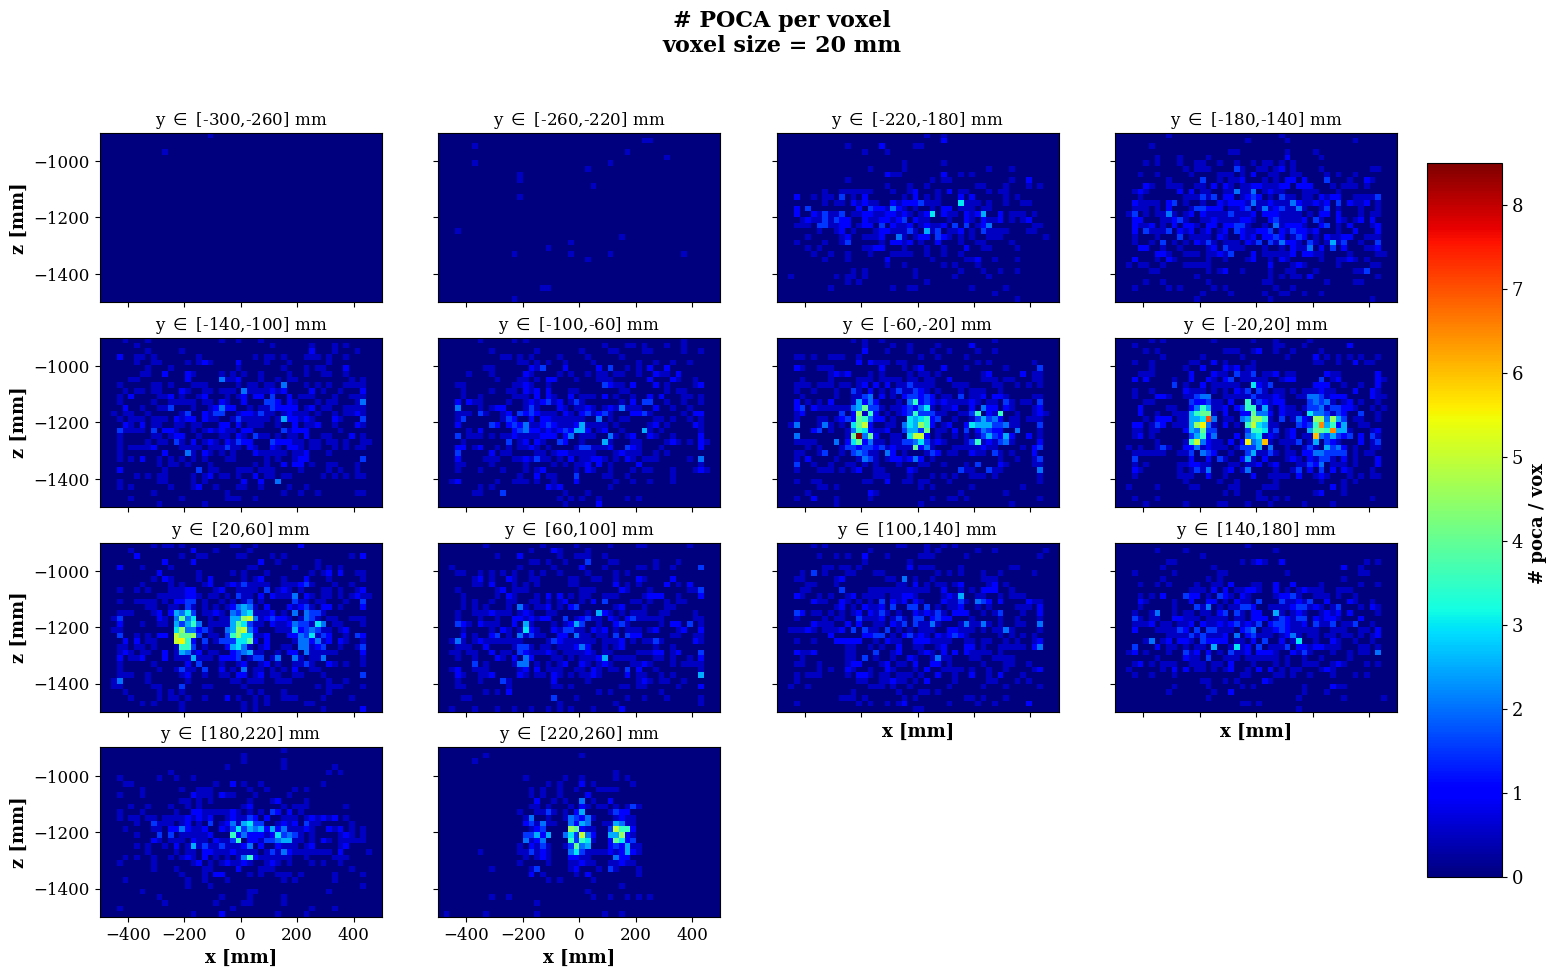

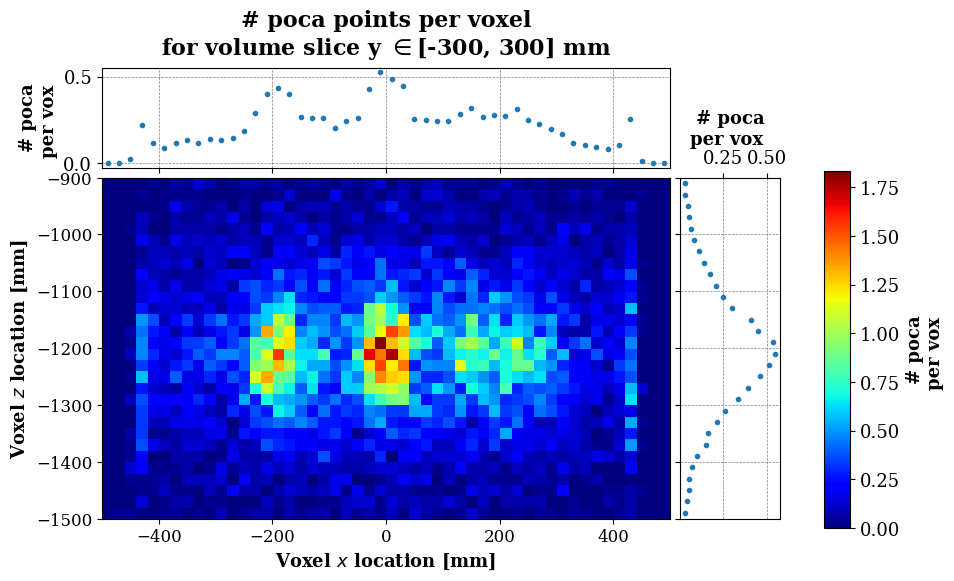

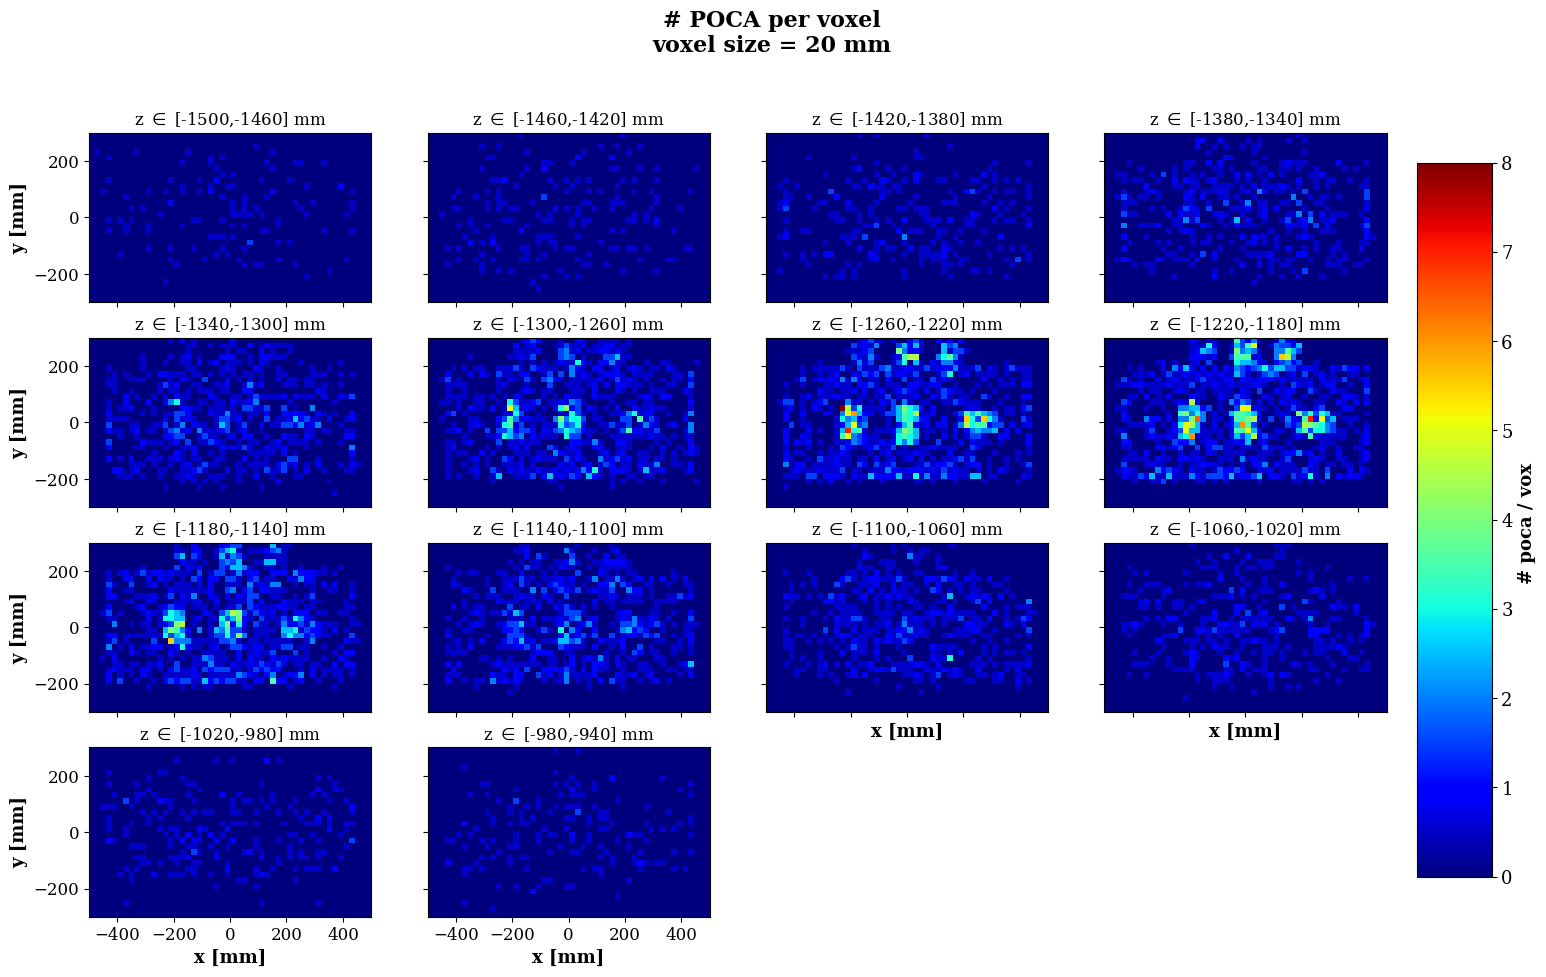

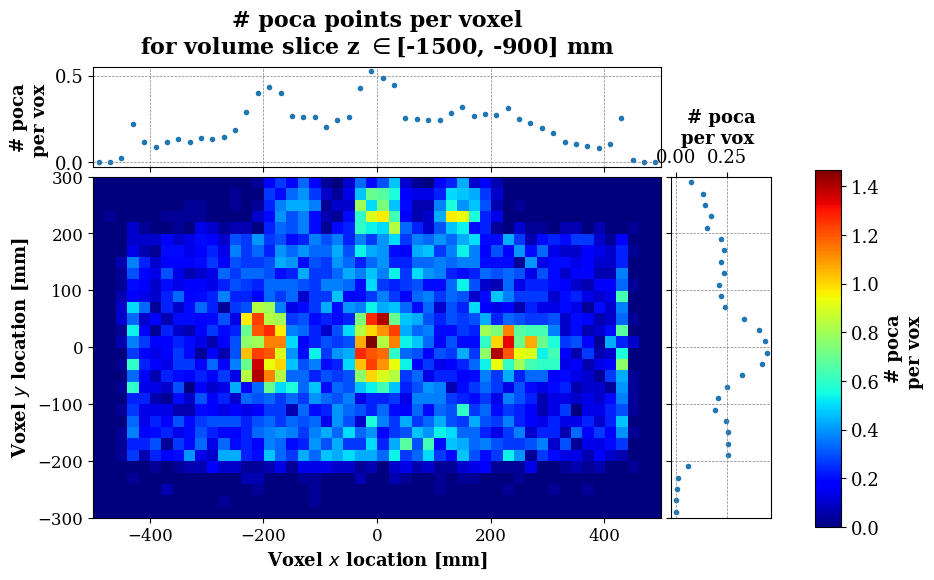


../../output/test1/poca/dtheta_cut_scan directory already exists


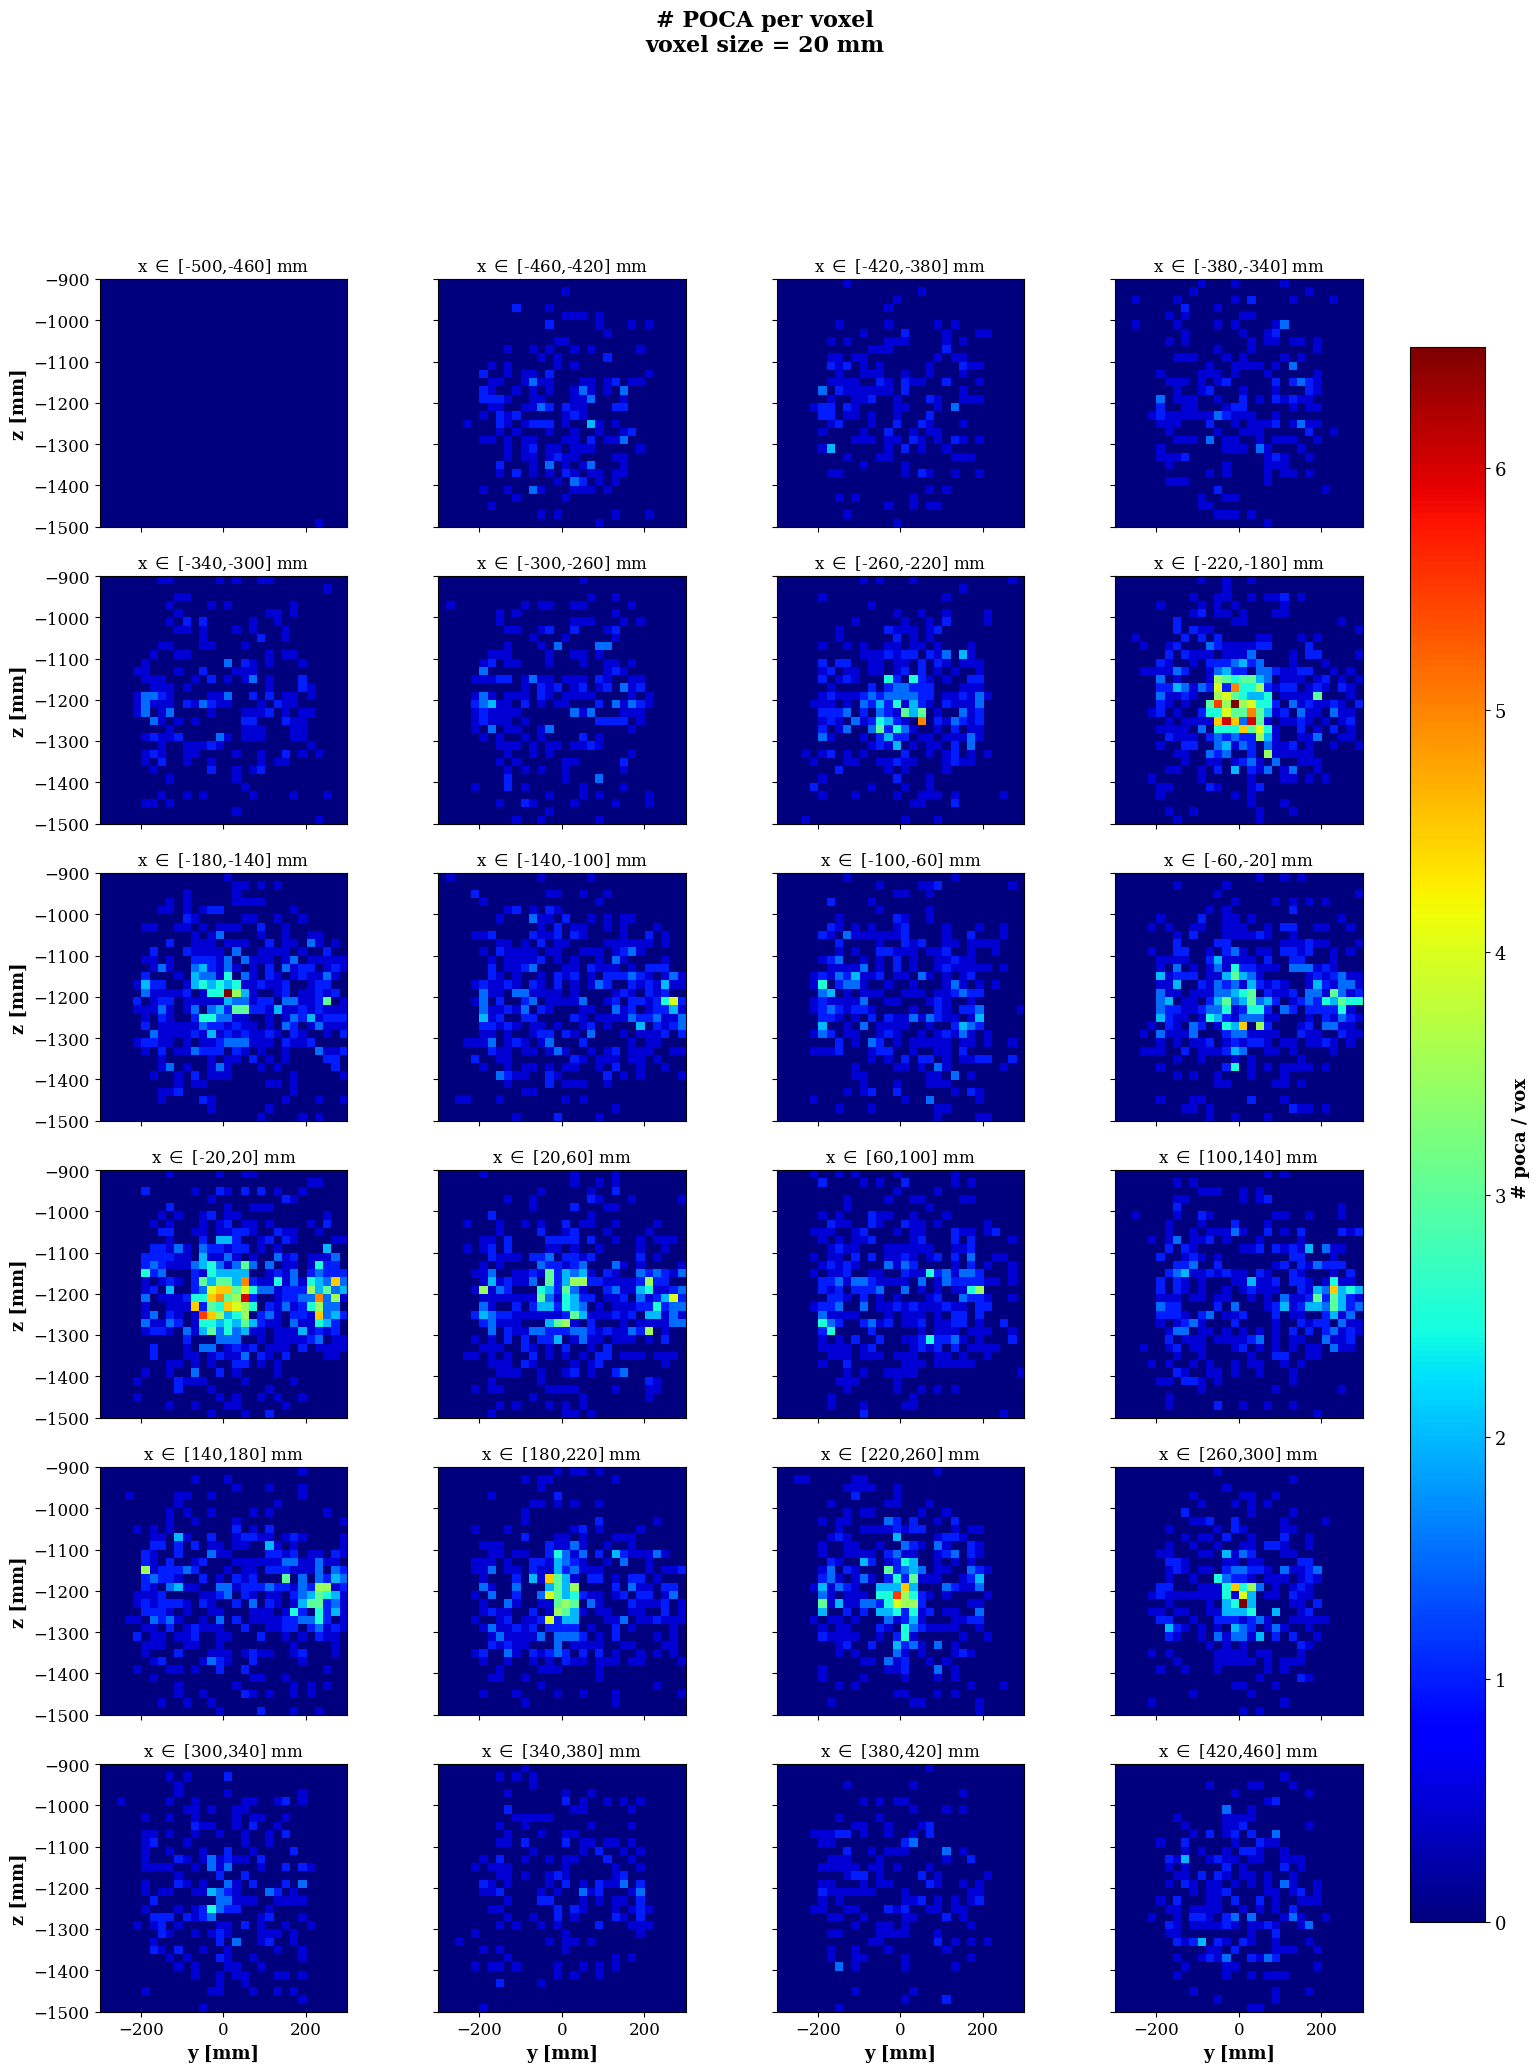

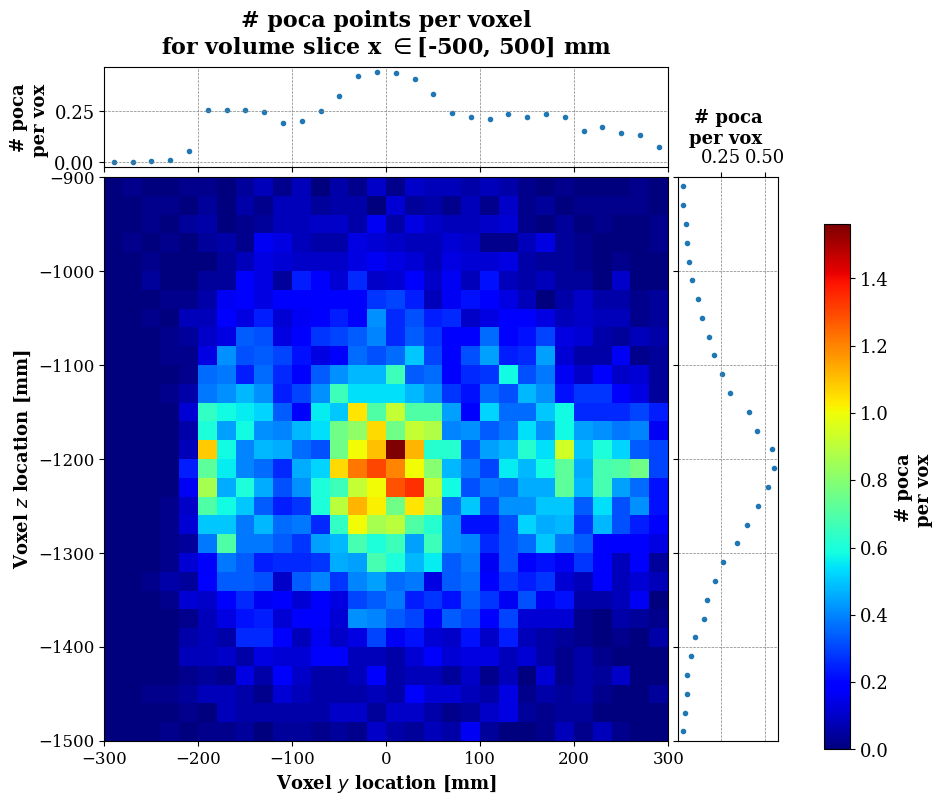

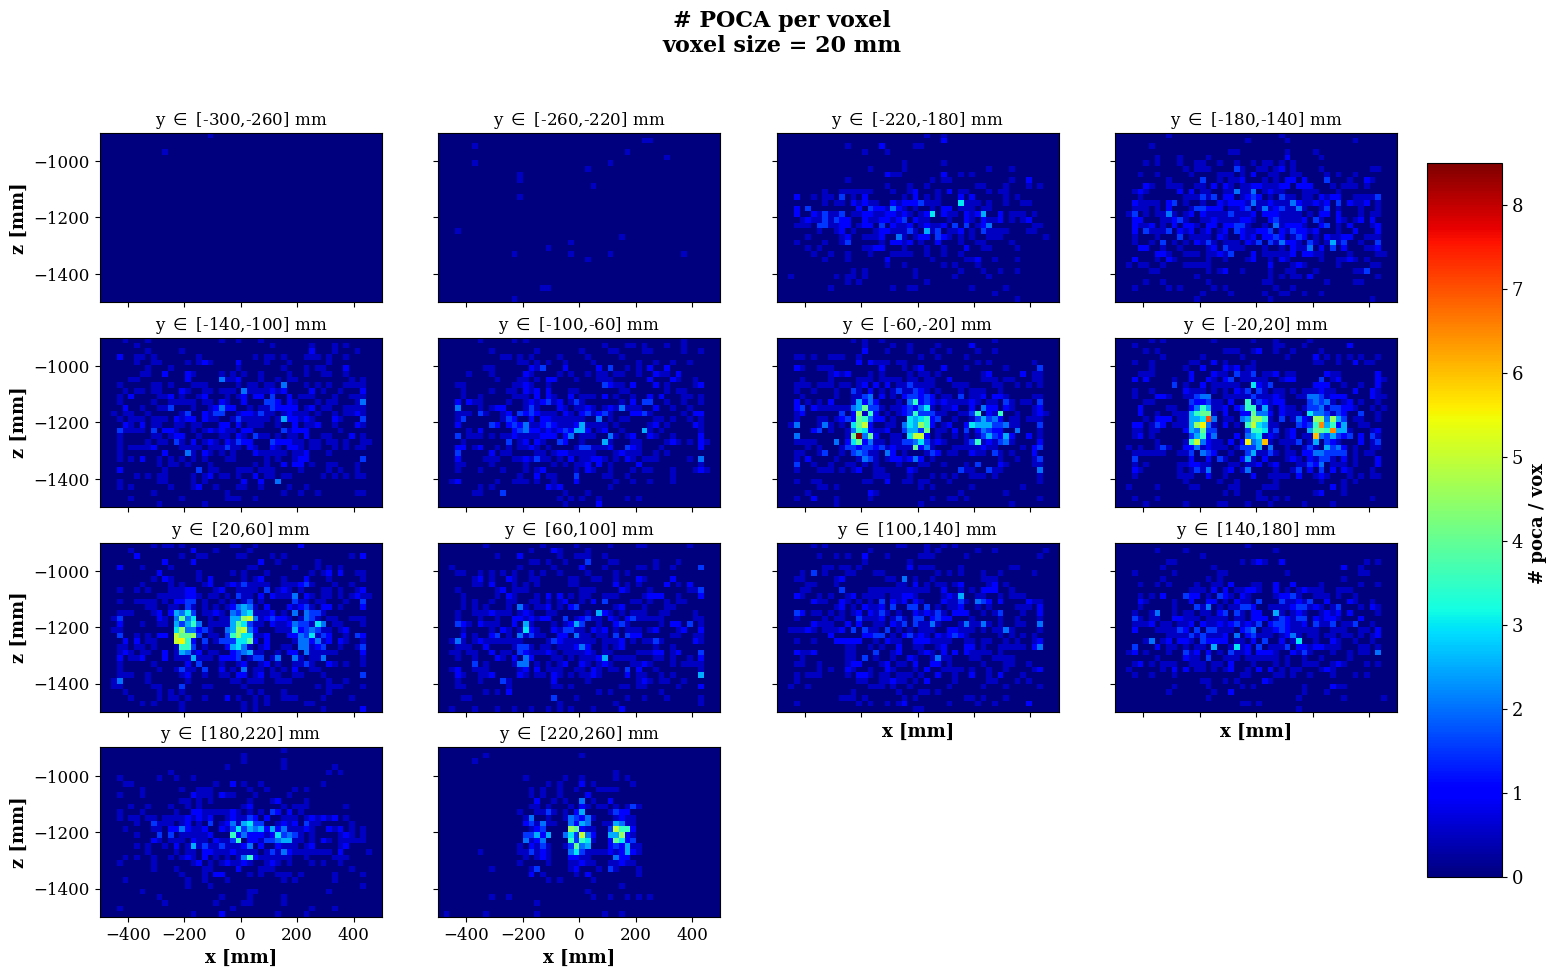

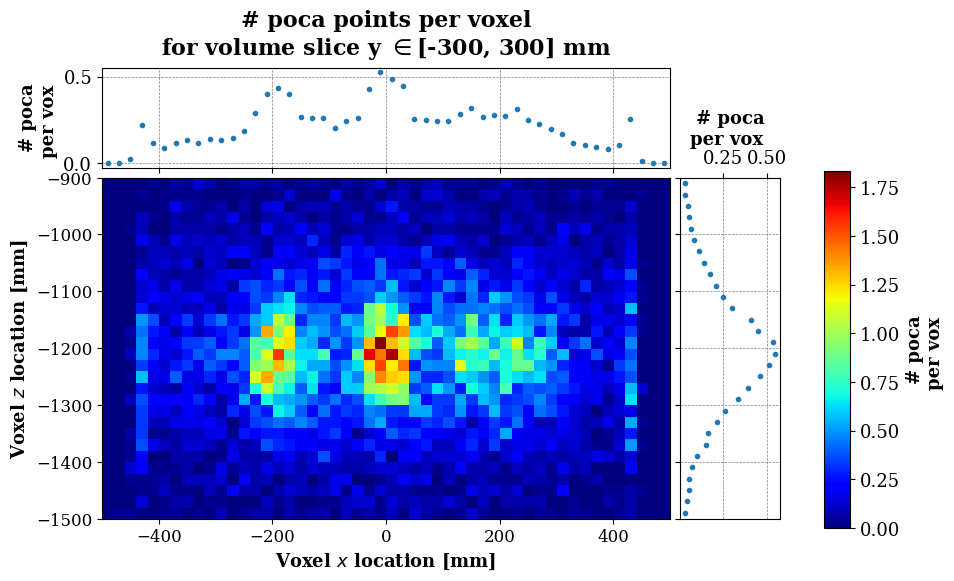

KeyboardInterrupt: 

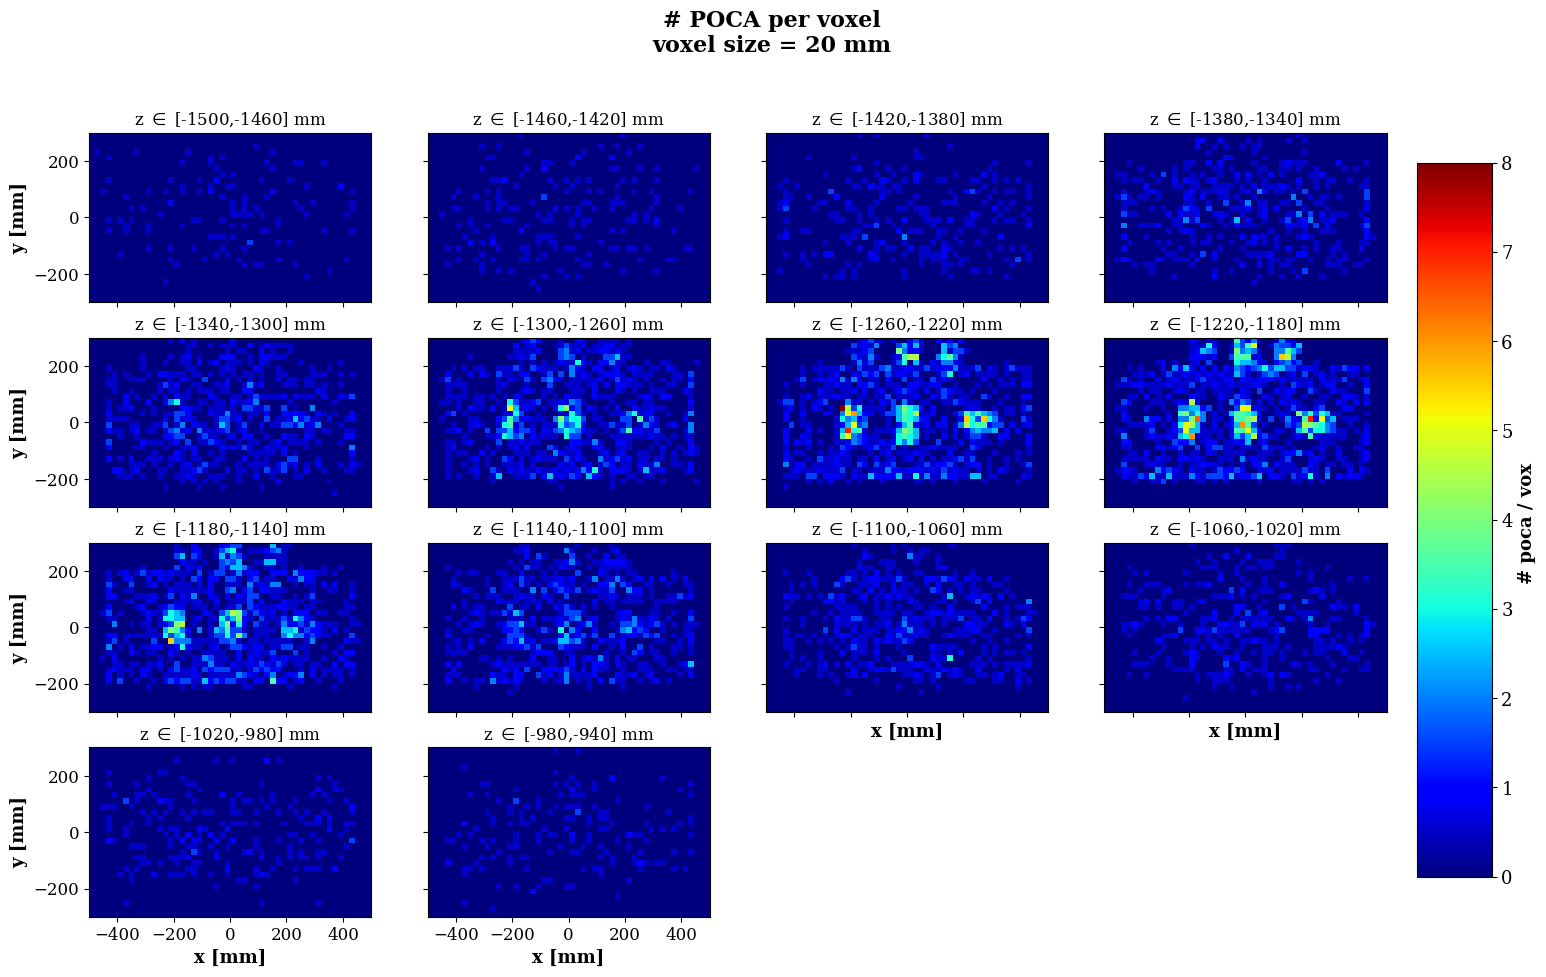

In [27]:
dtheta_cut_scan(
    dtheta_values=dtheta_values, 
    mst = mst, 
    directory="../../output/test1/poca/dtheta_cut_scan/")